In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from pickle import load
import tensorflow as tf
from tensorflow import keras
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

tf.random.set_seed(42)
K = keras.backend

from sklearn.preprocessing import StandardScaler,PowerTransformer
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import os
from helper import *

hr_data = np.load("coarse_grained.npy")

data1 = np.mean(hr_data.reshape((hr_data.shape[0],2,64,8,8),order="C"),axis=4)

data2 = np.mean(data1.reshape((hr_data.shape[0],2,8,8,8),order="C"),axis=3)

data = data2.reshape(data2.shape[0],-1)

hr_data_reshape = hr_data.reshape(hr_data.shape[0],-1)

training_data = data[:600,:]
hold_out_val = data[10000:15000]
hold_out = data[28000:,:]

training_data_high_res = hr_data_reshape[:600,:]
hold_out_val_high_res = hr_data_reshape[10000:15000]
hold_out_high_res = hr_data_reshape[28000:,:]

training_data_scaled = (training_data - training_data.mean())/training_data.std()
hold_out_val_scaled = (hold_out_val-training_data.mean())/training_data.std()
hold_out_scaled = (hold_out-training_data.mean())/training_data.std()

training_data_scaled = np.expand_dims(training_data_scaled,axis=1)
hold_out_val_scaled = np.expand_dims(hold_out_val_scaled,axis=1)
hold_out_scaled = np.expand_dims(hold_out_scaled,axis=1)


training_data_hr_scaled = (training_data_high_res - training_data_high_res.mean())/training_data_high_res.std()
hold_out_hr_val_scaled = (hold_out_val_high_res-training_data_high_res.mean())/training_data_high_res.std()
hold_out_hr_scaled = (hold_out_high_res-training_data_high_res.mean())/training_data_high_res.std()


training_data_hr_scaled = np.expand_dims(training_data_hr_scaled,axis=1)
hold_out_hr_val_scaled = np.expand_dims(hold_out_hr_val_scaled,axis=1)
hold_out_hr_scaled = np.expand_dims(hold_out_hr_scaled,axis=1)

history_length = 100

k = 1

num_dims = 128
num_dims_hr = 8192

#Prepare RNN sequences

def prepare_datasets_for_RNN(dataset,history_length,num_dims):
    dataset = dataset[:(dataset.shape[0]//history_length)*history_length,:] # to make it multiple of history
    dataset_shape = dataset.shape[0]
    reshaped = dataset.reshape(int(dataset_shape/history_length),history_length,k,num_dims)
    add_on = reshaped[1:,0,:,:]
    add_on = add_on.reshape(int(dataset_shape/history_length)-1,1,k,num_dims)
    reshaped = reshaped[:-1,:,:,:]
    concat = np.concatenate((reshaped,add_on),axis=1)
    concat = concat.reshape(((int(dataset_shape/history_length)-1)*(history_length+1),k,num_dims))
    concat = concat.reshape((k*(int(dataset_shape/history_length)-1)*(history_length+1),num_dims),order="F")
    features = concat.reshape(k*(int(dataset_shape/history_length)-1),(history_length+1),num_dims)
    
    return features

train_nn_features = prepare_datasets_for_RNN(training_data_scaled,history_length,num_dims)
valid_nn_features = prepare_datasets_for_RNN(hold_out_val_scaled,history_length,num_dims)
test_nn_features = hold_out_scaled.transpose([1,0,2])

train_hr_nn_features = prepare_datasets_for_RNN(training_data_hr_scaled,history_length,num_dims_hr)
valid_hr_nn_features =  prepare_datasets_for_RNN(hold_out_hr_val_scaled,history_length,num_dims_hr)
test_hr_nn_features =  hold_out_hr_scaled.transpose([1,0,2])

# RNN #

In [6]:
train_nn_input = train_nn_features[:,:-1,:]
train_nn_output = train_nn_features[:,1:,:]

train_hr_nn_input = train_hr_nn_features[:,:-1,:]
train_hr_nn_output = train_hr_nn_features[:,1:,:]

train_shape = train_nn_input.shape[0]


valid_nn_input = valid_nn_features[:,:-1,:]
valid_nn_output = valid_nn_features[:,1:,:]

valid_hr_nn_input = valid_hr_nn_features[:,:-1,:]
valid_hr_nn_output = valid_hr_nn_features[:,1:,:]

valid_shape = valid_nn_input.shape[0]


test_nn_input = test_nn_features[:,:-1,:]
test_nn_output = test_nn_features[:,1:,:]

test_hr_nn_input = test_hr_nn_features[:,:-1,:]
test_hr_nn_output = test_hr_nn_features[:,1:,:]

test_shape = test_nn_input.shape[0]

def loglik_gaussian_x(array,mean,sigma):
    term = -K.log(sigma**2 * 2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5*term
    return tf.math.reduce_sum(loglik,axis=[1,2])

def loglik_gaussian_hr(array,mean,sigma):
    term = -K.log(sigma**2 * 2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5*term
    return tf.math.reduce_sum(loglik,axis=[1,2])

def loss(loglikelihood_x):
    loglik = loglikelihood_x 
    loss = -loglik / history_length #to make it avg per spatial vector
    return tf.reduce_mean(loss)

def valid_loss(valid_list,simulator,sigma_x,hr=False):
    mean = simulator(valid_list,training=False)[0]
    if hr == False:
        return -np.mean(loglik_gaussian_x(valid_list[1],mean,sigma_x))
    if hr == True:
        return -np.mean(loglik_gaussian_x(valid_list[3],mean,sigma_x))


hidden_state_size = 8

hidden_in_train = np.zeros(shape=(train_shape,hidden_state_size))
input_list = [train_nn_input,train_nn_output,train_hr_nn_input,train_hr_nn_output,hidden_in_train]

hidden_in_test = np.zeros(shape=(test_shape,hidden_state_size))
test_list = [test_nn_input,test_nn_output,test_hr_nn_input,test_hr_nn_output,hidden_in_test]

hidden_in_valid = np.zeros(shape=(valid_shape,hidden_state_size))
valid_list = [valid_nn_input,valid_nn_output,valid_hr_nn_input,valid_hr_nn_output,hidden_in_valid]

# No TL

0
Epoch 0/400
5/5 [==============================] - trainLoss: 36.3360  Val_loss: -915.7139 
Epoch 1/400
5/5 [==============================] - trainLoss: 32.3379  Val_loss: -1333.1233 
Epoch 2/400
5/5 [==============================] - trainLoss: 30.5930  Val_loss: -1733.3917 
Epoch 3/400
5/5 [==============================] - trainLoss: 28.7273  Val_loss: -2129.8665 
Epoch 4/400
5/5 [==============================] - trainLoss: 22.7337  Val_loss: -2511.6643 
Epoch 5/400
5/5 [==============================] - trainLoss: 18.5223  Val_loss: -2878.9331 
Epoch 6/400
5/5 [==============================] - trainLoss: 15.8417  Val_loss: -3231.6279 
Epoch 7/400
5/5 [==============================] - trainLoss: 15.1762  Val_loss: -3571.5825 
Epoch 8/400
5/5 [==============================] - trainLoss: 12.5266  Val_loss: -3893.1560 
Epoch 9/400
5/5 [==============================] - trainLoss: 6.0666  Val_loss: -4196.4878 
Epoch 10/400
5/5 [==============================] - trainLoss: 6.4651 

5/5 [==============================] - trainLoss: -51.2648  Val_loss: -4376.0190 
Epoch 32/400
5/5 [==============================] - trainLoss: -51.0566  Val_loss: -3938.5549 
Epoch 33/400
5/5 [==============================] - trainLoss: -67.3445  Val_loss: -3449.3853 
Epoch 34/400
5/5 [==============================] - trainLoss: -69.0169  Val_loss: -2918.5288 
Epoch 35/400
5/5 [==============================] - trainLoss: -73.8755  Val_loss: -2364.0999 
Epoch 36/400
5/5 [==============================] - trainLoss: -70.8433  Val_loss: -1778.2422 
Epoch 37/400
5/5 [==============================] - trainLoss: -69.6910  Val_loss: -1219.8218 
Epoch 38/400
5/5 [==============================] - trainLoss: -80.6157  Val_loss: -633.7155 
Epoch 39/400
5/5 [==============================] - trainLoss: -74.8239  Val_loss: -58.2979 
Epoch 40/400
5/5 [==============================] - trainLoss: -84.0352  Val_loss: 588.5109 
Epoch 41/400
5/5 [==============================] - trainLoss: -99.4

5/5 [==============================] - trainLoss: -453.5244  Val_loss: 408043.7188 
Epoch 200/400
5/5 [==============================] - trainLoss: -462.4314  Val_loss: 412438.6562 
Epoch 201/400
5/5 [==============================] - trainLoss: -454.8512  Val_loss: 419996.5000 
Epoch 202/400
5/5 [==============================] - trainLoss: -454.5952  Val_loss: 427662.2188 
Epoch 203/400
5/5 [==============================] - trainLoss: -452.0343  Val_loss: 437325.9062 
Epoch 204/400
5/5 [==============================] - trainLoss: -451.8115  Val_loss: 446799.2500 
Epoch 205/400
5/5 [==============================] - trainLoss: -453.0906  Val_loss: 454414.8125 
Epoch 206/400
5/5 [==============================] - trainLoss: -458.5188  Val_loss: 462262.0000 
Epoch 207/400
5/5 [==============================] - trainLoss: -460.4611  Val_loss: 471584.0312 
Epoch 208/400
5/5 [==============================] - trainLoss: -462.2957  Val_loss: 481009.8438 
Epoch 209/400
5/5 [===============

5/5 [==============================] - trainLoss: -482.2906  Val_loss: 1450151.8750 
Epoch 366/400
5/5 [==============================] - trainLoss: -482.5006  Val_loss: 1442677.5000 
Epoch 367/400
5/5 [==============================] - trainLoss: -480.5768  Val_loss: 1432262.2500 
Epoch 368/400
5/5 [==============================] - trainLoss: -465.2636  Val_loss: 1434033.7500 
Epoch 369/400
5/5 [==============================] - trainLoss: -482.5719  Val_loss: 1454244.8750 
Epoch 370/400
5/5 [==============================] - trainLoss: -484.1001  Val_loss: 1481930.2500 
Epoch 371/400
5/5 [==============================] - trainLoss: -482.1014  Val_loss: 1477690.2500 
Epoch 372/400
5/5 [==============================] - trainLoss: -475.4137  Val_loss: 1472720.1250 
Epoch 373/400
5/5 [==============================] - trainLoss: -492.8703  Val_loss: 1465816.0000 
Epoch 374/400
5/5 [==============================] - trainLoss: -472.6201  Val_loss: 1468202.0000 
Epoch 375/400
5/5 [=====

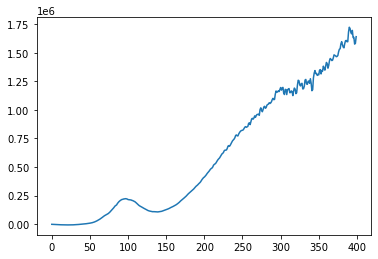

1
Epoch 0/400
5/5 [==============================] - trainLoss: 50.8409  Val_loss: 834.3146 
Epoch 1/400
5/5 [==============================] - trainLoss: 45.9380  Val_loss: 517.8829 
Epoch 2/400
5/5 [==============================] - trainLoss: 42.4985  Val_loss: 209.5294 
Epoch 3/400
5/5 [==============================] - trainLoss: 39.6878  Val_loss: -86.4161 
Epoch 4/400
5/5 [==============================] - trainLoss: 38.8022  Val_loss: -367.7949 
Epoch 5/400
5/5 [==============================] - trainLoss: 31.5788  Val_loss: -630.9571 
Epoch 6/400
5/5 [==============================] - trainLoss: 31.7890  Val_loss: -874.6279 
Epoch 7/400
5/5 [==============================] - trainLoss: 26.2184  Val_loss: -1096.2897 
Epoch 8/400
5/5 [==============================] - trainLoss: 27.7103  Val_loss: -1300.5952 
Epoch 9/400
5/5 [==============================] - trainLoss: 23.1719  Val_loss: -1485.3267 
Epoch 10/400
5/5 [==============================] - trainLoss: 16.0482  Val_los

5/5 [==============================] - trainLoss: -374.1949  Val_loss: 118712.6016 
Epoch 123/400
5/5 [==============================] - trainLoss: -373.0208  Val_loss: 111400.6250 
Epoch 124/400
5/5 [==============================] - trainLoss: -383.7823  Val_loss: 105689.0391 
Epoch 125/400
5/5 [==============================] - trainLoss: -384.8185  Val_loss: 99642.8594 
Epoch 126/400
5/5 [==============================] - trainLoss: -397.1344  Val_loss: 93884.2031 
Epoch 127/400
5/5 [==============================] - trainLoss: -386.6239  Val_loss: 87721.7344 
Epoch 128/400
5/5 [==============================] - trainLoss: -387.6221  Val_loss: 81962.5078 
Epoch 129/400
5/5 [==============================] - trainLoss: -398.2652  Val_loss: 77090.3125 
Epoch 130/400
5/5 [==============================] - trainLoss: -395.9965  Val_loss: 72087.3906 
Epoch 131/400
5/5 [==============================] - trainLoss: -400.1562  Val_loss: 66751.6562 
Epoch 132/400
5/5 [======================

5/5 [==============================] - trainLoss: -460.0245  Val_loss: 227337.2500 
Epoch 291/400
5/5 [==============================] - trainLoss: -458.5307  Val_loss: 231789.8750 
Epoch 292/400
5/5 [==============================] - trainLoss: -472.9031  Val_loss: 229973.3906 
Epoch 293/400
5/5 [==============================] - trainLoss: -473.7104  Val_loss: 234841.5938 
Epoch 294/400
5/5 [==============================] - trainLoss: -479.8005  Val_loss: 231335.3438 
Epoch 295/400
5/5 [==============================] - trainLoss: -487.9995  Val_loss: 229920.5938 
Epoch 296/400
5/5 [==============================] - trainLoss: -465.5892  Val_loss: 242118.1094 
Epoch 297/400
5/5 [==============================] - trainLoss: -476.6234  Val_loss: 242026.1562 
Epoch 298/400
5/5 [==============================] - trainLoss: -471.5464  Val_loss: 240140.4688 
Epoch 299/400
5/5 [==============================] - trainLoss: -467.8260  Val_loss: 238948.3906 
Epoch 300/400
5/5 [===============

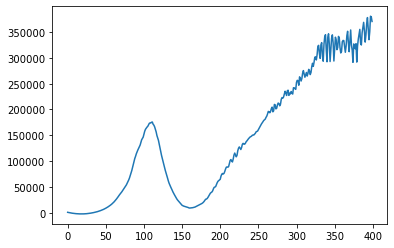

2
Epoch 0/400
5/5 [==============================] - trainLoss: 48.5525  Val_loss: -1269.3258 
Epoch 1/400
5/5 [==============================] - trainLoss: 46.2819  Val_loss: -1486.0443 
Epoch 2/400
5/5 [==============================] - trainLoss: 43.7108  Val_loss: -1689.7795 
Epoch 3/400
5/5 [==============================] - trainLoss: 43.0555  Val_loss: -1878.6110 
Epoch 4/400
5/5 [==============================] - trainLoss: 37.4672  Val_loss: -2045.7084 
Epoch 5/400
5/5 [==============================] - trainLoss: 37.2864  Val_loss: -2199.2458 
Epoch 6/400
5/5 [==============================] - trainLoss: 31.6879  Val_loss: -2337.1960 
Epoch 7/400
5/5 [==============================] - trainLoss: 32.2004  Val_loss: -2463.5420 
Epoch 8/400
5/5 [==============================] - trainLoss: 25.8115  Val_loss: -2571.1538 
Epoch 9/400
5/5 [==============================] - trainLoss: 26.2775  Val_loss: -2674.2471 
Epoch 10/400
5/5 [==============================] - trainLoss: 24.01

5/5 [==============================] - trainLoss: -9.1320  Val_loss: -3712.5762 
Epoch 25/400
5/5 [==============================] - trainLoss: -10.7477  Val_loss: -3768.7571 
Epoch 26/400
5/5 [==============================] - trainLoss: -14.0780  Val_loss: -3823.1951 
Epoch 27/400
5/5 [==============================] - trainLoss: -13.0581  Val_loss: -3885.9971 
Epoch 28/400
5/5 [==============================] - trainLoss: -20.9237  Val_loss: -3945.0801 
Epoch 29/400
5/5 [==============================] - trainLoss: -17.5810  Val_loss: -3989.6174 
Epoch 30/400
5/5 [==============================] - trainLoss: -23.6575  Val_loss: -4026.1143 
Epoch 31/400
5/5 [==============================] - trainLoss: -24.6590  Val_loss: -4066.2122 
Epoch 32/400
5/5 [==============================] - trainLoss: -28.6333  Val_loss: -4102.8716 
Epoch 33/400
5/5 [==============================] - trainLoss: -30.1113  Val_loss: -4146.0396 
Epoch 34/400
5/5 [==============================] - trainLoss: -

5/5 [==============================] - trainLoss: -432.1175  Val_loss: 21249.9141 
Epoch 159/400
5/5 [==============================] - trainLoss: -426.7092  Val_loss: 21110.6816 
Epoch 160/400
5/5 [==============================] - trainLoss: -419.4645  Val_loss: 21097.7363 
Epoch 161/400
5/5 [==============================] - trainLoss: -418.1933  Val_loss: 21389.6250 
Epoch 162/400
5/5 [==============================] - trainLoss: -418.1083  Val_loss: 21861.1309 
Epoch 163/400
5/5 [==============================] - trainLoss: -425.8568  Val_loss: 22279.8906 
Epoch 164/400
5/5 [==============================] - trainLoss: -425.0725  Val_loss: 22578.7148 
Epoch 165/400
5/5 [==============================] - trainLoss: -434.7839  Val_loss: 22906.4512 
Epoch 166/400
5/5 [==============================] - trainLoss: -442.2787  Val_loss: 23286.9395 
Epoch 167/400
5/5 [==============================] - trainLoss: -428.7938  Val_loss: 23675.8652 
Epoch 168/400
5/5 [=========================

5/5 [==============================] - trainLoss: -480.0767  Val_loss: 233619.3750 
Epoch 326/400
5/5 [==============================] - trainLoss: -478.6077  Val_loss: 234311.5156 
Epoch 327/400
5/5 [==============================] - trainLoss: -462.0086  Val_loss: 232232.5156 
Epoch 328/400
5/5 [==============================] - trainLoss: -481.4839  Val_loss: 233565.4844 
Epoch 329/400
5/5 [==============================] - trainLoss: -477.8980  Val_loss: 236437.5938 
Epoch 330/400
5/5 [==============================] - trainLoss: -469.8118  Val_loss: 240401.9375 
Epoch 331/400
5/5 [==============================] - trainLoss: -474.7569  Val_loss: 244244.7969 
Epoch 332/400
5/5 [==============================] - trainLoss: -468.0887  Val_loss: 237810.0000 
Epoch 333/400
5/5 [==============================] - trainLoss: -467.9608  Val_loss: 236884.7812 
Epoch 334/400
5/5 [==============================] - trainLoss: -477.4512  Val_loss: 247798.8125 
Epoch 335/400
5/5 [===============

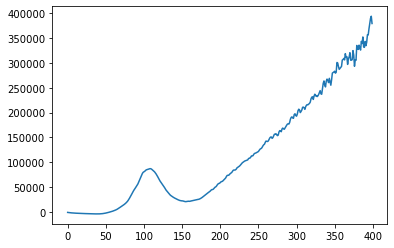

3
Epoch 0/400
5/5 [==============================] - trainLoss: 24.8935  Val_loss: -3857.1111 
Epoch 1/400
5/5 [==============================] - trainLoss: 22.0896  Val_loss: -4165.9258 
Epoch 2/400
5/5 [==============================] - trainLoss: 14.6970  Val_loss: -4465.3774 
Epoch 3/400
5/5 [==============================] - trainLoss: 15.7032  Val_loss: -4751.1162 
Epoch 4/400
5/5 [==============================] - trainLoss: 14.2495  Val_loss: -5022.6777 
Epoch 5/400
5/5 [==============================] - trainLoss: 10.4670  Val_loss: -5280.6191 
Epoch 6/400
5/5 [==============================] - trainLoss: 6.9895  Val_loss: -5526.0645 
Epoch 7/400
5/5 [==============================] - trainLoss: 5.4701  Val_loss: -5755.0703 
Epoch 8/400
5/5 [==============================] - trainLoss: 0.3302  Val_loss: -5969.4878 
Epoch 9/400
5/5 [==============================] - trainLoss: 0.3869  Val_loss: -6166.9458 
Epoch 10/400
5/5 [==============================] - trainLoss: -0.4314  

5/5 [==============================] - trainLoss: -382.5221  Val_loss: 99213.6875 
Epoch 120/400
5/5 [==============================] - trainLoss: -403.7131  Val_loss: 93836.7031 
Epoch 121/400
5/5 [==============================] - trainLoss: -379.9443  Val_loss: 88842.5703 
Epoch 122/400
5/5 [==============================] - trainLoss: -393.5452  Val_loss: 84329.6562 
Epoch 123/400
5/5 [==============================] - trainLoss: -384.5528  Val_loss: 79947.5859 
Epoch 124/400
5/5 [==============================] - trainLoss: -390.6235  Val_loss: 75601.8438 
Epoch 125/400
5/5 [==============================] - trainLoss: -396.1706  Val_loss: 71790.4375 
Epoch 126/400
5/5 [==============================] - trainLoss: -398.5981  Val_loss: 67886.0234 
Epoch 127/400
5/5 [==============================] - trainLoss: -406.0724  Val_loss: 63936.8320 
Epoch 128/400
5/5 [==============================] - trainLoss: -395.8208  Val_loss: 60283.4492 
Epoch 129/400
5/5 [=========================

5/5 [==============================] - trainLoss: -469.7201  Val_loss: 433002.1250 
Epoch 287/400
5/5 [==============================] - trainLoss: -471.5315  Val_loss: 430237.2188 
Epoch 288/400
5/5 [==============================] - trainLoss: -470.6314  Val_loss: 429328.6562 
Epoch 289/400
5/5 [==============================] - trainLoss: -479.3661  Val_loss: 437072.9375 
Epoch 290/400
5/5 [==============================] - trainLoss: -484.9140  Val_loss: 447882.8438 
Epoch 291/400
5/5 [==============================] - trainLoss: -464.8002  Val_loss: 459072.7500 
Epoch 292/400
5/5 [==============================] - trainLoss: -476.3842  Val_loss: 455566.7500 
Epoch 293/400
5/5 [==============================] - trainLoss: -470.9258  Val_loss: 468131.7500 
Epoch 294/400
5/5 [==============================] - trainLoss: -473.7634  Val_loss: 467911.7812 
Epoch 295/400
5/5 [==============================] - trainLoss: -466.9323  Val_loss: 467336.5000 
Epoch 296/400
5/5 [===============

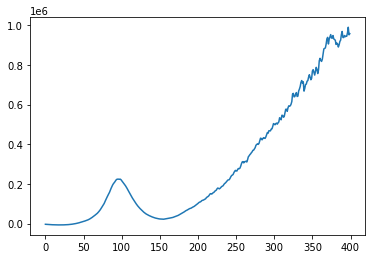

4
Epoch 0/400
5/5 [==============================] - trainLoss: 30.8645  Val_loss: -2189.1216 
Epoch 1/400
5/5 [==============================] - trainLoss: 25.9203  Val_loss: -2454.2012 
Epoch 2/400
5/5 [==============================] - trainLoss: 26.4186  Val_loss: -2708.4502 
Epoch 3/400
5/5 [==============================] - trainLoss: 26.4420  Val_loss: -2949.6340 
Epoch 4/400
5/5 [==============================] - trainLoss: 20.5054  Val_loss: -3178.3376 
Epoch 5/400
5/5 [==============================] - trainLoss: 23.5507  Val_loss: -3393.7063 
Epoch 6/400
5/5 [==============================] - trainLoss: 7.4136  Val_loss: -3593.0281 
Epoch 7/400
5/5 [==============================] - trainLoss: 17.7779  Val_loss: -3775.9426 
Epoch 8/400
5/5 [==============================] - trainLoss: -0.9726  Val_loss: -3939.9951 
Epoch 9/400
5/5 [==============================] - trainLoss: -6.8278  Val_loss: -4084.8611 
Epoch 10/400
5/5 [==============================] - trainLoss: 3.9065

5/5 [==============================] - trainLoss: -385.0317  Val_loss: 174834.9844 
Epoch 125/400
5/5 [==============================] - trainLoss: -386.6634  Val_loss: 168319.9219 
Epoch 126/400
5/5 [==============================] - trainLoss: -377.3611  Val_loss: 160837.7812 
Epoch 127/400
5/5 [==============================] - trainLoss: -386.3543  Val_loss: 154921.9219 
Epoch 128/400
5/5 [==============================] - trainLoss: -375.7158  Val_loss: 148597.4219 
Epoch 129/400
5/5 [==============================] - trainLoss: -391.9165  Val_loss: 143533.1094 
Epoch 130/400
5/5 [==============================] - trainLoss: -377.2696  Val_loss: 138448.9844 
Epoch 131/400
5/5 [==============================] - trainLoss: -389.6727  Val_loss: 133461.6719 
Epoch 132/400
5/5 [==============================] - trainLoss: -389.0632  Val_loss: 128793.0078 
Epoch 133/400
5/5 [==============================] - trainLoss: -382.8165  Val_loss: 123377.4219 
Epoch 134/400
5/5 [===============

5/5 [==============================] - trainLoss: -479.6648  Val_loss: 91174.3906 
Epoch 293/400
5/5 [==============================] - trainLoss: -473.0597  Val_loss: 91653.8672 
Epoch 294/400
5/5 [==============================] - trainLoss: -455.5051  Val_loss: 94357.9688 
Epoch 295/400
5/5 [==============================] - trainLoss: -467.1460  Val_loss: 89282.8281 
Epoch 296/400
5/5 [==============================] - trainLoss: -468.6354  Val_loss: 89402.2656 
Epoch 297/400
5/5 [==============================] - trainLoss: -464.9181  Val_loss: 91033.1406 
Epoch 298/400
5/5 [==============================] - trainLoss: -470.0474  Val_loss: 90928.5391 
Epoch 299/400
5/5 [==============================] - trainLoss: -468.6273  Val_loss: 96169.4688 
Epoch 300/400
5/5 [==============================] - trainLoss: -472.1509  Val_loss: 95910.3906 
Epoch 301/400
5/5 [==============================] - trainLoss: -469.4617  Val_loss: 98656.1406 
Epoch 302/400
5/5 [=========================

5/5 [==============================] - trainLoss: -486.8086  Val_loss: 202443.1094 
Epoch 377/400
5/5 [==============================] - trainLoss: -479.6927  Val_loss: 206652.7812 
Epoch 378/400
5/5 [==============================] - trainLoss: -495.0928  Val_loss: 208878.2812 
Epoch 379/400
5/5 [==============================] - trainLoss: -473.3785  Val_loss: 210991.5312 
Epoch 380/400
5/5 [==============================] - trainLoss: -472.9319  Val_loss: 209851.8750 
Epoch 381/400
5/5 [==============================] - trainLoss: -487.9680  Val_loss: 202775.1250 
Epoch 382/400
5/5 [==============================] - trainLoss: -487.1402  Val_loss: 204750.6719 
Epoch 383/400
5/5 [==============================] - trainLoss: -480.8241  Val_loss: 219903.5156 
Epoch 384/400
5/5 [==============================] - trainLoss: -481.8964  Val_loss: 224439.2812 
Epoch 385/400
5/5 [==============================] - trainLoss: -494.7254  Val_loss: 211119.4531 
Epoch 386/400
5/5 [===============

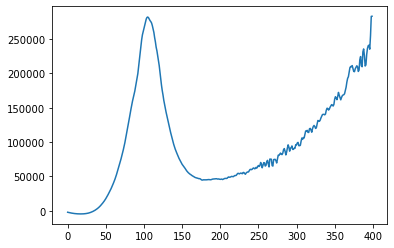

5
Epoch 0/400
5/5 [==============================] - trainLoss: 35.3013  Val_loss: -1529.7764 
Epoch 1/400
5/5 [==============================] - trainLoss: 31.9888  Val_loss: -1781.1853 
Epoch 2/400
5/5 [==============================] - trainLoss: 28.3384  Val_loss: -2017.8833 
Epoch 3/400
5/5 [==============================] - trainLoss: 26.8733  Val_loss: -2233.8586 
Epoch 4/400
5/5 [==============================] - trainLoss: 22.8660  Val_loss: -2434.7078 
Epoch 5/400
5/5 [==============================] - trainLoss: 19.7947  Val_loss: -2621.3853 
Epoch 6/400
5/5 [==============================] - trainLoss: 18.9721  Val_loss: -2790.5732 
Epoch 7/400
5/5 [==============================] - trainLoss: 16.3664  Val_loss: -2945.1187 
Epoch 8/400
5/5 [==============================] - trainLoss: 10.3812  Val_loss: -3095.2534 
Epoch 9/400
5/5 [==============================] - trainLoss: 10.2542  Val_loss: -3238.1978 
Epoch 10/400
5/5 [==============================] - trainLoss: 7.608

5/5 [==============================] - trainLoss: -275.1808  Val_loss: 115262.9453 
Epoch 91/400
5/5 [==============================] - trainLoss: -277.5380  Val_loss: 120288.9453 
Epoch 92/400
5/5 [==============================] - trainLoss: -281.0874  Val_loss: 124208.6016 
Epoch 93/400
5/5 [==============================] - trainLoss: -298.4042  Val_loss: 127427.1953 
Epoch 94/400
5/5 [==============================] - trainLoss: -293.4842  Val_loss: 130324.5938 
Epoch 95/400
5/5 [==============================] - trainLoss: -298.3795  Val_loss: 133752.2812 
Epoch 96/400
5/5 [==============================] - trainLoss: -306.1225  Val_loss: 136608.0000 
Epoch 97/400
5/5 [==============================] - trainLoss: -305.1893  Val_loss: 138727.4219 
Epoch 98/400
5/5 [==============================] - trainLoss: -314.1138  Val_loss: 140466.7812 
Epoch 99/400
5/5 [==============================] - trainLoss: -324.4399  Val_loss: 142017.5781 
Epoch 100/400
5/5 [========================

5/5 [==============================] - trainLoss: -469.0980  Val_loss: 162896.1094 
Epoch 259/400
5/5 [==============================] - trainLoss: -472.6659  Val_loss: 163822.8750 
Epoch 260/400
5/5 [==============================] - trainLoss: -462.8926  Val_loss: 166098.8906 
Epoch 261/400
5/5 [==============================] - trainLoss: -466.1841  Val_loss: 167316.8906 
Epoch 262/400
5/5 [==============================] - trainLoss: -472.3662  Val_loss: 167145.1406 
Epoch 263/400
5/5 [==============================] - trainLoss: -467.5905  Val_loss: 166789.2656 
Epoch 264/400
5/5 [==============================] - trainLoss: -467.1499  Val_loss: 166399.8281 
Epoch 265/400
5/5 [==============================] - trainLoss: -467.5750  Val_loss: 169970.3594 
Epoch 266/400
5/5 [==============================] - trainLoss: -467.2037  Val_loss: 176333.7344 
Epoch 267/400
5/5 [==============================] - trainLoss: -468.2275  Val_loss: 179063.2500 
Epoch 268/400
5/5 [===============

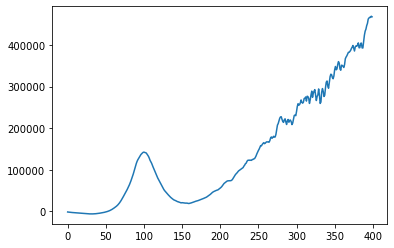

6
Epoch 0/400
5/5 [==============================] - trainLoss: 50.3125  Val_loss: 85.9674 
Epoch 1/400
5/5 [==============================] - trainLoss: 48.3890  Val_loss: -195.6312 
Epoch 2/400
5/5 [==============================] - trainLoss: 44.5730  Val_loss: -490.6147 
Epoch 3/400
5/5 [==============================] - trainLoss: 45.4832  Val_loss: -787.3917 
Epoch 4/400
5/5 [==============================] - trainLoss: 39.9338  Val_loss: -1093.0491 
Epoch 5/400
5/5 [==============================] - trainLoss: 39.4319  Val_loss: -1395.3583 
Epoch 6/400
5/5 [==============================] - trainLoss: 36.9403  Val_loss: -1700.2975 
Epoch 7/400
5/5 [==============================] - trainLoss: 34.4789  Val_loss: -2007.9338 
Epoch 8/400
5/5 [==============================] - trainLoss: 32.0554  Val_loss: -2290.8435 
Epoch 9/400
5/5 [==============================] - trainLoss: 29.7153  Val_loss: -2576.9836 
Epoch 10/400
5/5 [==============================] - trainLoss: 28.9615  Va

5/5 [==============================] - trainLoss: -4.4449  Val_loss: -6494.9834 
Epoch 25/400
5/5 [==============================] - trainLoss: -8.2451  Val_loss: -6712.8311 
Epoch 26/400
5/5 [==============================] - trainLoss: -11.6196  Val_loss: -6926.1191 
Epoch 27/400
5/5 [==============================] - trainLoss: -12.0795  Val_loss: -7140.2661 
Epoch 28/400
5/5 [==============================] - trainLoss: -13.7668  Val_loss: -7346.9883 
Epoch 29/400
5/5 [==============================] - trainLoss: -11.9452  Val_loss: -7540.5591 
Epoch 30/400
5/5 [==============================] - trainLoss: -16.2316  Val_loss: -7724.4004 
Epoch 31/400
5/5 [==============================] - trainLoss: -21.7248  Val_loss: -7894.1880 
Epoch 32/400
5/5 [==============================] - trainLoss: -28.0336  Val_loss: -8055.6743 
Epoch 33/400
5/5 [==============================] - trainLoss: -29.1118  Val_loss: -8215.3506 
Epoch 34/400
5/5 [==============================] - trainLoss: -2

5/5 [==============================] - trainLoss: -427.9400  Val_loss: -9307.2764 
Epoch 152/400
5/5 [==============================] - trainLoss: -424.7377  Val_loss: -9772.8242 
Epoch 153/400
5/5 [==============================] - trainLoss: -433.0315  Val_loss: -10154.2734 
Epoch 154/400
5/5 [==============================] - trainLoss: -428.4279  Val_loss: -10619.0674 
Epoch 155/400
5/5 [==============================] - trainLoss: -425.1674  Val_loss: -11090.4570 
Epoch 156/400
5/5 [==============================] - trainLoss: -430.1805  Val_loss: -11510.2510 
Epoch 157/400
5/5 [==============================] - trainLoss: -439.2665  Val_loss: -11792.9258 
Epoch 158/400
5/5 [==============================] - trainLoss: -421.3471  Val_loss: -11857.2295 
Epoch 159/400
5/5 [==============================] - trainLoss: -439.8566  Val_loss: -11797.0879 
Epoch 160/400
5/5 [==============================] - trainLoss: -440.7616  Val_loss: -11828.9141 
Epoch 161/400
5/5 [=================

5/5 [==============================] - trainLoss: -468.9631  Val_loss: 17930.0254 
Epoch 269/400
5/5 [==============================] - trainLoss: -464.0748  Val_loss: 17881.9531 
Epoch 270/400
5/5 [==============================] - trainLoss: -465.3224  Val_loss: 19010.3535 
Epoch 271/400
5/5 [==============================] - trainLoss: -461.9247  Val_loss: 19476.7363 
Epoch 272/400
5/5 [==============================] - trainLoss: -461.6151  Val_loss: 19024.7637 
Epoch 273/400
5/5 [==============================] - trainLoss: -468.0662  Val_loss: 18691.9219 
Epoch 274/400
5/5 [==============================] - trainLoss: -481.3906  Val_loss: 18267.6289 
Epoch 275/400
5/5 [==============================] - trainLoss: -454.1985  Val_loss: 19708.0547 
Epoch 276/400
5/5 [==============================] - trainLoss: -467.1187  Val_loss: 21749.7109 
Epoch 277/400
5/5 [==============================] - trainLoss: -466.3889  Val_loss: 22500.0059 
Epoch 278/400
5/5 [=========================

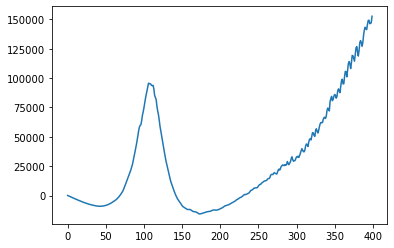

7
Epoch 0/400
5/5 [==============================] - trainLoss: 49.6209  Val_loss: 1883.9291 
Epoch 1/400
5/5 [==============================] - trainLoss: 54.1944  Val_loss: 1527.4733 
Epoch 2/400
5/5 [==============================] - trainLoss: 47.7636  Val_loss: 1171.0944 
Epoch 3/400
5/5 [==============================] - trainLoss: 45.4035  Val_loss: 817.9312 
Epoch 4/400
5/5 [==============================] - trainLoss: 49.6566  Val_loss: 459.8347 
Epoch 5/400
5/5 [==============================] - trainLoss: 39.2687  Val_loss: 109.5070 
Epoch 6/400
5/5 [==============================] - trainLoss: 36.0198  Val_loss: -230.2924 
Epoch 7/400
5/5 [==============================] - trainLoss: 38.8074  Val_loss: -567.5444 
Epoch 8/400
5/5 [==============================] - trainLoss: 35.0511  Val_loss: -901.4579 
Epoch 9/400
5/5 [==============================] - trainLoss: 27.7665  Val_loss: -1225.2701 
Epoch 10/400
5/5 [==============================] - trainLoss: 32.0140  Val_loss

5/5 [==============================] - trainLoss: -10.1708  Val_loss: -5175.8433 
Epoch 25/400
5/5 [==============================] - trainLoss: -13.6828  Val_loss: -5369.5933 
Epoch 26/400
5/5 [==============================] - trainLoss: -13.5333  Val_loss: -5554.2788 
Epoch 27/400
5/5 [==============================] - trainLoss: -19.5302  Val_loss: -5735.5688 
Epoch 28/400
5/5 [==============================] - trainLoss: -18.8679  Val_loss: -5904.2686 
Epoch 29/400
5/5 [==============================] - trainLoss: -19.6645  Val_loss: -6060.5122 
Epoch 30/400
5/5 [==============================] - trainLoss: -26.6663  Val_loss: -6200.8711 
Epoch 31/400
5/5 [==============================] - trainLoss: -31.3627  Val_loss: -6322.4233 
Epoch 32/400
5/5 [==============================] - trainLoss: -38.5333  Val_loss: -6433.3691 
Epoch 33/400
5/5 [==============================] - trainLoss: -38.9560  Val_loss: -6531.0117 
Epoch 34/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -418.2601  Val_loss: -9919.4424 
Epoch 154/400
5/5 [==============================] - trainLoss: -429.8103  Val_loss: -10599.0469 
Epoch 155/400
5/5 [==============================] - trainLoss: -426.1864  Val_loss: -11308.7109 
Epoch 156/400
5/5 [==============================] - trainLoss: -435.4775  Val_loss: -11938.6924 
Epoch 157/400
5/5 [==============================] - trainLoss: -434.7322  Val_loss: -12483.3320 
Epoch 158/400
5/5 [==============================] - trainLoss: -432.8855  Val_loss: -13024.1182 
Epoch 159/400
5/5 [==============================] - trainLoss: -441.5195  Val_loss: -13591.9121 
Epoch 160/400
5/5 [==============================] - trainLoss: -435.6896  Val_loss: -14192.8086 
Epoch 161/400
5/5 [==============================] - trainLoss: -440.2510  Val_loss: -14728.4824 
Epoch 162/400
5/5 [==============================] - trainLoss: -426.4347  Val_loss: -15170.5430 
Epoch 163/400
5/5 [================

5/5 [==============================] - trainLoss: -463.9277  Val_loss: 24507.2500 
Epoch 271/400
5/5 [==============================] - trainLoss: -469.0574  Val_loss: 24987.9746 
Epoch 272/400
5/5 [==============================] - trainLoss: -465.0645  Val_loss: 25431.5195 
Epoch 273/400
5/5 [==============================] - trainLoss: -468.4747  Val_loss: 25795.1562 
Epoch 274/400
5/5 [==============================] - trainLoss: -459.7550  Val_loss: 26373.2832 
Epoch 275/400
5/5 [==============================] - trainLoss: -468.9347  Val_loss: 26734.1191 
Epoch 276/400
5/5 [==============================] - trainLoss: -478.8839  Val_loss: 27262.0391 
Epoch 277/400
5/5 [==============================] - trainLoss: -474.8486  Val_loss: 27909.8730 
Epoch 278/400
5/5 [==============================] - trainLoss: -461.6216  Val_loss: 28457.2734 
Epoch 279/400
5/5 [==============================] - trainLoss: -472.5615  Val_loss: 27924.3477 
Epoch 280/400
5/5 [=========================

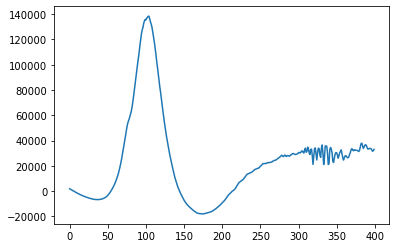

8
Epoch 0/400
5/5 [==============================] - trainLoss: 26.1958  Val_loss: -1744.1948 
Epoch 1/400
5/5 [==============================] - trainLoss: 20.9029  Val_loss: -2010.9780 
Epoch 2/400
5/5 [==============================] - trainLoss: 17.5754  Val_loss: -2267.5576 
Epoch 3/400
5/5 [==============================] - trainLoss: 14.8770  Val_loss: -2508.5134 
Epoch 4/400
5/5 [==============================] - trainLoss: 10.1125  Val_loss: -2750.9761 
Epoch 5/400
5/5 [==============================] - trainLoss: 13.5746  Val_loss: -2970.4763 
Epoch 6/400
5/5 [==============================] - trainLoss: 4.2807  Val_loss: -3188.1238 
Epoch 7/400
5/5 [==============================] - trainLoss: 7.0573  Val_loss: -3375.2874 
Epoch 8/400
5/5 [==============================] - trainLoss: 2.1986  Val_loss: -3557.1260 
Epoch 9/400
5/5 [==============================] - trainLoss: -3.7985  Val_loss: -3714.6414 
Epoch 10/400
5/5 [==============================] - trainLoss: -3.2262 

5/5 [==============================] - trainLoss: -79.0512  Val_loss: -794.6497 
Epoch 38/400
5/5 [==============================] - trainLoss: -76.8301  Val_loss: -233.3408 
Epoch 39/400
5/5 [==============================] - trainLoss: -87.0533  Val_loss: 393.6079 
Epoch 40/400
5/5 [==============================] - trainLoss: -85.7914  Val_loss: 1088.8174 
Epoch 41/400
5/5 [==============================] - trainLoss: -95.0753  Val_loss: 1789.2600 
Epoch 42/400
5/5 [==============================] - trainLoss: -94.1736  Val_loss: 2513.5930 
Epoch 43/400
5/5 [==============================] - trainLoss: -100.1978  Val_loss: 3301.4709 
Epoch 44/400
5/5 [==============================] - trainLoss: -103.1229  Val_loss: 4197.0293 
Epoch 45/400
5/5 [==============================] - trainLoss: -108.8686  Val_loss: 5176.9917 
Epoch 46/400
5/5 [==============================] - trainLoss: -104.2610  Val_loss: 6251.2378 
Epoch 47/400
5/5 [==============================] - trainLoss: -118.71

5/5 [==============================] - trainLoss: -399.5310  Val_loss: 136504.2500 
Epoch 123/400
5/5 [==============================] - trainLoss: -404.8382  Val_loss: 130138.3125 
Epoch 124/400
5/5 [==============================] - trainLoss: -407.5651  Val_loss: 121869.6953 
Epoch 125/400
5/5 [==============================] - trainLoss: -402.6688  Val_loss: 113799.1719 
Epoch 126/400
5/5 [==============================] - trainLoss: -419.1713  Val_loss: 108777.6016 
Epoch 127/400
5/5 [==============================] - trainLoss: -408.9075  Val_loss: 104131.1953 
Epoch 128/400
5/5 [==============================] - trainLoss: -413.3828  Val_loss: 99396.4375 
Epoch 129/400
5/5 [==============================] - trainLoss: -423.2635  Val_loss: 94369.1641 
Epoch 130/400
5/5 [==============================] - trainLoss: -410.6143  Val_loss: 88808.9688 
Epoch 131/400
5/5 [==============================] - trainLoss: -421.7602  Val_loss: 84228.1094 
Epoch 132/400
5/5 [===================

5/5 [==============================] - trainLoss: -469.6111  Val_loss: 205448.4062 
Epoch 291/400
5/5 [==============================] - trainLoss: -476.8472  Val_loss: 204033.8750 
Epoch 292/400
5/5 [==============================] - trainLoss: -480.7075  Val_loss: 207068.4844 
Epoch 293/400
5/5 [==============================] - trainLoss: -476.9930  Val_loss: 216415.6250 
Epoch 294/400
5/5 [==============================] - trainLoss: -471.5042  Val_loss: 219506.8906 
Epoch 295/400
5/5 [==============================] - trainLoss: -469.6679  Val_loss: 224220.1094 
Epoch 296/400
5/5 [==============================] - trainLoss: -483.0201  Val_loss: 226888.0469 
Epoch 297/400
5/5 [==============================] - trainLoss: -475.9193  Val_loss: 226980.6562 
Epoch 298/400
5/5 [==============================] - trainLoss: -475.7908  Val_loss: 230211.6875 
Epoch 299/400
5/5 [==============================] - trainLoss: -467.3932  Val_loss: 233765.5938 
Epoch 300/400
5/5 [===============

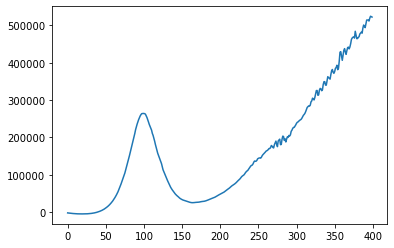

9
Epoch 0/400
5/5 [==============================] - trainLoss: 33.8725  Val_loss: -2812.7417 
Epoch 1/400
5/5 [==============================] - trainLoss: 24.5058  Val_loss: -3167.8440 
Epoch 2/400
5/5 [==============================] - trainLoss: 27.4450  Val_loss: -3489.2227 
Epoch 3/400
5/5 [==============================] - trainLoss: 25.9874  Val_loss: -3788.3064 
Epoch 4/400
5/5 [==============================] - trainLoss: 26.0992  Val_loss: -4057.2007 
Epoch 5/400
5/5 [==============================] - trainLoss: 18.3352  Val_loss: -4317.7290 
Epoch 6/400
5/5 [==============================] - trainLoss: 13.5154  Val_loss: -4562.5908 
Epoch 7/400
5/5 [==============================] - trainLoss: 16.7088  Val_loss: -4794.3857 
Epoch 8/400
5/5 [==============================] - trainLoss: 15.8897  Val_loss: -5009.4819 
Epoch 9/400
5/5 [==============================] - trainLoss: 5.3991  Val_loss: -5210.3530 
Epoch 10/400
5/5 [==============================] - trainLoss: 11.008

5/5 [==============================] - trainLoss: -17.3533  Val_loss: -7016.6597 
Epoch 25/400
5/5 [==============================] - trainLoss: -27.5195  Val_loss: -7086.2393 
Epoch 26/400
5/5 [==============================] - trainLoss: -27.0990  Val_loss: -7150.4087 
Epoch 27/400
5/5 [==============================] - trainLoss: -29.7963  Val_loss: -7215.8848 
Epoch 28/400
5/5 [==============================] - trainLoss: -33.2361  Val_loss: -7283.2583 
Epoch 29/400
5/5 [==============================] - trainLoss: -31.4252  Val_loss: -7348.4854 
Epoch 30/400
5/5 [==============================] - trainLoss: -33.0996  Val_loss: -7404.0640 
Epoch 31/400
5/5 [==============================] - trainLoss: -32.8210  Val_loss: -7449.9902 
Epoch 32/400
5/5 [==============================] - trainLoss: -39.7285  Val_loss: -7497.0171 
Epoch 33/400
5/5 [==============================] - trainLoss: -40.9847  Val_loss: -7540.0454 
Epoch 34/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -440.4583  Val_loss: -20058.3887 
Epoch 135/400
5/5 [==============================] - trainLoss: -427.9426  Val_loss: -20656.0059 
Epoch 136/400
5/5 [==============================] - trainLoss: -427.6898  Val_loss: -21153.3477 
Epoch 137/400
5/5 [==============================] - trainLoss: -417.3286  Val_loss: -21510.3887 
Epoch 138/400
5/5 [==============================] - trainLoss: -427.7798  Val_loss: -21801.2246 
Epoch 139/400
5/5 [==============================] - trainLoss: -430.0988  Val_loss: -22060.1309 
Epoch 140/400
5/5 [==============================] - trainLoss: -430.2198  Val_loss: -22300.0195 
Epoch 141/400
5/5 [==============================] - trainLoss: -430.3469  Val_loss: -22526.0996 
Epoch 142/400
5/5 [==============================] - trainLoss: -438.1989  Val_loss: -22763.9414 
Epoch 143/400
5/5 [==============================] - trainLoss: -424.3497  Val_loss: -22949.8145 
Epoch 144/400
5/5 [===============

5/5 [==============================] - trainLoss: -465.5435  Val_loss: 211106.7188 
Epoch 269/400
5/5 [==============================] - trainLoss: -467.2254  Val_loss: 220488.9531 
Epoch 270/400
5/5 [==============================] - trainLoss: -467.2463  Val_loss: 226614.8438 
Epoch 271/400
5/5 [==============================] - trainLoss: -466.1587  Val_loss: 227032.3906 
Epoch 272/400
5/5 [==============================] - trainLoss: -476.0657  Val_loss: 225691.1250 
Epoch 273/400
5/5 [==============================] - trainLoss: -470.0081  Val_loss: 233096.4531 
Epoch 274/400
5/5 [==============================] - trainLoss: -471.6786  Val_loss: 236853.4219 
Epoch 275/400
5/5 [==============================] - trainLoss: -471.4569  Val_loss: 234355.2031 
Epoch 276/400
5/5 [==============================] - trainLoss: -465.0188  Val_loss: 243652.6875 
Epoch 277/400
5/5 [==============================] - trainLoss: -461.4126  Val_loss: 250875.0469 
Epoch 278/400
5/5 [===============

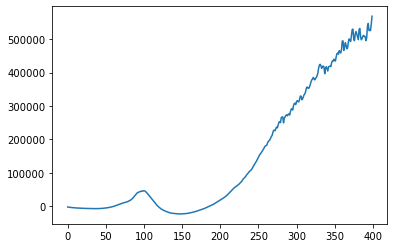

10
Epoch 0/400
5/5 [==============================] - trainLoss: 34.4394  Val_loss: -2850.7031 
Epoch 1/400
5/5 [==============================] - trainLoss: 39.7840  Val_loss: -3137.3604 
Epoch 2/400
5/5 [==============================] - trainLoss: 30.0472  Val_loss: -3419.8950 
Epoch 3/400
5/5 [==============================] - trainLoss: 26.7526  Val_loss: -3694.2581 
Epoch 4/400
5/5 [==============================] - trainLoss: 26.0490  Val_loss: -3969.0801 
Epoch 5/400
5/5 [==============================] - trainLoss: 21.1883  Val_loss: -4225.6914 
Epoch 6/400
5/5 [==============================] - trainLoss: 22.8224  Val_loss: -4478.1895 
Epoch 7/400
5/5 [==============================] - trainLoss: 20.9483  Val_loss: -4714.8306 
Epoch 8/400
5/5 [==============================] - trainLoss: 18.2072  Val_loss: -4939.0928 
Epoch 9/400
5/5 [==============================] - trainLoss: 15.3821  Val_loss: -5155.9126 
Epoch 10/400
5/5 [==============================] - trainLoss: 13.4

5/5 [==============================] - trainLoss: -17.2811  Val_loss: -7515.6582 
Epoch 25/400
5/5 [==============================] - trainLoss: -20.6444  Val_loss: -7659.6914 
Epoch 26/400
5/5 [==============================] - trainLoss: -21.1376  Val_loss: -7808.4258 
Epoch 27/400
5/5 [==============================] - trainLoss: -24.0669  Val_loss: -7958.8462 
Epoch 28/400
5/5 [==============================] - trainLoss: -24.9089  Val_loss: -8109.9580 
Epoch 29/400
5/5 [==============================] - trainLoss: -28.3568  Val_loss: -8269.7676 
Epoch 30/400
5/5 [==============================] - trainLoss: -29.0956  Val_loss: -8435.8408 
Epoch 31/400
5/5 [==============================] - trainLoss: -31.3751  Val_loss: -8604.3506 
Epoch 32/400
5/5 [==============================] - trainLoss: -34.1291  Val_loss: -8773.0146 
Epoch 33/400
5/5 [==============================] - trainLoss: -37.6447  Val_loss: -8951.4551 
Epoch 34/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -70.1583  Val_loss: -11813.0908 
Epoch 50/400
5/5 [==============================] - trainLoss: -72.7988  Val_loss: -11980.0361 
Epoch 51/400
5/5 [==============================] - trainLoss: -73.3251  Val_loss: -12120.9766 
Epoch 52/400
5/5 [==============================] - trainLoss: -76.7206  Val_loss: -12263.1992 
Epoch 53/400
5/5 [==============================] - trainLoss: -77.3171  Val_loss: -12394.8838 
Epoch 54/400
5/5 [==============================] - trainLoss: -80.4141  Val_loss: -12534.5371 
Epoch 55/400
5/5 [==============================] - trainLoss: -82.8002  Val_loss: -12656.6885 
Epoch 56/400
5/5 [==============================] - trainLoss: -87.3867  Val_loss: -12767.6973 
Epoch 57/400
5/5 [==============================] - trainLoss: -90.3798  Val_loss: -12859.7383 
Epoch 58/400
5/5 [==============================] - trainLoss: -90.5880  Val_loss: -12960.5762 
Epoch 59/400
5/5 [==============================] - t

5/5 [==============================] - trainLoss: -357.8249  Val_loss: -15099.8828 
Epoch 170/400
5/5 [==============================] - trainLoss: -360.1179  Val_loss: -15993.5889 
Epoch 171/400
5/5 [==============================] - trainLoss: -336.0443  Val_loss: -16858.8516 
Epoch 172/400
5/5 [==============================] - trainLoss: -340.3133  Val_loss: -17418.8750 
Epoch 173/400
5/5 [==============================] - trainLoss: -313.1873  Val_loss: -17864.0801 
Epoch 174/400
5/5 [==============================] - trainLoss: -335.7782  Val_loss: -18094.3320 
Epoch 175/400
5/5 [==============================] - trainLoss: -330.0409  Val_loss: -18463.5137 
Epoch 176/400
5/5 [==============================] - trainLoss: -349.0510  Val_loss: -19009.6055 
Epoch 177/400
5/5 [==============================] - trainLoss: -345.2146  Val_loss: -19593.3398 
Epoch 178/400
5/5 [==============================] - trainLoss: -352.6078  Val_loss: -20099.9531 
Epoch 179/400
5/5 [===============

5/5 [==============================] - trainLoss: -378.9804  Val_loss: -24681.6719 
Epoch 195/400
5/5 [==============================] - trainLoss: -373.4262  Val_loss: -25218.9863 
Epoch 196/400
5/5 [==============================] - trainLoss: -376.5146  Val_loss: -25561.3984 
Epoch 197/400
5/5 [==============================] - trainLoss: -381.7486  Val_loss: -25579.7773 
Epoch 198/400
5/5 [==============================] - trainLoss: -396.4216  Val_loss: -25660.1992 
Epoch 199/400
5/5 [==============================] - trainLoss: -387.8454  Val_loss: -25955.6250 
Epoch 200/400
5/5 [==============================] - trainLoss: -403.9437  Val_loss: -26344.6934 
Epoch 201/400
5/5 [==============================] - trainLoss: -383.9774  Val_loss: -26727.5918 
Epoch 202/400
5/5 [==============================] - trainLoss: -396.0779  Val_loss: -27021.8926 
Epoch 203/400
5/5 [==============================] - trainLoss: -398.4499  Val_loss: -27275.0410 
Epoch 204/400
5/5 [===============

5/5 [==============================] - trainLoss: -466.4794  Val_loss: 14086.7539 
Epoch 310/400
5/5 [==============================] - trainLoss: -469.2544  Val_loss: 12632.3672 
Epoch 311/400
5/5 [==============================] - trainLoss: -469.8369  Val_loss: 13339.2217 
Epoch 312/400
5/5 [==============================] - trainLoss: -467.0013  Val_loss: 14257.8340 
Epoch 313/400
5/5 [==============================] - trainLoss: -465.9712  Val_loss: 14951.9844 
Epoch 314/400
5/5 [==============================] - trainLoss: -459.5582  Val_loss: 16196.7256 
Epoch 315/400
5/5 [==============================] - trainLoss: -463.1240  Val_loss: 16526.6699 
Epoch 316/400
5/5 [==============================] - trainLoss: -461.1552  Val_loss: 15391.9922 
Epoch 317/400
5/5 [==============================] - trainLoss: -471.0636  Val_loss: 15419.1738 
Epoch 318/400
5/5 [==============================] - trainLoss: -463.2037  Val_loss: 17069.9297 
Epoch 319/400
5/5 [=========================

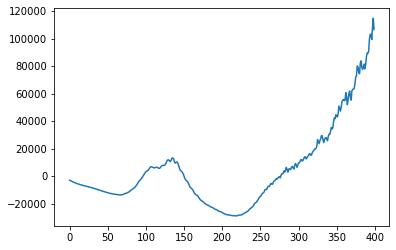

11
Epoch 0/400
5/5 [==============================] - trainLoss: 33.6472  Val_loss: -1648.3838 
Epoch 1/400
5/5 [==============================] - trainLoss: 30.8650  Val_loss: -1802.6010 
Epoch 2/400
5/5 [==============================] - trainLoss: 27.4430  Val_loss: -1944.6458 
Epoch 3/400
5/5 [==============================] - trainLoss: 27.9896  Val_loss: -2076.4717 
Epoch 4/400
5/5 [==============================] - trainLoss: 24.3431  Val_loss: -2199.5115 
Epoch 5/400
5/5 [==============================] - trainLoss: 20.3665  Val_loss: -2311.3049 
Epoch 6/400
5/5 [==============================] - trainLoss: 13.8737  Val_loss: -2413.2830 
Epoch 7/400
5/5 [==============================] - trainLoss: 17.9989  Val_loss: -2497.2932 
Epoch 8/400
5/5 [==============================] - trainLoss: 11.0267  Val_loss: -2566.4460 
Epoch 9/400
5/5 [==============================] - trainLoss: 6.7692  Val_loss: -2619.7009 
Epoch 10/400
5/5 [==============================] - trainLoss: 7.322

5/5 [==============================] - trainLoss: -123.1381  Val_loss: 27039.8184 
Epoch 53/400
5/5 [==============================] - trainLoss: -125.5030  Val_loss: 28936.0898 
Epoch 54/400
5/5 [==============================] - trainLoss: -132.4461  Val_loss: 30985.9902 
Epoch 55/400
5/5 [==============================] - trainLoss: -134.3108  Val_loss: 33260.1250 
Epoch 56/400
5/5 [==============================] - trainLoss: -124.8873  Val_loss: 35674.7422 
Epoch 57/400
5/5 [==============================] - trainLoss: -148.1374  Val_loss: 38263.4805 
Epoch 58/400
5/5 [==============================] - trainLoss: -143.4298  Val_loss: 41086.2891 
Epoch 59/400
5/5 [==============================] - trainLoss: -152.2082  Val_loss: 44198.3203 
Epoch 60/400
5/5 [==============================] - trainLoss: -147.1244  Val_loss: 47449.8359 
Epoch 61/400
5/5 [==============================] - trainLoss: -145.9598  Val_loss: 50715.1953 
Epoch 62/400
5/5 [==============================] - t

5/5 [==============================] - trainLoss: -463.4245  Val_loss: 120522.2891 
Epoch 221/400
5/5 [==============================] - trainLoss: -476.7576  Val_loss: 122990.2422 
Epoch 222/400
5/5 [==============================] - trainLoss: -469.1414  Val_loss: 125178.8438 
Epoch 223/400
5/5 [==============================] - trainLoss: -459.4918  Val_loss: 125242.6562 
Epoch 224/400
5/5 [==============================] - trainLoss: -460.9217  Val_loss: 124894.9766 
Epoch 225/400
5/5 [==============================] - trainLoss: -466.5513  Val_loss: 127741.2656 
Epoch 226/400
5/5 [==============================] - trainLoss: -456.7489  Val_loss: 130390.1094 
Epoch 227/400
5/5 [==============================] - trainLoss: -464.8542  Val_loss: 130449.3750 
Epoch 228/400
5/5 [==============================] - trainLoss: -462.3304  Val_loss: 129963.6719 
Epoch 229/400
5/5 [==============================] - trainLoss: -472.9055  Val_loss: 129853.6719 
Epoch 230/400
5/5 [===============

5/5 [==============================] - trainLoss: -482.2220  Val_loss: 335524.3750 
Epoch 387/400
5/5 [==============================] - trainLoss: -479.4670  Val_loss: 322350.9375 
Epoch 388/400
5/5 [==============================] - trainLoss: -480.5708  Val_loss: 324254.0938 
Epoch 389/400
5/5 [==============================] - trainLoss: -490.3316  Val_loss: 341470.7500 
Epoch 390/400
5/5 [==============================] - trainLoss: -474.6272  Val_loss: 338125.0312 
Epoch 391/400
5/5 [==============================] - trainLoss: -483.7631  Val_loss: 328124.0938 
Epoch 392/400
5/5 [==============================] - trainLoss: -482.1405  Val_loss: 345659.4375 
Epoch 393/400
5/5 [==============================] - trainLoss: -484.8812  Val_loss: 357872.9688 
Epoch 394/400
5/5 [==============================] - trainLoss: -479.7279  Val_loss: 361062.9688 
Epoch 395/400
5/5 [==============================] - trainLoss: -491.5471  Val_loss: 353830.9375 
Epoch 396/400
5/5 [===============

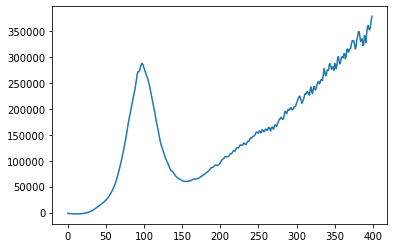

12
Epoch 0/400
5/5 [==============================] - trainLoss: 56.0571  Val_loss: 1678.0907 
Epoch 1/400
5/5 [==============================] - trainLoss: 49.0334  Val_loss: 1430.6741 
Epoch 2/400
5/5 [==============================] - trainLoss: 49.2402  Val_loss: 1182.5757 
Epoch 3/400
5/5 [==============================] - trainLoss: 51.9706  Val_loss: 921.3893 
Epoch 4/400
5/5 [==============================] - trainLoss: 46.2019  Val_loss: 661.8248 
Epoch 5/400
5/5 [==============================] - trainLoss: 47.8121  Val_loss: 395.3120 
Epoch 6/400
5/5 [==============================] - trainLoss: 42.1138  Val_loss: 142.9716 
Epoch 7/400
5/5 [==============================] - trainLoss: 44.0259  Val_loss: -115.8370 
Epoch 8/400
5/5 [==============================] - trainLoss: 38.0825  Val_loss: -372.2689 
Epoch 9/400
5/5 [==============================] - trainLoss: 29.5173  Val_loss: -601.5128 
Epoch 10/400
5/5 [==============================] - trainLoss: 34.4063  Val_loss:

5/5 [==============================] - trainLoss: 5.7861  Val_loss: -3382.8914 
Epoch 25/400
5/5 [==============================] - trainLoss: 1.1557  Val_loss: -3456.4983 
Epoch 26/400
5/5 [==============================] - trainLoss: -2.3021  Val_loss: -3507.4824 
Epoch 27/400
5/5 [==============================] - trainLoss: 1.0774  Val_loss: -3552.8301 
Epoch 28/400
5/5 [==============================] - trainLoss: -7.8360  Val_loss: -3568.6011 
Epoch 29/400
5/5 [==============================] - trainLoss: -8.9932  Val_loss: -3555.6389 
Epoch 30/400
5/5 [==============================] - trainLoss: -9.0782  Val_loss: -3531.9221 
Epoch 31/400
5/5 [==============================] - trainLoss: -9.0461  Val_loss: -3491.7749 
Epoch 32/400
5/5 [==============================] - trainLoss: -12.6641  Val_loss: -3429.6951 
Epoch 33/400
5/5 [==============================] - trainLoss: -24.2030  Val_loss: -3323.0554 
Epoch 34/400
5/5 [==============================] - trainLoss: -18.8902  V

5/5 [==============================] - trainLoss: -455.9962  Val_loss: 41337.9609 
Epoch 185/400
5/5 [==============================] - trainLoss: -442.3329  Val_loss: 41450.1797 
Epoch 186/400
5/5 [==============================] - trainLoss: -448.5367  Val_loss: 41775.0742 
Epoch 187/400
5/5 [==============================] - trainLoss: -446.5696  Val_loss: 42193.1055 
Epoch 188/400
5/5 [==============================] - trainLoss: -451.7315  Val_loss: 42870.4961 
Epoch 189/400
5/5 [==============================] - trainLoss: -449.8564  Val_loss: 43682.1953 
Epoch 190/400
5/5 [==============================] - trainLoss: -447.8283  Val_loss: 44026.5781 
Epoch 191/400
5/5 [==============================] - trainLoss: -445.8645  Val_loss: 44429.0508 
Epoch 192/400
5/5 [==============================] - trainLoss: -454.2676  Val_loss: 44651.2812 
Epoch 193/400
5/5 [==============================] - trainLoss: -448.0345  Val_loss: 45078.1328 
Epoch 194/400
5/5 [=========================

5/5 [==============================] - trainLoss: -484.6693  Val_loss: 499710.5625 
Epoch 352/400
5/5 [==============================] - trainLoss: -476.8141  Val_loss: 500842.6250 
Epoch 353/400
5/5 [==============================] - trainLoss: -470.3460  Val_loss: 502804.8438 
Epoch 354/400
5/5 [==============================] - trainLoss: -487.2237  Val_loss: 505440.8438 
Epoch 355/400
5/5 [==============================] - trainLoss: -472.4640  Val_loss: 509804.3125 
Epoch 356/400
5/5 [==============================] - trainLoss: -480.4415  Val_loss: 515773.7500 
Epoch 357/400
5/5 [==============================] - trainLoss: -474.9818  Val_loss: 522380.1562 
Epoch 358/400
5/5 [==============================] - trainLoss: -476.0051  Val_loss: 530467.5625 
Epoch 359/400
5/5 [==============================] - trainLoss: -475.4680  Val_loss: 539821.8750 
Epoch 360/400
5/5 [==============================] - trainLoss: -478.7167  Val_loss: 548792.0625 
Epoch 361/400
5/5 [===============

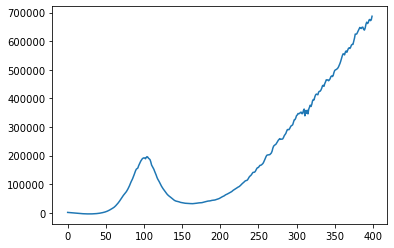

13
Epoch 0/400
5/5 [==============================] - trainLoss: 29.4754  Val_loss: -217.9027 
Epoch 1/400
5/5 [==============================] - trainLoss: 27.7929  Val_loss: -474.9440 
Epoch 2/400
5/5 [==============================] - trainLoss: 27.3553  Val_loss: -749.4882 
Epoch 3/400
5/5 [==============================] - trainLoss: 24.8680  Val_loss: -1036.5364 
Epoch 4/400
5/5 [==============================] - trainLoss: 17.5213  Val_loss: -1327.1986 
Epoch 5/400
5/5 [==============================] - trainLoss: 17.6882  Val_loss: -1619.0498 
Epoch 6/400
5/5 [==============================] - trainLoss: 16.2088  Val_loss: -1908.8322 
Epoch 7/400
5/5 [==============================] - trainLoss: 12.4164  Val_loss: -2194.1572 
Epoch 8/400
5/5 [==============================] - trainLoss: 6.3097  Val_loss: -2485.8613 
Epoch 9/400
5/5 [==============================] - trainLoss: 4.7069  Val_loss: -2774.6611 
Epoch 10/400
5/5 [==============================] - trainLoss: 2.6895  V

5/5 [==============================] - trainLoss: -25.6504  Val_loss: -6066.0063 
Epoch 25/400
5/5 [==============================] - trainLoss: -27.8041  Val_loss: -6157.3877 
Epoch 26/400
5/5 [==============================] - trainLoss: -30.2022  Val_loss: -6228.9966 
Epoch 27/400
5/5 [==============================] - trainLoss: -30.1091  Val_loss: -6297.9390 
Epoch 28/400
5/5 [==============================] - trainLoss: -34.5058  Val_loss: -6368.2251 
Epoch 29/400
5/5 [==============================] - trainLoss: -34.2774  Val_loss: -6438.1313 
Epoch 30/400
5/5 [==============================] - trainLoss: -36.5871  Val_loss: -6511.6587 
Epoch 31/400
5/5 [==============================] - trainLoss: -39.9769  Val_loss: -6578.8472 
Epoch 32/400
5/5 [==============================] - trainLoss: -41.1958  Val_loss: -6662.8872 
Epoch 33/400
5/5 [==============================] - trainLoss: -41.7912  Val_loss: -6741.0869 
Epoch 34/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -417.8459  Val_loss: -8996.4805 
Epoch 138/400
5/5 [==============================] - trainLoss: -423.4000  Val_loss: -10135.4326 
Epoch 139/400
5/5 [==============================] - trainLoss: -420.8462  Val_loss: -11123.7598 
Epoch 140/400
5/5 [==============================] - trainLoss: -420.2488  Val_loss: -12033.2666 
Epoch 141/400
5/5 [==============================] - trainLoss: -420.3709  Val_loss: -12895.2891 
Epoch 142/400
5/5 [==============================] - trainLoss: -422.2489  Val_loss: -13622.2373 
Epoch 143/400
5/5 [==============================] - trainLoss: -427.0190  Val_loss: -14069.0000 
Epoch 144/400
5/5 [==============================] - trainLoss: -427.0174  Val_loss: -14422.0029 
Epoch 145/400
5/5 [==============================] - trainLoss: -422.8280  Val_loss: -14843.0205 
Epoch 146/400
5/5 [==============================] - trainLoss: -425.4250  Val_loss: -15396.5469 
Epoch 147/400
5/5 [================

5/5 [==============================] - trainLoss: -459.7035  Val_loss: 95970.1562 
Epoch 267/400
5/5 [==============================] - trainLoss: -467.2061  Val_loss: 86749.6406 
Epoch 268/400
5/5 [==============================] - trainLoss: -476.5347  Val_loss: 82572.2422 
Epoch 269/400
5/5 [==============================] - trainLoss: -466.7277  Val_loss: 81288.4531 
Epoch 270/400
5/5 [==============================] - trainLoss: -463.5454  Val_loss: 84898.3125 
Epoch 271/400
5/5 [==============================] - trainLoss: -459.0740  Val_loss: 84977.7578 
Epoch 272/400
5/5 [==============================] - trainLoss: -460.5598  Val_loss: 83373.8672 
Epoch 273/400
5/5 [==============================] - trainLoss: -472.2841  Val_loss: 81936.0156 
Epoch 274/400
5/5 [==============================] - trainLoss: -469.4783  Val_loss: 79457.9297 
Epoch 275/400
5/5 [==============================] - trainLoss: -474.3662  Val_loss: 83028.7578 
Epoch 276/400
5/5 [=========================

5/5 [==============================] - trainLoss: -493.0715  Val_loss: 287449.2812 
Epoch 351/400
5/5 [==============================] - trainLoss: -482.3820  Val_loss: 287622.0000 
Epoch 352/400
5/5 [==============================] - trainLoss: -479.5745  Val_loss: 290777.8125 
Epoch 353/400
5/5 [==============================] - trainLoss: -480.3140  Val_loss: 294624.7812 
Epoch 354/400
5/5 [==============================] - trainLoss: -485.7430  Val_loss: 295219.7812 
Epoch 355/400
5/5 [==============================] - trainLoss: -478.1218  Val_loss: 286820.5000 
Epoch 356/400
5/5 [==============================] - trainLoss: -481.9340  Val_loss: 290208.4375 
Epoch 357/400
5/5 [==============================] - trainLoss: -474.0688  Val_loss: 287207.8125 
Epoch 358/400
5/5 [==============================] - trainLoss: -481.8995  Val_loss: 279304.7188 
Epoch 359/400
5/5 [==============================] - trainLoss: -492.5176  Val_loss: 281810.9688 
Epoch 360/400
5/5 [===============

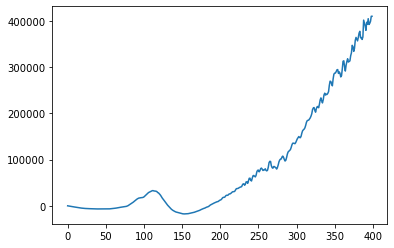

14
Epoch 0/400
5/5 [==============================] - trainLoss: 54.2744  Val_loss: 160.0514 
Epoch 1/400
5/5 [==============================] - trainLoss: 51.7372  Val_loss: -199.4930 
Epoch 2/400
5/5 [==============================] - trainLoss: 50.1863  Val_loss: -566.3437 
Epoch 3/400
5/5 [==============================] - trainLoss: 47.6987  Val_loss: -934.1172 
Epoch 4/400
5/5 [==============================] - trainLoss: 45.2822  Val_loss: -1300.5928 
Epoch 5/400
5/5 [==============================] - trainLoss: 41.2066  Val_loss: -1667.0931 
Epoch 6/400
5/5 [==============================] - trainLoss: 38.6847  Val_loss: -2036.2615 
Epoch 7/400
5/5 [==============================] - trainLoss: 33.4989  Val_loss: -2397.9055 
Epoch 8/400
5/5 [==============================] - trainLoss: 33.7422  Val_loss: -2758.0647 
Epoch 9/400
5/5 [==============================] - trainLoss: 30.9527  Val_loss: -3116.4155 
Epoch 10/400
5/5 [==============================] - trainLoss: 24.9105  

5/5 [==============================] - trainLoss: -12.9420  Val_loss: -7388.8662 
Epoch 25/400
5/5 [==============================] - trainLoss: -17.2071  Val_loss: -7621.5527 
Epoch 26/400
5/5 [==============================] - trainLoss: -20.3010  Val_loss: -7840.5210 
Epoch 27/400
5/5 [==============================] - trainLoss: -30.0092  Val_loss: -8048.9165 
Epoch 28/400
5/5 [==============================] - trainLoss: -26.0214  Val_loss: -8243.0537 
Epoch 29/400
5/5 [==============================] - trainLoss: -32.9390  Val_loss: -8419.2256 
Epoch 30/400
5/5 [==============================] - trainLoss: -32.2617  Val_loss: -8576.6104 
Epoch 31/400
5/5 [==============================] - trainLoss: -35.4845  Val_loss: -8727.5420 
Epoch 32/400
5/5 [==============================] - trainLoss: -36.5050  Val_loss: -8865.3428 
Epoch 33/400
5/5 [==============================] - trainLoss: -46.8608  Val_loss: -8978.6875 
Epoch 34/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -434.4132  Val_loss: 47849.6562 
Epoch 158/400
5/5 [==============================] - trainLoss: -444.9294  Val_loss: 47321.6797 
Epoch 159/400
5/5 [==============================] - trainLoss: -438.2784  Val_loss: 46657.5820 
Epoch 160/400
5/5 [==============================] - trainLoss: -432.9765  Val_loss: 46214.1445 
Epoch 161/400
5/5 [==============================] - trainLoss: -452.6870  Val_loss: 45866.5664 
Epoch 162/400
5/5 [==============================] - trainLoss: -425.7351  Val_loss: 46234.2656 
Epoch 163/400
5/5 [==============================] - trainLoss: -423.5283  Val_loss: 46532.2812 
Epoch 164/400
5/5 [==============================] - trainLoss: -432.6891  Val_loss: 46068.4727 
Epoch 165/400
5/5 [==============================] - trainLoss: -441.7463  Val_loss: 45513.3984 
Epoch 166/400
5/5 [==============================] - trainLoss: -446.4513  Val_loss: 45253.0000 
Epoch 167/400
5/5 [=========================

5/5 [==============================] - trainLoss: -488.0902  Val_loss: 440786.2500 
Epoch 325/400
5/5 [==============================] - trainLoss: -474.1833  Val_loss: 443084.9375 
Epoch 326/400
5/5 [==============================] - trainLoss: -476.6389  Val_loss: 446049.5625 
Epoch 327/400
5/5 [==============================] - trainLoss: -468.5279  Val_loss: 436231.4688 
Epoch 328/400
5/5 [==============================] - trainLoss: -477.7222  Val_loss: 441467.3125 
Epoch 329/400
5/5 [==============================] - trainLoss: -479.3147  Val_loss: 459814.3125 
Epoch 330/400
5/5 [==============================] - trainLoss: -479.7530  Val_loss: 467861.7812 
Epoch 331/400
5/5 [==============================] - trainLoss: -475.8496  Val_loss: 459810.9062 
Epoch 332/400
5/5 [==============================] - trainLoss: -480.4823  Val_loss: 436063.3438 
Epoch 333/400
5/5 [==============================] - trainLoss: -473.2354  Val_loss: 448401.9062 
Epoch 334/400
5/5 [===============

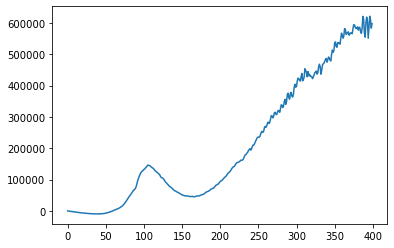

In [6]:
test_loglik_list = []
val_loglik_list = []

for i in range(15):
    
    print(i)

    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = keras.layers.GRU(hidden_state_size,return_sequences=True,return_state=True)(inputs=x_in,initial_state=hidden_state_in)

    hidden_model = keras.models.Model(inputs=[x_in,x_out,hidden_state_in],outputs=[output2,state])


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state= hidden_model([x_in,x_out,hidden_state_in])

    layer_hr = keras.layers.Dropout(0.3)(output2)
    layer_hr = keras.layers.Dense(64,activation="elu")(layer_hr)
    layer_hr = keras.layers.Dropout(0.3)(layer_hr)
    final_hr_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims_hr,bias_initializer='zeros'))(layer_hr) + hr_in
    sigma_mle_hr = (K.mean((final_hr_mean- hr_out)**2))**0.5

    loglik_hr = loglik_gaussian_hr(hr_out,final_hr_mean,sigma_mle_hr)

    nloglik_hr = loss(loglik_hr)

    rnn_training_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglik_hr])
    rnn_generate_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_hr_mean,sigma_mle_hr,state])


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = hidden_model([x_in,x_out,hidden_state_in],training=False)

    layer = keras.layers.Dropout(0.3)(output2)
    layer = keras.layers.Dense(64,activation="elu")(layer)
    layer = keras.layers.Dropout(0.3)(layer)
    final_x_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims,bias_initializer='zeros'))(layer) + x_in #this means we predict the residuals (better for learning)
    sigma_mle_x = (K.mean((final_x_mean- x_out)**2))**0.5


    loglik_x = loglik_gaussian_x(x_out,final_x_mean,sigma_mle_x)

    nloglikx = loss(loglik_x)

    rnn_training_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglikx])
    rnn_generate_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_x_mean,sigma_mle_x,state])

    @tf.function
    def train_step(inputs,model):
        """Decorated train_step function which applies a gradient update to the parameters"""
        with tf.GradientTape() as tape:
            loss = model(inputs,training=True)
            loss = tf.add_n([loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    optimizer=keras.optimizers.Adam(learning_rate=0.0003)

    def fit_model(input_list,epochs,model,simulator,history,validation_loss
                  ,valid_list,hr_toggle,index,batch_size=32):

        start = time.time()
        K.clear_session()

        batch_loss = []
        batches_per_epoch = int(np.ceil(input_list[0].shape[0]/batch_size))
        
        rnn_generate_x.save("no_tl_models/{}.h5".format(index))
        
        for epoch in range(epochs):
                print("Epoch {}/{}".format(epoch,epochs))
                for i in range(batches_per_epoch):
                    batch_list= create_batch(
                        input_list,batch_size)
                    loss = train_step(batch_list,model)
                    batch_loss.append(loss)
                    average_batch_loss = list_average(batch_loss)
                    print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

                training_loss_for_epoch = list_average(batch_loss)
                batch_loss = []
                history.append(training_loss_for_epoch)

                sigma_mle = simulator(input_list)[1]

                val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle,hr=hr_toggle)

                validation_loss.append(val_loss)
                if val_loss == min(validation_loss):
                    rnn_generate_x.save("no_tl_models/{}.h5".format(index))

                print_status_bar_epoch(input_list[0].shape[0]
                                 ,input_list[0].shape[0],training_loss_for_epoch,val_loss )

        done = time.time()
        elapsed = done-start
        
        plt.plot(validation_loss,label="validation")
        plt.show()
        
    training_losses = []
    validation_losses = []
    
    fit_model(input_list,400,rnn_training_x,rnn_generate_x,training_losses,validation_losses
              ,valid_list,hr_toggle=False,index=i,batch_size=32)
  

    rnn_generate_x = keras.models.load_model("no_tl_models/{}.h5".format(i))
    
    sigma_x = rnn_generate_x(input_list)[1]
    mean = rnn_generate_x(test_list)[0]
    loglik = np.mean(loglik_gaussian_x(test_nn_output,mean,sigma_x))

    test_loglik_list.append(loglik)
    
    mean = rnn_generate_x(valid_list)[0]
    loglik = np.mean(loglik_gaussian_x(valid_nn_output,mean,sigma_x))

    val_loglik_list.append(loglik)
    
a = np.array(test_loglik_list)
b = np.array(val_loglik_list)
array_loglik = np.stack([b,a],axis=1)
np.save("no_tl_models/loglik_array.npy",array_loglik)


In [7]:
array_loglik

array([[ 6.1956680e+03,  1.1927915e+06],
       [ 2.2687695e+03,  1.9294141e+05],
       [ 4.3025479e+03,  1.8221471e+06],
       [ 7.0743271e+03,  6.6966912e+05],
       [ 4.6198799e+03,  1.0997459e+06],
       [ 6.1552534e+03,  1.6493692e+06],
       [ 1.5622721e+04, -4.2539676e+07],
       [ 1.7983148e+04, -5.5524160e+07],
       [ 4.4403369e+03,  6.0822162e+05],
       [ 2.3452953e+04, -5.7496192e+07],
       [ 2.8787789e+04, -4.3018588e+07],
       [ 2.6836062e+03,  4.4158031e+05],
       [ 3.5686011e+03,  1.1398035e+06],
       [ 1.7767160e+04, -6.1743528e+07],
       [ 9.3129570e+03,  1.8329968e+06]], dtype=float32)

# TL

0


2022-09-12 14:42:53.831284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-12 14:42:54.504852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7408 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:3b:00.0, compute capability: 6.1


Epoch 0/20


2022-09-12 14:42:56.356800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-12 14:42:56.949703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


5/5 [==============================] - trainLoss: -12050.2900  Val_loss: -1529064.8750 
Epoch 1/20
5/5 [==============================] - trainLoss: -12369.2900  Val_loss: -1599416.5000 
Epoch 2/20
5/5 [==============================] - trainLoss: -12985.1035  Val_loss: -1665265.5000 
Epoch 3/20
5/5 [==============================] - trainLoss: -13482.0127  Val_loss: -1725769.1250 
Epoch 4/20
5/5 [==============================] - trainLoss: -13964.7637  Val_loss: -1777629.3750 
Epoch 5/20
5/5 [==============================] - trainLoss: -14415.6035  Val_loss: -1822875.0000 
Epoch 6/20
5/5 [==============================] - trainLoss: -14793.1582  Val_loss: -1861564.7500 
Epoch 7/20
5/5 [==============================] - trainLoss: -15117.6816  Val_loss: -1894084.2500 
Epoch 8/20
5/5 [==============================] - trainLoss: -15593.2676  Val_loss: -1918745.7500 
Epoch 9/20
5/5 [==============================] - trainLoss: -15865.5098  Val_loss: -1937720.0000 
Epoch 10/20
5/5 [====

5/5 [==============================] - trainLoss: -30.7943  Val_loss: -7080.8086 
Epoch 30/400
5/5 [==============================] - trainLoss: -37.8271  Val_loss: -7150.6587 
Epoch 31/400
5/5 [==============================] - trainLoss: -34.5309  Val_loss: -7218.6909 
Epoch 32/400
5/5 [==============================] - trainLoss: -34.7040  Val_loss: -7285.7202 
Epoch 33/400
5/5 [==============================] - trainLoss: -36.7794  Val_loss: -7347.2056 
Epoch 34/400
5/5 [==============================] - trainLoss: -38.8384  Val_loss: -7407.7090 
Epoch 35/400
5/5 [==============================] - trainLoss: -37.9727  Val_loss: -7467.5771 
Epoch 36/400
5/5 [==============================] - trainLoss: -37.4809  Val_loss: -7524.2559 
Epoch 37/400
5/5 [==============================] - trainLoss: -37.9853  Val_loss: -7578.7231 
Epoch 38/400
5/5 [==============================] - trainLoss: -42.9534  Val_loss: -7625.5806 
Epoch 39/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -58.8384  Val_loss: -7978.7944 
Epoch 55/400
5/5 [==============================] - trainLoss: -58.7296  Val_loss: -7992.4014 
Epoch 56/400
5/5 [==============================] - trainLoss: -65.7514  Val_loss: -7995.9043 
Epoch 57/400
5/5 [==============================] - trainLoss: -64.8962  Val_loss: -7994.9434 
Epoch 58/400
5/5 [==============================] - trainLoss: -60.5135  Val_loss: -7986.7397 
Epoch 59/400
5/5 [==============================] - trainLoss: -63.3758  Val_loss: -7966.8403 
Epoch 60/400
5/5 [==============================] - trainLoss: -62.0711  Val_loss: -7946.8979 
Epoch 61/400
5/5 [==============================] - trainLoss: -68.8091  Val_loss: -7924.4893 
Epoch 62/400
5/5 [==============================] - trainLoss: -71.7315  Val_loss: -7891.5210 
Epoch 63/400
5/5 [==============================] - trainLoss: -62.4736  Val_loss: -7861.8438 
Epoch 64/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -114.1819  Val_loss: -8602.8340 
Epoch 119/400
5/5 [==============================] - trainLoss: -115.9561  Val_loss: -8701.4902 
Epoch 120/400
5/5 [==============================] - trainLoss: -121.1522  Val_loss: -8789.6992 
Epoch 121/400
5/5 [==============================] - trainLoss: -119.4922  Val_loss: -8888.4824 
Epoch 122/400
5/5 [==============================] - trainLoss: -121.9604  Val_loss: -8981.0801 
Epoch 123/400
5/5 [==============================] - trainLoss: -120.7865  Val_loss: -9067.3350 
Epoch 124/400
5/5 [==============================] - trainLoss: -122.6766  Val_loss: -9160.1016 
Epoch 125/400
5/5 [==============================] - trainLoss: -125.3825  Val_loss: -9256.8008 
Epoch 126/400
5/5 [==============================] - trainLoss: -118.6677  Val_loss: -9360.0928 
Epoch 127/400
5/5 [==============================] - trainLoss: -123.0760  Val_loss: -9477.4492 
Epoch 128/400
5/5 [=========================

5/5 [==============================] - trainLoss: -134.2680  Val_loss: -11510.1660 
Epoch 144/400
5/5 [==============================] - trainLoss: -135.8163  Val_loss: -11670.0527 
Epoch 145/400
5/5 [==============================] - trainLoss: -144.5036  Val_loss: -11840.0586 
Epoch 146/400
5/5 [==============================] - trainLoss: -133.0369  Val_loss: -12036.1094 
Epoch 147/400
5/5 [==============================] - trainLoss: -135.1779  Val_loss: -12211.0459 
Epoch 148/400
5/5 [==============================] - trainLoss: -141.9693  Val_loss: -12377.2451 
Epoch 149/400
5/5 [==============================] - trainLoss: -139.2085  Val_loss: -12539.8301 
Epoch 150/400
5/5 [==============================] - trainLoss: -142.3689  Val_loss: -12713.5264 
Epoch 151/400
5/5 [==============================] - trainLoss: -139.8536  Val_loss: -12874.1172 
Epoch 152/400
5/5 [==============================] - trainLoss: -141.1663  Val_loss: -13036.3037 
Epoch 153/400
5/5 [===============

5/5 [==============================] - trainLoss: -156.4476  Val_loss: -15622.8701 
Epoch 169/400
5/5 [==============================] - trainLoss: -162.3814  Val_loss: -15830.9248 
Epoch 170/400
5/5 [==============================] - trainLoss: -154.5518  Val_loss: -16044.4199 
Epoch 171/400
5/5 [==============================] - trainLoss: -159.1364  Val_loss: -16257.0264 
Epoch 172/400
5/5 [==============================] - trainLoss: -156.8139  Val_loss: -16483.3496 
Epoch 173/400
5/5 [==============================] - trainLoss: -156.5298  Val_loss: -16721.5195 
Epoch 174/400
5/5 [==============================] - trainLoss: -156.7248  Val_loss: -16948.8711 
Epoch 175/400
5/5 [==============================] - trainLoss: -164.1751  Val_loss: -17195.6016 
Epoch 176/400
5/5 [==============================] - trainLoss: -162.3362  Val_loss: -17435.6035 
Epoch 177/400
5/5 [==============================] - trainLoss: -162.4561  Val_loss: -17675.0527 
Epoch 178/400
5/5 [===============

5/5 [==============================] - trainLoss: -176.9501  Val_loss: -22136.7422 
Epoch 194/400
5/5 [==============================] - trainLoss: -179.4042  Val_loss: -22384.6445 
Epoch 195/400
5/5 [==============================] - trainLoss: -175.6495  Val_loss: -22645.6309 
Epoch 196/400
5/5 [==============================] - trainLoss: -179.0368  Val_loss: -22913.8418 
Epoch 197/400
5/5 [==============================] - trainLoss: -177.2184  Val_loss: -23166.8262 
Epoch 198/400
5/5 [==============================] - trainLoss: -178.1337  Val_loss: -23426.8770 
Epoch 199/400
5/5 [==============================] - trainLoss: -187.1714  Val_loss: -23683.5898 
Epoch 200/400
5/5 [==============================] - trainLoss: -182.1675  Val_loss: -23957.1992 
Epoch 201/400
5/5 [==============================] - trainLoss: -184.4210  Val_loss: -24241.9277 
Epoch 202/400
5/5 [==============================] - trainLoss: -185.2374  Val_loss: -24543.8086 
Epoch 203/400
5/5 [===============

5/5 [==============================] - trainLoss: -195.7995  Val_loss: -28896.6094 
Epoch 219/400
5/5 [==============================] - trainLoss: -201.2103  Val_loss: -29132.6836 
Epoch 220/400
5/5 [==============================] - trainLoss: -198.1779  Val_loss: -29364.4727 
Epoch 221/400
5/5 [==============================] - trainLoss: -196.6963  Val_loss: -29583.5977 
Epoch 222/400
5/5 [==============================] - trainLoss: -201.0032  Val_loss: -29799.3418 
Epoch 223/400
5/5 [==============================] - trainLoss: -206.6175  Val_loss: -30024.7930 
Epoch 224/400
5/5 [==============================] - trainLoss: -209.1552  Val_loss: -30241.6309 
Epoch 225/400
5/5 [==============================] - trainLoss: -202.0457  Val_loss: -30440.1582 
Epoch 226/400
5/5 [==============================] - trainLoss: -201.9644  Val_loss: -30658.7578 
Epoch 227/400
5/5 [==============================] - trainLoss: -207.3205  Val_loss: -30838.8516 
Epoch 228/400
5/5 [===============

5/5 [==============================] - trainLoss: -220.5506  Val_loss: -33670.8203 
Epoch 244/400
5/5 [==============================] - trainLoss: -223.9567  Val_loss: -33852.2383 
Epoch 245/400
5/5 [==============================] - trainLoss: -225.2081  Val_loss: -34030.3945 
Epoch 246/400
5/5 [==============================] - trainLoss: -224.3293  Val_loss: -34209.0391 
Epoch 247/400
5/5 [==============================] - trainLoss: -231.0771  Val_loss: -34379.3594 
Epoch 248/400
5/5 [==============================] - trainLoss: -223.8111  Val_loss: -34549.8984 
Epoch 249/400
5/5 [==============================] - trainLoss: -228.4394  Val_loss: -34722.6367 
Epoch 250/400
5/5 [==============================] - trainLoss: -231.0866  Val_loss: -34871.4297 
Epoch 251/400
5/5 [==============================] - trainLoss: -233.5288  Val_loss: -35021.5039 
Epoch 252/400
5/5 [==============================] - trainLoss: -232.9094  Val_loss: -35184.4727 
Epoch 253/400
5/5 [===============

5/5 [==============================] - trainLoss: -246.0718  Val_loss: -37014.7891 
Epoch 269/400
5/5 [==============================] - trainLoss: -248.2389  Val_loss: -37087.2695 
Epoch 270/400
5/5 [==============================] - trainLoss: -246.8421  Val_loss: -37182.4688 
Epoch 271/400
5/5 [==============================] - trainLoss: -250.1433  Val_loss: -37292.1055 
Epoch 272/400
5/5 [==============================] - trainLoss: -252.2891  Val_loss: -37446.9453 
Epoch 273/400
5/5 [==============================] - trainLoss: -250.0188  Val_loss: -37609.5898 
Epoch 274/400
5/5 [==============================] - trainLoss: -246.0650  Val_loss: -37772.6562 
Epoch 275/400
5/5 [==============================] - trainLoss: -252.6590  Val_loss: -37894.8594 
Epoch 276/400
5/5 [==============================] - trainLoss: -254.6589  Val_loss: -38008.8164 
Epoch 277/400
5/5 [==============================] - trainLoss: -257.4960  Val_loss: -38116.1445 
Epoch 278/400
5/5 [===============

5/5 [==============================] - trainLoss: -276.0327  Val_loss: -40091.5508 
Epoch 294/400
5/5 [==============================] - trainLoss: -275.0114  Val_loss: -40279.7070 
Epoch 295/400
5/5 [==============================] - trainLoss: -274.6503  Val_loss: -40474.9883 
Epoch 296/400
5/5 [==============================] - trainLoss: -272.9128  Val_loss: -40658.6914 
Epoch 297/400
5/5 [==============================] - trainLoss: -274.7125  Val_loss: -40795.0781 
Epoch 298/400
5/5 [==============================] - trainLoss: -284.8838  Val_loss: -40896.1914 
Epoch 299/400
5/5 [==============================] - trainLoss: -280.7376  Val_loss: -40993.9453 
Epoch 300/400
5/5 [==============================] - trainLoss: -282.1734  Val_loss: -41068.9219 
Epoch 301/400
5/5 [==============================] - trainLoss: -284.1522  Val_loss: -41088.5547 
Epoch 302/400
5/5 [==============================] - trainLoss: -281.2810  Val_loss: -41086.5234 
Epoch 303/400
5/5 [===============

5/5 [==============================] - trainLoss: -408.2192  Val_loss: -41681.8750 
Epoch 394/400
5/5 [==============================] - trainLoss: -407.7945  Val_loss: -41840.4492 
Epoch 395/400
5/5 [==============================] - trainLoss: -411.8228  Val_loss: -41981.6719 
Epoch 396/400
5/5 [==============================] - trainLoss: -411.1639  Val_loss: -42116.4297 
Epoch 397/400
5/5 [==============================] - trainLoss: -413.8640  Val_loss: -42240.0000 
Epoch 398/400
5/5 [==============================] - trainLoss: -415.1626  Val_loss: -42436.4023 
Epoch 399/400
5/5 [==============================] - trainLoss: -413.4844  Val_loss: -42499.1250 


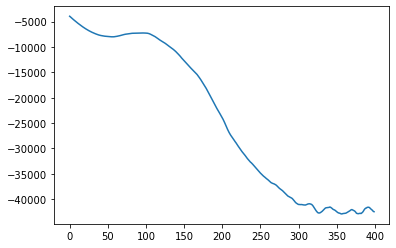

1
Epoch 0/20
5/5 [==============================] - trainLoss: -13400.0977  Val_loss: -1628358.7500 
Epoch 1/20
5/5 [==============================] - trainLoss: -13439.3398  Val_loss: -1686428.3750 
Epoch 2/20
5/5 [==============================] - trainLoss: -14210.0996  Val_loss: -1739252.1250 
Epoch 3/20
5/5 [==============================] - trainLoss: -14759.1914  Val_loss: -1785907.0000 
Epoch 4/20
5/5 [==============================] - trainLoss: -14868.9551  Val_loss: -1827033.0000 
Epoch 5/20
5/5 [==============================] - trainLoss: -15680.1367  Val_loss: -1861629.0000 
Epoch 6/20
5/5 [==============================] - trainLoss: -16242.7959  Val_loss: -1889658.0000 
Epoch 7/20
5/5 [==============================] - trainLoss: -16040.1406  Val_loss: -1911234.2500 
Epoch 8/20
5/5 [==============================] - trainLoss: -16416.5371  Val_loss: -1928611.0000 
Epoch 9/20
5/5 [==============================] - trainLoss: -16674.3770  Val_loss: -1942276.3750 
Epoch 10

5/5 [==============================] - trainLoss: -19.9539  Val_loss: -2912.9602 
Epoch 29/400
5/5 [==============================] - trainLoss: -8.6954  Val_loss: -2987.7778 
Epoch 30/400
5/5 [==============================] - trainLoss: -16.7087  Val_loss: -3058.1980 
Epoch 31/400
5/5 [==============================] - trainLoss: -19.5802  Val_loss: -3125.1938 
Epoch 32/400
5/5 [==============================] - trainLoss: -21.6971  Val_loss: -3185.8374 
Epoch 33/400
5/5 [==============================] - trainLoss: -20.0757  Val_loss: -3241.2273 
Epoch 34/400
5/5 [==============================] - trainLoss: -21.7134  Val_loss: -3292.8032 
Epoch 35/400
5/5 [==============================] - trainLoss: -25.2361  Val_loss: -3338.3408 
Epoch 36/400
5/5 [==============================] - trainLoss: -34.2164  Val_loss: -3377.5625 
Epoch 37/400
5/5 [==============================] - trainLoss: -19.7096  Val_loss: -3411.3750 
Epoch 38/400
5/5 [==============================] - trainLoss: -

5/5 [==============================] - trainLoss: -126.5239  Val_loss: -5084.3555 
Epoch 148/400
5/5 [==============================] - trainLoss: -117.7701  Val_loss: -5301.7456 
Epoch 149/400
5/5 [==============================] - trainLoss: -121.8285  Val_loss: -5516.6670 
Epoch 150/400
5/5 [==============================] - trainLoss: -119.9523  Val_loss: -5725.6543 
Epoch 151/400
5/5 [==============================] - trainLoss: -125.0717  Val_loss: -5945.2056 
Epoch 152/400
5/5 [==============================] - trainLoss: -118.4873  Val_loss: -6178.8164 
Epoch 153/400
5/5 [==============================] - trainLoss: -114.7621  Val_loss: -6423.7837 
Epoch 154/400
5/5 [==============================] - trainLoss: -120.6401  Val_loss: -6674.8354 
Epoch 155/400
5/5 [==============================] - trainLoss: -128.9635  Val_loss: -6918.6631 
Epoch 156/400
5/5 [==============================] - trainLoss: -129.3493  Val_loss: -7159.2500 
Epoch 157/400
5/5 [=========================

5/5 [==============================] - trainLoss: -138.5620  Val_loss: -10895.6445 
Epoch 173/400
5/5 [==============================] - trainLoss: -135.6515  Val_loss: -11150.6543 
Epoch 174/400
5/5 [==============================] - trainLoss: -138.5926  Val_loss: -11387.9375 
Epoch 175/400
5/5 [==============================] - trainLoss: -148.5217  Val_loss: -11602.8672 
Epoch 176/400
5/5 [==============================] - trainLoss: -143.0322  Val_loss: -11820.1973 
Epoch 177/400
5/5 [==============================] - trainLoss: -144.0467  Val_loss: -12023.3213 
Epoch 178/400
5/5 [==============================] - trainLoss: -135.3234  Val_loss: -12243.7549 
Epoch 179/400
5/5 [==============================] - trainLoss: -147.8542  Val_loss: -12449.9961 
Epoch 180/400
5/5 [==============================] - trainLoss: -141.9397  Val_loss: -12663.3623 
Epoch 181/400
5/5 [==============================] - trainLoss: -150.0689  Val_loss: -12875.9404 
Epoch 182/400
5/5 [===============

5/5 [==============================] - trainLoss: -154.2078  Val_loss: -15922.2461 
Epoch 197/400
5/5 [==============================] - trainLoss: -162.7928  Val_loss: -16127.1582 
Epoch 198/400
5/5 [==============================] - trainLoss: -171.7744  Val_loss: -16317.9160 
Epoch 199/400
5/5 [==============================] - trainLoss: -161.5471  Val_loss: -16517.5117 
Epoch 200/400
5/5 [==============================] - trainLoss: -168.9980  Val_loss: -16712.6094 
Epoch 201/400
5/5 [==============================] - trainLoss: -159.0461  Val_loss: -16931.5664 
Epoch 202/400
5/5 [==============================] - trainLoss: -165.2770  Val_loss: -17154.4199 
Epoch 203/400
5/5 [==============================] - trainLoss: -166.9766  Val_loss: -17362.6270 
Epoch 204/400
5/5 [==============================] - trainLoss: -157.8836  Val_loss: -17594.7266 
Epoch 205/400
5/5 [==============================] - trainLoss: -163.7823  Val_loss: -17826.3594 
Epoch 206/400
5/5 [===============

5/5 [==============================] - trainLoss: -182.8841  Val_loss: -21383.7285 
Epoch 222/400
5/5 [==============================] - trainLoss: -173.2101  Val_loss: -21651.6777 
Epoch 223/400
5/5 [==============================] - trainLoss: -184.1725  Val_loss: -21909.2695 
Epoch 224/400
5/5 [==============================] - trainLoss: -186.0057  Val_loss: -22168.6230 
Epoch 225/400
5/5 [==============================] - trainLoss: -182.6730  Val_loss: -22411.3770 
Epoch 226/400
5/5 [==============================] - trainLoss: -183.2787  Val_loss: -22643.7148 
Epoch 227/400
5/5 [==============================] - trainLoss: -176.9506  Val_loss: -22885.1016 
Epoch 228/400
5/5 [==============================] - trainLoss: -184.9979  Val_loss: -23125.6738 
Epoch 229/400
5/5 [==============================] - trainLoss: -187.4135  Val_loss: -23351.7637 
Epoch 230/400
5/5 [==============================] - trainLoss: -179.2359  Val_loss: -23601.7441 
Epoch 231/400
5/5 [===============

5/5 [==============================] - trainLoss: -202.8453  Val_loss: -27721.4102 
Epoch 247/400
5/5 [==============================] - trainLoss: -203.6539  Val_loss: -27923.3672 
Epoch 248/400
5/5 [==============================] - trainLoss: -208.8163  Val_loss: -28110.5566 
Epoch 249/400
5/5 [==============================] - trainLoss: -204.8414  Val_loss: -28281.2754 
Epoch 250/400
5/5 [==============================] - trainLoss: -197.1598  Val_loss: -28468.8828 
Epoch 251/400
5/5 [==============================] - trainLoss: -202.9665  Val_loss: -28643.4023 
Epoch 252/400
5/5 [==============================] - trainLoss: -197.1813  Val_loss: -28818.0469 
Epoch 253/400
5/5 [==============================] - trainLoss: -203.8762  Val_loss: -28996.7148 
Epoch 254/400
5/5 [==============================] - trainLoss: -205.6000  Val_loss: -29178.9023 
Epoch 255/400
5/5 [==============================] - trainLoss: -209.4034  Val_loss: -29358.3730 
Epoch 256/400
5/5 [===============

5/5 [==============================] - trainLoss: -223.3748  Val_loss: -32282.7520 
Epoch 272/400
5/5 [==============================] - trainLoss: -223.7691  Val_loss: -32409.9141 
Epoch 273/400
5/5 [==============================] - trainLoss: -219.8450  Val_loss: -32536.7246 
Epoch 274/400
5/5 [==============================] - trainLoss: -230.1899  Val_loss: -32646.0410 
Epoch 275/400
5/5 [==============================] - trainLoss: -222.2475  Val_loss: -32744.0098 
Epoch 276/400
5/5 [==============================] - trainLoss: -232.4815  Val_loss: -32791.4219 
Epoch 277/400
5/5 [==============================] - trainLoss: -221.5678  Val_loss: -32855.6875 
Epoch 278/400
5/5 [==============================] - trainLoss: -231.2181  Val_loss: -32924.2031 
Epoch 279/400
5/5 [==============================] - trainLoss: -226.8483  Val_loss: -33013.7461 
Epoch 280/400
5/5 [==============================] - trainLoss: -227.6744  Val_loss: -33095.0469 
Epoch 281/400
5/5 [===============

5/5 [==============================] - trainLoss: -246.2446  Val_loss: -34246.5547 
Epoch 297/400
5/5 [==============================] - trainLoss: -249.6672  Val_loss: -34331.0195 
Epoch 298/400
5/5 [==============================] - trainLoss: -249.0867  Val_loss: -34389.3203 
Epoch 299/400
5/5 [==============================] - trainLoss: -247.4652  Val_loss: -34448.6562 
Epoch 300/400
5/5 [==============================] - trainLoss: -253.7783  Val_loss: -34542.1367 
Epoch 301/400
5/5 [==============================] - trainLoss: -253.0309  Val_loss: -34641.6367 
Epoch 302/400
5/5 [==============================] - trainLoss: -252.6586  Val_loss: -34739.8867 
Epoch 303/400
5/5 [==============================] - trainLoss: -258.5321  Val_loss: -34834.4023 
Epoch 304/400
5/5 [==============================] - trainLoss: -256.8026  Val_loss: -34940.1719 
Epoch 305/400
5/5 [==============================] - trainLoss: -255.1995  Val_loss: -35053.3906 
Epoch 306/400
5/5 [===============

5/5 [==============================] - trainLoss: -269.5374  Val_loss: -36173.5625 
Epoch 322/400
5/5 [==============================] - trainLoss: -273.7335  Val_loss: -36190.1367 
Epoch 323/400
5/5 [==============================] - trainLoss: -276.6862  Val_loss: -36188.3359 
Epoch 324/400
5/5 [==============================] - trainLoss: -275.2332  Val_loss: -36161.4609 
Epoch 325/400
5/5 [==============================] - trainLoss: -280.0226  Val_loss: -36144.0352 
Epoch 326/400
5/5 [==============================] - trainLoss: -273.1270  Val_loss: -36169.2578 
Epoch 327/400
5/5 [==============================] - trainLoss: -287.7549  Val_loss: -36202.5352 
Epoch 328/400
5/5 [==============================] - trainLoss: -280.1789  Val_loss: -36229.8711 
Epoch 329/400
5/5 [==============================] - trainLoss: -284.4968  Val_loss: -36300.7969 
Epoch 330/400
5/5 [==============================] - trainLoss: -289.5125  Val_loss: -36360.1719 
Epoch 331/400
5/5 [===============

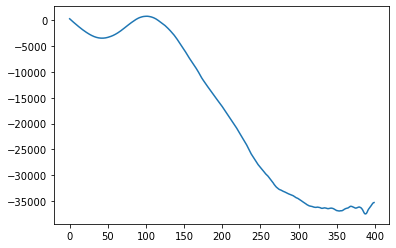

2
Epoch 0/20
5/5 [==============================] - trainLoss: -12346.0479  Val_loss: -1621637.7500 
Epoch 1/20
5/5 [==============================] - trainLoss: -12795.0156  Val_loss: -1664227.3750 
Epoch 2/20
5/5 [==============================] - trainLoss: -13170.5566  Val_loss: -1703075.0000 
Epoch 3/20
5/5 [==============================] - trainLoss: -13589.5410  Val_loss: -1738446.3750 
Epoch 4/20
5/5 [==============================] - trainLoss: -14047.5938  Val_loss: -1769294.8750 
Epoch 5/20
5/5 [==============================] - trainLoss: -14384.1211  Val_loss: -1795064.8750 
Epoch 6/20
5/5 [==============================] - trainLoss: -14821.3428  Val_loss: -1815177.2500 
Epoch 7/20
5/5 [==============================] - trainLoss: -15176.8037  Val_loss: -1828731.6250 
Epoch 8/20
5/5 [==============================] - trainLoss: -15443.8428  Val_loss: -1837244.1250 
Epoch 9/20
5/5 [==============================] - trainLoss: -15818.6973  Val_loss: -1841404.2500 
Epoch 10

5/5 [==============================] - trainLoss: 14.7220  Val_loss: -2945.8677 
Epoch 10/400
5/5 [==============================] - trainLoss: 12.5790  Val_loss: -3055.8159 
Epoch 11/400
5/5 [==============================] - trainLoss: 14.1478  Val_loss: -3164.3931 
Epoch 12/400
5/5 [==============================] - trainLoss: 13.0431  Val_loss: -3271.9915 
Epoch 13/400
5/5 [==============================] - trainLoss: 12.3383  Val_loss: -3379.2522 
Epoch 14/400
5/5 [==============================] - trainLoss: 8.3854  Val_loss: -3485.4795 
Epoch 15/400
5/5 [==============================] - trainLoss: 2.8494  Val_loss: -3590.6909 
Epoch 16/400
5/5 [==============================] - trainLoss: 7.9178  Val_loss: -3693.7976 
Epoch 17/400
5/5 [==============================] - trainLoss: 5.7081  Val_loss: -3795.4521 
Epoch 18/400
5/5 [==============================] - trainLoss: 5.9164  Val_loss: -3896.1104 
Epoch 19/400
5/5 [==============================] - trainLoss: 5.8251  Val_los

5/5 [==============================] - trainLoss: -35.9968  Val_loss: -6477.6118 
Epoch 60/400
5/5 [==============================] - trainLoss: -40.7995  Val_loss: -6485.9546 
Epoch 61/400
5/5 [==============================] - trainLoss: -38.2309  Val_loss: -6490.3203 
Epoch 62/400
5/5 [==============================] - trainLoss: -41.4573  Val_loss: -6495.0913 
Epoch 63/400
5/5 [==============================] - trainLoss: -42.2916  Val_loss: -6492.9189 
Epoch 64/400
5/5 [==============================] - trainLoss: -40.0014  Val_loss: -6480.6069 
Epoch 65/400
5/5 [==============================] - trainLoss: -43.0776  Val_loss: -6465.4849 
Epoch 66/400
5/5 [==============================] - trainLoss: -44.0304  Val_loss: -6444.8271 
Epoch 67/400
5/5 [==============================] - trainLoss: -46.8184  Val_loss: -6427.1313 
Epoch 68/400
5/5 [==============================] - trainLoss: -47.6240  Val_loss: -6405.6851 
Epoch 69/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -140.4298  Val_loss: -9860.3281 
Epoch 186/400
5/5 [==============================] - trainLoss: -141.6003  Val_loss: -10047.4268 
Epoch 187/400
5/5 [==============================] - trainLoss: -141.8410  Val_loss: -10250.9844 
Epoch 188/400
5/5 [==============================] - trainLoss: -143.5883  Val_loss: -10453.9551 
Epoch 189/400
5/5 [==============================] - trainLoss: -144.6671  Val_loss: -10661.3281 
Epoch 190/400
5/5 [==============================] - trainLoss: -143.9414  Val_loss: -10884.1904 
Epoch 191/400
5/5 [==============================] - trainLoss: -146.9622  Val_loss: -11105.1426 
Epoch 192/400
5/5 [==============================] - trainLoss: -146.9604  Val_loss: -11350.3359 
Epoch 193/400
5/5 [==============================] - trainLoss: -147.5696  Val_loss: -11593.5693 
Epoch 194/400
5/5 [==============================] - trainLoss: -150.5326  Val_loss: -11844.9541 
Epoch 195/400
5/5 [================

5/5 [==============================] - trainLoss: -161.5371  Val_loss: -16024.3496 
Epoch 211/400
5/5 [==============================] - trainLoss: -164.5467  Val_loss: -16336.8779 
Epoch 212/400
5/5 [==============================] - trainLoss: -164.1829  Val_loss: -16638.7520 
Epoch 213/400
5/5 [==============================] - trainLoss: -167.2792  Val_loss: -16931.6992 
Epoch 214/400
5/5 [==============================] - trainLoss: -163.9682  Val_loss: -17227.0352 
Epoch 215/400
5/5 [==============================] - trainLoss: -165.1142  Val_loss: -17529.6953 
Epoch 216/400
5/5 [==============================] - trainLoss: -165.6173  Val_loss: -17838.0020 
Epoch 217/400
5/5 [==============================] - trainLoss: -164.6489  Val_loss: -18172.9238 
Epoch 218/400
5/5 [==============================] - trainLoss: -170.3419  Val_loss: -18480.6055 
Epoch 219/400
5/5 [==============================] - trainLoss: -170.3190  Val_loss: -18790.4043 
Epoch 220/400
5/5 [===============

5/5 [==============================] - trainLoss: -181.7849  Val_loss: -22679.7695 
Epoch 236/400
5/5 [==============================] - trainLoss: -182.6569  Val_loss: -22930.1660 
Epoch 237/400
5/5 [==============================] - trainLoss: -185.7423  Val_loss: -23173.7559 
Epoch 238/400
5/5 [==============================] - trainLoss: -187.4596  Val_loss: -23389.8691 
Epoch 239/400
5/5 [==============================] - trainLoss: -187.6106  Val_loss: -23611.7422 
Epoch 240/400
5/5 [==============================] - trainLoss: -189.6005  Val_loss: -23834.7910 
Epoch 241/400
5/5 [==============================] - trainLoss: -189.9439  Val_loss: -24090.7090 
Epoch 242/400
5/5 [==============================] - trainLoss: -191.5269  Val_loss: -24316.1309 
Epoch 243/400
5/5 [==============================] - trainLoss: -189.5196  Val_loss: -24541.4512 
Epoch 244/400
5/5 [==============================] - trainLoss: -190.2370  Val_loss: -24776.0059 
Epoch 245/400
5/5 [===============

5/5 [==============================] - trainLoss: -208.3999  Val_loss: -29539.2676 
Epoch 261/400
5/5 [==============================] - trainLoss: -209.4705  Val_loss: -29803.7656 
Epoch 262/400
5/5 [==============================] - trainLoss: -210.5610  Val_loss: -30087.6934 
Epoch 263/400
5/5 [==============================] - trainLoss: -212.3380  Val_loss: -30347.1680 
Epoch 264/400
5/5 [==============================] - trainLoss: -214.2835  Val_loss: -30594.5312 
Epoch 265/400
5/5 [==============================] - trainLoss: -214.0786  Val_loss: -30821.2344 
Epoch 266/400
5/5 [==============================] - trainLoss: -215.9255  Val_loss: -31026.0996 
Epoch 267/400
5/5 [==============================] - trainLoss: -215.4214  Val_loss: -31208.4766 
Epoch 268/400
5/5 [==============================] - trainLoss: -220.6747  Val_loss: -31381.7246 
Epoch 269/400
5/5 [==============================] - trainLoss: -217.0860  Val_loss: -31560.8184 
Epoch 270/400
5/5 [===============

5/5 [==============================] - trainLoss: -235.4063  Val_loss: -34501.2812 
Epoch 286/400
5/5 [==============================] - trainLoss: -237.3276  Val_loss: -34714.3555 
Epoch 287/400
5/5 [==============================] - trainLoss: -236.4708  Val_loss: -34960.8867 
Epoch 288/400
5/5 [==============================] - trainLoss: -238.7106  Val_loss: -35189.9570 
Epoch 289/400
5/5 [==============================] - trainLoss: -239.3601  Val_loss: -35402.7930 
Epoch 290/400
5/5 [==============================] - trainLoss: -242.4353  Val_loss: -35586.4570 
Epoch 291/400
5/5 [==============================] - trainLoss: -242.0677  Val_loss: -35789.8438 
Epoch 292/400
5/5 [==============================] - trainLoss: -243.2263  Val_loss: -35987.7773 
Epoch 293/400
5/5 [==============================] - trainLoss: -244.7300  Val_loss: -36152.1719 
Epoch 294/400
5/5 [==============================] - trainLoss: -243.5722  Val_loss: -36353.2461 
Epoch 295/400
5/5 [===============

5/5 [==============================] - trainLoss: -265.7202  Val_loss: -38957.0273 
Epoch 311/400
5/5 [==============================] - trainLoss: -265.0114  Val_loss: -39195.7734 
Epoch 312/400
5/5 [==============================] - trainLoss: -268.5923  Val_loss: -39437.7031 
Epoch 313/400
5/5 [==============================] - trainLoss: -271.4823  Val_loss: -39657.3477 
Epoch 314/400
5/5 [==============================] - trainLoss: -269.8564  Val_loss: -39872.9336 
Epoch 315/400
5/5 [==============================] - trainLoss: -270.5733  Val_loss: -40069.2383 
Epoch 316/400
5/5 [==============================] - trainLoss: -275.0520  Val_loss: -40250.5117 
Epoch 317/400
5/5 [==============================] - trainLoss: -273.5713  Val_loss: -40428.9961 
Epoch 318/400
5/5 [==============================] - trainLoss: -276.2518  Val_loss: -40507.1641 
Epoch 319/400
5/5 [==============================] - trainLoss: -275.1680  Val_loss: -40572.2891 
Epoch 320/400
5/5 [===============

5/5 [==============================] - trainLoss: -349.1428  Val_loss: -42687.6367 
Epoch 368/400
5/5 [==============================] - trainLoss: -350.7804  Val_loss: -42570.3047 
Epoch 369/400
5/5 [==============================] - trainLoss: -353.4236  Val_loss: -42453.3555 
Epoch 370/400
5/5 [==============================] - trainLoss: -354.1985  Val_loss: -42332.2852 
Epoch 371/400
5/5 [==============================] - trainLoss: -355.4832  Val_loss: -42217.8789 
Epoch 372/400
5/5 [==============================] - trainLoss: -357.5896  Val_loss: -42192.5781 
Epoch 373/400
5/5 [==============================] - trainLoss: -360.4230  Val_loss: -42258.9297 
Epoch 374/400
5/5 [==============================] - trainLoss: -361.5757  Val_loss: -42491.7383 
Epoch 375/400
5/5 [==============================] - trainLoss: -362.2469  Val_loss: -42693.1797 
Epoch 376/400
5/5 [==============================] - trainLoss: -364.3096  Val_loss: -42818.7148 
Epoch 377/400
5/5 [===============

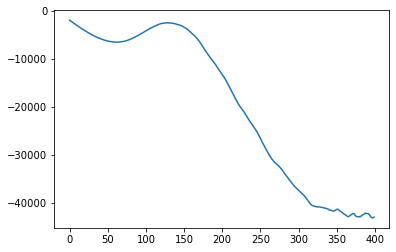

3
Epoch 0/20
5/5 [==============================] - trainLoss: -13275.7021  Val_loss: -1686814.8750 
Epoch 1/20
5/5 [==============================] - trainLoss: -13727.5029  Val_loss: -1738017.5000 
Epoch 2/20
5/5 [==============================] - trainLoss: -14299.3447  Val_loss: -1785952.3750 
Epoch 3/20
5/5 [==============================] - trainLoss: -14774.6367  Val_loss: -1830184.5000 
Epoch 4/20
5/5 [==============================] - trainLoss: -15093.0879  Val_loss: -1870143.5000 
Epoch 5/20
5/5 [==============================] - trainLoss: -15534.6592  Val_loss: -1904920.3750 
Epoch 6/20
5/5 [==============================] - trainLoss: -15934.1973  Val_loss: -1933173.2500 
Epoch 7/20
5/5 [==============================] - trainLoss: -16323.6289  Val_loss: -1956256.5000 
Epoch 8/20
5/5 [==============================] - trainLoss: -16698.8438  Val_loss: -1973120.1250 
Epoch 9/20
5/5 [==============================] - trainLoss: -17051.9512  Val_loss: -1985201.7500 
Epoch 10

5/5 [==============================] - trainLoss: -35.3694  Val_loss: -7023.0015 
Epoch 29/400
5/5 [==============================] - trainLoss: -36.2364  Val_loss: -7083.7349 
Epoch 30/400
5/5 [==============================] - trainLoss: -40.0217  Val_loss: -7145.6646 
Epoch 31/400
5/5 [==============================] - trainLoss: -40.6746  Val_loss: -7204.3711 
Epoch 32/400
5/5 [==============================] - trainLoss: -39.4319  Val_loss: -7259.5938 
Epoch 33/400
5/5 [==============================] - trainLoss: -44.9000  Val_loss: -7309.6411 
Epoch 34/400
5/5 [==============================] - trainLoss: -42.1086  Val_loss: -7352.2964 
Epoch 35/400
5/5 [==============================] - trainLoss: -39.1500  Val_loss: -7392.8711 
Epoch 36/400
5/5 [==============================] - trainLoss: -47.0869  Val_loss: -7433.4902 
Epoch 37/400
5/5 [==============================] - trainLoss: -42.3142  Val_loss: -7470.4424 
Epoch 38/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -60.7630  Val_loss: -7891.6079 
Epoch 54/400
5/5 [==============================] - trainLoss: -64.3329  Val_loss: -7900.8833 
Epoch 55/400
5/5 [==============================] - trainLoss: -58.6292  Val_loss: -7915.7080 
Epoch 56/400
5/5 [==============================] - trainLoss: -60.2015  Val_loss: -7930.3228 
Epoch 57/400
5/5 [==============================] - trainLoss: -63.8235  Val_loss: -7944.0942 
Epoch 58/400
5/5 [==============================] - trainLoss: -66.2760  Val_loss: -7957.3965 
Epoch 59/400
5/5 [==============================] - trainLoss: -67.6611  Val_loss: -7971.0332 
Epoch 60/400
5/5 [==============================] - trainLoss: -61.6252  Val_loss: -7989.8379 
Epoch 61/400
5/5 [==============================] - trainLoss: -67.1604  Val_loss: -8009.3066 
Epoch 62/400
5/5 [==============================] - trainLoss: -70.6746  Val_loss: -8030.2227 
Epoch 63/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -85.9995  Val_loss: -8276.3838 
Epoch 79/400
5/5 [==============================] - trainLoss: -86.8243  Val_loss: -8287.4180 
Epoch 80/400
5/5 [==============================] - trainLoss: -83.8669  Val_loss: -8294.6963 
Epoch 81/400
5/5 [==============================] - trainLoss: -88.3521  Val_loss: -8302.1006 
Epoch 82/400
5/5 [==============================] - trainLoss: -89.0738  Val_loss: -8314.3467 
Epoch 83/400
5/5 [==============================] - trainLoss: -84.9145  Val_loss: -8324.9189 
Epoch 84/400
5/5 [==============================] - trainLoss: -85.3570  Val_loss: -8338.9512 
Epoch 85/400
5/5 [==============================] - trainLoss: -88.4899  Val_loss: -8358.7568 
Epoch 86/400
5/5 [==============================] - trainLoss: -90.0411  Val_loss: -8379.7412 
Epoch 87/400
5/5 [==============================] - trainLoss: -89.2170  Val_loss: -8405.2500 
Epoch 88/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -105.0004  Val_loss: -9087.1201 
Epoch 104/400
5/5 [==============================] - trainLoss: -107.7741  Val_loss: -9143.9668 
Epoch 105/400
5/5 [==============================] - trainLoss: -102.9233  Val_loss: -9203.1221 
Epoch 106/400
5/5 [==============================] - trainLoss: -106.0186  Val_loss: -9262.2285 
Epoch 107/400
5/5 [==============================] - trainLoss: -107.2123  Val_loss: -9319.5723 
Epoch 108/400
5/5 [==============================] - trainLoss: -107.8027  Val_loss: -9383.7422 
Epoch 109/400
5/5 [==============================] - trainLoss: -105.5558  Val_loss: -9457.0488 
Epoch 110/400
5/5 [==============================] - trainLoss: -112.0314  Val_loss: -9535.6387 
Epoch 111/400
5/5 [==============================] - trainLoss: -110.4601  Val_loss: -9611.5928 
Epoch 112/400
5/5 [==============================] - trainLoss: -108.8512  Val_loss: -9678.4414 
Epoch 113/400
5/5 [=========================

5/5 [==============================] - trainLoss: -122.8973  Val_loss: -10734.9883 
Epoch 129/400
5/5 [==============================] - trainLoss: -123.9782  Val_loss: -10789.9404 
Epoch 130/400
5/5 [==============================] - trainLoss: -126.2143  Val_loss: -10844.5576 
Epoch 131/400
5/5 [==============================] - trainLoss: -129.4810  Val_loss: -10899.0791 
Epoch 132/400
5/5 [==============================] - trainLoss: -126.7248  Val_loss: -10958.6006 
Epoch 133/400
5/5 [==============================] - trainLoss: -126.4820  Val_loss: -11017.8389 
Epoch 134/400
5/5 [==============================] - trainLoss: -128.2849  Val_loss: -11077.2617 
Epoch 135/400
5/5 [==============================] - trainLoss: -130.3723  Val_loss: -11143.4180 
Epoch 136/400
5/5 [==============================] - trainLoss: -129.0805  Val_loss: -11216.6807 
Epoch 137/400
5/5 [==============================] - trainLoss: -127.7859  Val_loss: -11294.3838 
Epoch 138/400
5/5 [===============

5/5 [==============================] - trainLoss: -146.7231  Val_loss: -12779.7598 
Epoch 153/400
5/5 [==============================] - trainLoss: -139.5720  Val_loss: -12902.6289 
Epoch 154/400
5/5 [==============================] - trainLoss: -142.9266  Val_loss: -13020.3906 
Epoch 155/400
5/5 [==============================] - trainLoss: -144.8590  Val_loss: -13140.5723 
Epoch 156/400
5/5 [==============================] - trainLoss: -146.0652  Val_loss: -13273.3994 
Epoch 157/400
5/5 [==============================] - trainLoss: -148.7337  Val_loss: -13411.3789 
Epoch 158/400
5/5 [==============================] - trainLoss: -146.7341  Val_loss: -13542.5234 
Epoch 159/400
5/5 [==============================] - trainLoss: -148.9495  Val_loss: -13670.0869 
Epoch 160/400
5/5 [==============================] - trainLoss: -144.8680  Val_loss: -13789.1387 
Epoch 161/400
5/5 [==============================] - trainLoss: -150.5128  Val_loss: -13887.6641 
Epoch 162/400
5/5 [===============

5/5 [==============================] - trainLoss: -162.5849  Val_loss: -16145.9756 
Epoch 178/400
5/5 [==============================] - trainLoss: -163.4557  Val_loss: -16320.6641 
Epoch 179/400
5/5 [==============================] - trainLoss: -167.4324  Val_loss: -16499.2793 
Epoch 180/400
5/5 [==============================] - trainLoss: -166.5875  Val_loss: -16685.5508 
Epoch 181/400
5/5 [==============================] - trainLoss: -166.3387  Val_loss: -16876.0938 
Epoch 182/400
5/5 [==============================] - trainLoss: -166.2570  Val_loss: -17070.7969 
Epoch 183/400
5/5 [==============================] - trainLoss: -168.2041  Val_loss: -17263.8984 
Epoch 184/400
5/5 [==============================] - trainLoss: -169.8772  Val_loss: -17472.4902 
Epoch 185/400
5/5 [==============================] - trainLoss: -168.4545  Val_loss: -17671.8633 
Epoch 186/400
5/5 [==============================] - trainLoss: -170.0244  Val_loss: -17874.2715 
Epoch 187/400
5/5 [===============

5/5 [==============================] - trainLoss: -180.3047  Val_loss: -20893.9160 
Epoch 203/400
5/5 [==============================] - trainLoss: -186.2975  Val_loss: -21087.0176 
Epoch 204/400
5/5 [==============================] - trainLoss: -189.6150  Val_loss: -21289.4668 
Epoch 205/400
5/5 [==============================] - trainLoss: -186.1089  Val_loss: -21500.0586 
Epoch 206/400
5/5 [==============================] - trainLoss: -192.8577  Val_loss: -21745.4805 
Epoch 207/400
5/5 [==============================] - trainLoss: -187.6693  Val_loss: -21988.7910 
Epoch 208/400
5/5 [==============================] - trainLoss: -194.1252  Val_loss: -22252.0996 
Epoch 209/400
5/5 [==============================] - trainLoss: -189.2799  Val_loss: -22512.3613 
Epoch 210/400
5/5 [==============================] - trainLoss: -189.2620  Val_loss: -22758.6719 
Epoch 211/400
5/5 [==============================] - trainLoss: -192.2468  Val_loss: -23015.6523 
Epoch 212/400
5/5 [===============

5/5 [==============================] - trainLoss: -206.7239  Val_loss: -26325.1016 
Epoch 228/400
5/5 [==============================] - trainLoss: -206.3723  Val_loss: -26510.0078 
Epoch 229/400
5/5 [==============================] - trainLoss: -211.3572  Val_loss: -26689.4902 
Epoch 230/400
5/5 [==============================] - trainLoss: -207.8561  Val_loss: -26891.6992 
Epoch 231/400
5/5 [==============================] - trainLoss: -208.0204  Val_loss: -27085.1738 
Epoch 232/400
5/5 [==============================] - trainLoss: -214.2366  Val_loss: -27287.1016 
Epoch 233/400
5/5 [==============================] - trainLoss: -210.2030  Val_loss: -27486.3906 
Epoch 234/400
5/5 [==============================] - trainLoss: -212.7591  Val_loss: -27676.2168 
Epoch 235/400
5/5 [==============================] - trainLoss: -213.2348  Val_loss: -27850.4023 
Epoch 236/400
5/5 [==============================] - trainLoss: -214.2306  Val_loss: -28024.1680 
Epoch 237/400
5/5 [===============

5/5 [==============================] - trainLoss: -230.9187  Val_loss: -30691.0859 
Epoch 253/400
5/5 [==============================] - trainLoss: -233.4798  Val_loss: -30802.0859 
Epoch 254/400
5/5 [==============================] - trainLoss: -232.9258  Val_loss: -30922.9160 
Epoch 255/400
5/5 [==============================] - trainLoss: -234.0205  Val_loss: -31034.4570 
Epoch 256/400
5/5 [==============================] - trainLoss: -230.7887  Val_loss: -31153.0781 
Epoch 257/400
5/5 [==============================] - trainLoss: -234.2699  Val_loss: -31264.1191 
Epoch 258/400
5/5 [==============================] - trainLoss: -235.9669  Val_loss: -31362.5996 
Epoch 259/400
5/5 [==============================] - trainLoss: -237.3372  Val_loss: -31473.4844 
Epoch 260/400
5/5 [==============================] - trainLoss: -239.1301  Val_loss: -31568.8184 
Epoch 261/400
5/5 [==============================] - trainLoss: -238.7306  Val_loss: -31670.4766 
Epoch 262/400
5/5 [===============

5/5 [==============================] - trainLoss: -254.6500  Val_loss: -32676.2910 
Epoch 278/400
5/5 [==============================] - trainLoss: -257.6408  Val_loss: -32757.3164 
Epoch 279/400
5/5 [==============================] - trainLoss: -257.4328  Val_loss: -32861.4531 
Epoch 280/400
5/5 [==============================] - trainLoss: -256.4185  Val_loss: -32947.8281 
Epoch 281/400
5/5 [==============================] - trainLoss: -259.3928  Val_loss: -33009.2109 
Epoch 282/400
5/5 [==============================] - trainLoss: -260.9745  Val_loss: -33048.8477 
Epoch 283/400
5/5 [==============================] - trainLoss: -260.5347  Val_loss: -33079.2891 
Epoch 284/400
5/5 [==============================] - trainLoss: -263.1961  Val_loss: -33125.6719 
Epoch 285/400
5/5 [==============================] - trainLoss: -263.3206  Val_loss: -33171.1445 
Epoch 286/400
5/5 [==============================] - trainLoss: -262.5572  Val_loss: -33230.4297 
Epoch 287/400
5/5 [===============

5/5 [==============================] - trainLoss: -284.6544  Val_loss: -33652.3047 
Epoch 307/400
5/5 [==============================] - trainLoss: -284.3722  Val_loss: -33616.3828 
Epoch 308/400
5/5 [==============================] - trainLoss: -290.5656  Val_loss: -33570.4141 
Epoch 309/400
5/5 [==============================] - trainLoss: -290.1970  Val_loss: -33519.7891 
Epoch 310/400
5/5 [==============================] - trainLoss: -288.4886  Val_loss: -33497.8008 
Epoch 311/400
5/5 [==============================] - trainLoss: -291.6089  Val_loss: -33488.4805 
Epoch 312/400
5/5 [==============================] - trainLoss: -292.8864  Val_loss: -33523.8516 
Epoch 313/400
5/5 [==============================] - trainLoss: -292.8424  Val_loss: -33500.6562 
Epoch 314/400
5/5 [==============================] - trainLoss: -298.9123  Val_loss: -33455.5898 
Epoch 315/400
5/5 [==============================] - trainLoss: -298.8956  Val_loss: -33437.1211 
Epoch 316/400
5/5 [===============

5/5 [==============================] - trainLoss: -399.3050  Val_loss: -32720.3438 
Epoch 386/400
5/5 [==============================] - trainLoss: -398.6113  Val_loss: -32584.3770 
Epoch 387/400
5/5 [==============================] - trainLoss: -401.2840  Val_loss: -32494.1973 
Epoch 388/400
5/5 [==============================] - trainLoss: -402.3835  Val_loss: -32339.1504 
Epoch 389/400
5/5 [==============================] - trainLoss: -407.1993  Val_loss: -32152.9922 
Epoch 390/400
5/5 [==============================] - trainLoss: -407.9378  Val_loss: -32042.7344 
Epoch 391/400
5/5 [==============================] - trainLoss: -405.6095  Val_loss: -31945.0234 
Epoch 392/400
5/5 [==============================] - trainLoss: -411.2134  Val_loss: -31919.8574 
Epoch 393/400
5/5 [==============================] - trainLoss: -414.0658  Val_loss: -31908.0000 
Epoch 394/400
5/5 [==============================] - trainLoss: -409.9645  Val_loss: -31857.4160 
Epoch 395/400
5/5 [===============

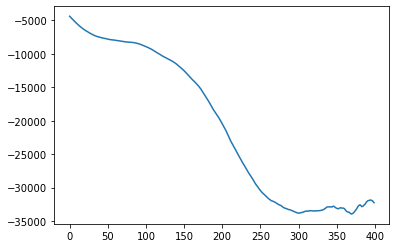

4
Epoch 0/20
5/5 [==============================] - trainLoss: -13499.2617  Val_loss: -1722639.1250 
Epoch 1/20
5/5 [==============================] - trainLoss: -14482.7842  Val_loss: -1751326.5000 
Epoch 2/20
5/5 [==============================] - trainLoss: -14281.6680  Val_loss: -1774721.7500 
Epoch 3/20
5/5 [==============================] - trainLoss: -15185.5195  Val_loss: -1791767.3750 
Epoch 4/20
5/5 [==============================] - trainLoss: -15478.2832  Val_loss: -1802441.5000 
Epoch 5/20
5/5 [==============================] - trainLoss: -15651.0801  Val_loss: -1806552.0000 
Epoch 6/20
5/5 [==============================] - trainLoss: -15991.1768  Val_loss: -1804891.1250 
Epoch 7/20
5/5 [==============================] - trainLoss: -16636.5156  Val_loss: -1798337.1250 
Epoch 8/20
5/5 [==============================] - trainLoss: -17473.1445  Val_loss: -1787765.5000 
Epoch 9/20
5/5 [==============================] - trainLoss: -17091.0898  Val_loss: -1774730.0000 
Epoch 10

5/5 [==============================] - trainLoss: -12.3362  Val_loss: -4306.1294 
Epoch 14/400
5/5 [==============================] - trainLoss: -21.3929  Val_loss: -4333.9609 
Epoch 15/400
5/5 [==============================] - trainLoss: -33.4281  Val_loss: -4357.0918 
Epoch 16/400
5/5 [==============================] - trainLoss: -29.1417  Val_loss: -4377.2192 
Epoch 17/400
5/5 [==============================] - trainLoss: -26.2614  Val_loss: -4392.4819 
Epoch 18/400
5/5 [==============================] - trainLoss: -26.2694  Val_loss: -4402.4790 
Epoch 19/400
5/5 [==============================] - trainLoss: -38.1130  Val_loss: -4411.2422 
Epoch 20/400
5/5 [==============================] - trainLoss: -27.9273  Val_loss: -4417.0576 
Epoch 21/400
5/5 [==============================] - trainLoss: -30.9435  Val_loss: -4417.6309 
Epoch 22/400
5/5 [==============================] - trainLoss: -30.8152  Val_loss: -4410.6357 
Epoch 23/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -77.5207  Val_loss: 10404.8330 
Epoch 81/400
5/5 [==============================] - trainLoss: -72.4968  Val_loss: 10936.4990 
Epoch 82/400
5/5 [==============================] - trainLoss: -77.7098  Val_loss: 11474.1973 
Epoch 83/400
5/5 [==============================] - trainLoss: -113.9708  Val_loss: 12023.8779 
Epoch 84/400
5/5 [==============================] - trainLoss: -86.8002  Val_loss: 12583.4766 
Epoch 85/400
5/5 [==============================] - trainLoss: -91.8808  Val_loss: 13138.8984 
Epoch 86/400
5/5 [==============================] - trainLoss: -84.4739  Val_loss: 13695.4424 
Epoch 87/400
5/5 [==============================] - trainLoss: -94.7518  Val_loss: 14262.3213 
Epoch 88/400
5/5 [==============================] - trainLoss: -87.1903  Val_loss: 14820.5840 
Epoch 89/400
5/5 [==============================] - trainLoss: -94.4867  Val_loss: 15377.7471 
Epoch 90/400
5/5 [==============================] - trainLoss:

5/5 [==============================] - trainLoss: -155.7368  Val_loss: 45295.0938 
Epoch 166/400
5/5 [==============================] - trainLoss: -156.2683  Val_loss: 45354.7617 
Epoch 167/400
5/5 [==============================] - trainLoss: -167.6500  Val_loss: 45469.9883 
Epoch 168/400
5/5 [==============================] - trainLoss: -159.6515  Val_loss: 45558.6836 
Epoch 169/400
5/5 [==============================] - trainLoss: -152.5109  Val_loss: 45579.1719 
Epoch 170/400
5/5 [==============================] - trainLoss: -163.2247  Val_loss: 45618.1680 
Epoch 171/400
5/5 [==============================] - trainLoss: -170.2885  Val_loss: 45673.9805 
Epoch 172/400
5/5 [==============================] - trainLoss: -160.9334  Val_loss: 45696.5195 
Epoch 173/400
5/5 [==============================] - trainLoss: -164.1006  Val_loss: 45686.4727 
Epoch 174/400
5/5 [==============================] - trainLoss: -156.7960  Val_loss: 45595.4492 
Epoch 175/400
5/5 [=========================

5/5 [==============================] - trainLoss: -241.4325  Val_loss: -23303.2676 
Epoch 272/400
5/5 [==============================] - trainLoss: -252.3596  Val_loss: -23817.0352 
Epoch 273/400
5/5 [==============================] - trainLoss: -242.5604  Val_loss: -24356.2520 
Epoch 274/400
5/5 [==============================] - trainLoss: -246.7560  Val_loss: -24893.4609 
Epoch 275/400
5/5 [==============================] - trainLoss: -237.5102  Val_loss: -25419.2012 
Epoch 276/400
5/5 [==============================] - trainLoss: -244.8813  Val_loss: -25933.2969 
Epoch 277/400
5/5 [==============================] - trainLoss: -252.2413  Val_loss: -26440.6680 
Epoch 278/400
5/5 [==============================] - trainLoss: -257.3117  Val_loss: -26907.2148 
Epoch 279/400
5/5 [==============================] - trainLoss: -254.3385  Val_loss: -27355.0742 
Epoch 280/400
5/5 [==============================] - trainLoss: -254.5013  Val_loss: -27783.1855 
Epoch 281/400
5/5 [===============

5/5 [==============================] - trainLoss: -269.0399  Val_loss: -33325.3555 
Epoch 297/400
5/5 [==============================] - trainLoss: -275.9335  Val_loss: -33621.4805 
Epoch 298/400
5/5 [==============================] - trainLoss: -276.3314  Val_loss: -33868.3789 
Epoch 299/400
5/5 [==============================] - trainLoss: -271.5002  Val_loss: -34120.3711 
Epoch 300/400
5/5 [==============================] - trainLoss: -258.5846  Val_loss: -34415.1562 
Epoch 301/400
5/5 [==============================] - trainLoss: -274.2604  Val_loss: -34694.4297 
Epoch 302/400
5/5 [==============================] - trainLoss: -282.1005  Val_loss: -34915.1719 
Epoch 303/400
5/5 [==============================] - trainLoss: -272.8663  Val_loss: -35123.3945 
Epoch 304/400
5/5 [==============================] - trainLoss: -284.3368  Val_loss: -35355.8438 
Epoch 305/400
5/5 [==============================] - trainLoss: -283.5072  Val_loss: -35601.9844 
Epoch 306/400
5/5 [===============

5/5 [==============================] - trainLoss: -289.4996  Val_loss: -39080.5352 
Epoch 322/400
5/5 [==============================] - trainLoss: -297.5831  Val_loss: -39211.8047 
Epoch 323/400
5/5 [==============================] - trainLoss: -289.2845  Val_loss: -39286.8320 
Epoch 324/400
5/5 [==============================] - trainLoss: -296.3027  Val_loss: -39372.7188 
Epoch 325/400
5/5 [==============================] - trainLoss: -297.2888  Val_loss: -39459.1016 
Epoch 326/400
5/5 [==============================] - trainLoss: -302.7437  Val_loss: -39529.5938 
Epoch 327/400
5/5 [==============================] - trainLoss: -317.5667  Val_loss: -39614.5195 
Epoch 328/400
5/5 [==============================] - trainLoss: -305.3458  Val_loss: -39684.3164 
Epoch 329/400
5/5 [==============================] - trainLoss: -301.6407  Val_loss: -39757.2500 
Epoch 330/400
5/5 [==============================] - trainLoss: -316.5652  Val_loss: -39794.6641 
Epoch 331/400
5/5 [===============

5/5 [==============================] - trainLoss: -329.1110  Val_loss: -41098.7461 
Epoch 347/400
5/5 [==============================] - trainLoss: -317.6157  Val_loss: -41220.8672 
Epoch 348/400
5/5 [==============================] - trainLoss: -329.1299  Val_loss: -41309.1211 
Epoch 349/400
5/5 [==============================] - trainLoss: -335.8411  Val_loss: -41387.8086 
Epoch 350/400
5/5 [==============================] - trainLoss: -329.7744  Val_loss: -41464.4922 
Epoch 351/400
5/5 [==============================] - trainLoss: -340.2001  Val_loss: -41502.0781 
Epoch 352/400
5/5 [==============================] - trainLoss: -334.8665  Val_loss: -41573.1680 
Epoch 353/400
5/5 [==============================] - trainLoss: -322.0766  Val_loss: -41625.2188 
Epoch 354/400
5/5 [==============================] - trainLoss: -329.5365  Val_loss: -41641.1523 
Epoch 355/400
5/5 [==============================] - trainLoss: -344.9409  Val_loss: -41631.5156 
Epoch 356/400
5/5 [===============

5/5 [==============================] - trainLoss: -362.8007  Val_loss: -42516.1445 
Epoch 376/400
5/5 [==============================] - trainLoss: -369.2791  Val_loss: -42625.2227 
Epoch 377/400
5/5 [==============================] - trainLoss: -359.8126  Val_loss: -42713.6328 
Epoch 378/400
5/5 [==============================] - trainLoss: -373.4359  Val_loss: -42730.1562 
Epoch 379/400
5/5 [==============================] - trainLoss: -375.0929  Val_loss: -42775.8672 
Epoch 380/400
5/5 [==============================] - trainLoss: -377.3511  Val_loss: -42821.8477 
Epoch 381/400
5/5 [==============================] - trainLoss: -376.6275  Val_loss: -42815.3008 
Epoch 382/400
5/5 [==============================] - trainLoss: -373.3002  Val_loss: -42828.7891 
Epoch 383/400
5/5 [==============================] - trainLoss: -378.1520  Val_loss: -42858.4727 
Epoch 384/400
5/5 [==============================] - trainLoss: -382.0525  Val_loss: -42843.3672 
Epoch 385/400
5/5 [===============

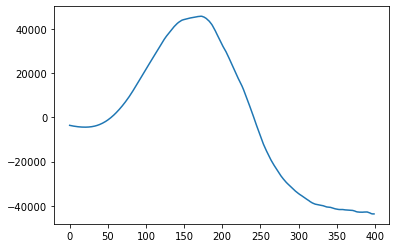

5
Epoch 0/20
5/5 [==============================] - trainLoss: -12852.6875  Val_loss: -1598915.6250 
Epoch 1/20
5/5 [==============================] - trainLoss: -13297.6152  Val_loss: -1648255.1250 
Epoch 2/20
5/5 [==============================] - trainLoss: -13705.0586  Val_loss: -1693079.5000 
Epoch 3/20
5/5 [==============================] - trainLoss: -14138.7637  Val_loss: -1732972.6250 
Epoch 4/20
5/5 [==============================] - trainLoss: -14609.0586  Val_loss: -1767813.3750 
Epoch 5/20
5/5 [==============================] - trainLoss: -14999.3008  Val_loss: -1797588.1250 
Epoch 6/20
5/5 [==============================] - trainLoss: -15298.6436  Val_loss: -1822374.3750 
Epoch 7/20
5/5 [==============================] - trainLoss: -15710.7314  Val_loss: -1843419.3750 
Epoch 8/20
5/5 [==============================] - trainLoss: -16070.8955  Val_loss: -1860719.1250 
Epoch 9/20
5/5 [==============================] - trainLoss: -16498.6250  Val_loss: -1876068.6250 
Epoch 10

5/5 [==============================] - trainLoss: -28.9222  Val_loss: -5407.5464 
Epoch 29/400
5/5 [==============================] - trainLoss: -30.0129  Val_loss: -5512.9424 
Epoch 30/400
5/5 [==============================] - trainLoss: -27.8205  Val_loss: -5617.0474 
Epoch 31/400
5/5 [==============================] - trainLoss: -28.6121  Val_loss: -5719.5210 
Epoch 32/400
5/5 [==============================] - trainLoss: -33.3815  Val_loss: -5822.4805 
Epoch 33/400
5/5 [==============================] - trainLoss: -34.0644  Val_loss: -5924.7910 
Epoch 34/400
5/5 [==============================] - trainLoss: -36.7972  Val_loss: -6027.7148 
Epoch 35/400
5/5 [==============================] - trainLoss: -39.0876  Val_loss: -6128.0645 
Epoch 36/400
5/5 [==============================] - trainLoss: -32.6622  Val_loss: -6227.6548 
Epoch 37/400
5/5 [==============================] - trainLoss: -38.0311  Val_loss: -6326.5508 
Epoch 38/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -52.4305  Val_loss: -7644.1338 
Epoch 54/400
5/5 [==============================] - trainLoss: -55.0767  Val_loss: -7706.3335 
Epoch 55/400
5/5 [==============================] - trainLoss: -57.5346  Val_loss: -7762.1650 
Epoch 56/400
5/5 [==============================] - trainLoss: -57.7145  Val_loss: -7820.8354 
Epoch 57/400
5/5 [==============================] - trainLoss: -56.3813  Val_loss: -7881.0166 
Epoch 58/400
5/5 [==============================] - trainLoss: -57.0891  Val_loss: -7940.5986 
Epoch 59/400
5/5 [==============================] - trainLoss: -58.1046  Val_loss: -8001.1411 
Epoch 60/400
5/5 [==============================] - trainLoss: -60.1745  Val_loss: -8057.6079 
Epoch 61/400
5/5 [==============================] - trainLoss: -61.5949  Val_loss: -8111.0752 
Epoch 62/400
5/5 [==============================] - trainLoss: -61.1920  Val_loss: -8160.0439 
Epoch 63/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -75.3434  Val_loss: -8575.0039 
Epoch 79/400
5/5 [==============================] - trainLoss: -79.2394  Val_loss: -8575.5703 
Epoch 80/400
5/5 [==============================] - trainLoss: -81.1301  Val_loss: -8579.4951 
Epoch 81/400
5/5 [==============================] - trainLoss: -78.2159  Val_loss: -8576.9043 
Epoch 82/400
5/5 [==============================] - trainLoss: -82.1962  Val_loss: -8576.6318 
Epoch 83/400
5/5 [==============================] - trainLoss: -80.1211  Val_loss: -8568.9336 
Epoch 84/400
5/5 [==============================] - trainLoss: -79.9164  Val_loss: -8559.6025 
Epoch 85/400
5/5 [==============================] - trainLoss: -83.2698  Val_loss: -8548.3252 
Epoch 86/400
5/5 [==============================] - trainLoss: -81.2805  Val_loss: -8536.3906 
Epoch 87/400
5/5 [==============================] - trainLoss: -81.7906  Val_loss: -8523.8135 
Epoch 88/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -140.3355  Val_loss: -6329.9463 
Epoch 157/400
5/5 [==============================] - trainLoss: -135.6710  Val_loss: -6369.3379 
Epoch 158/400
5/5 [==============================] - trainLoss: -137.9930  Val_loss: -6426.0664 
Epoch 159/400
5/5 [==============================] - trainLoss: -135.1328  Val_loss: -6464.3618 
Epoch 160/400
5/5 [==============================] - trainLoss: -140.3613  Val_loss: -6503.5669 
Epoch 161/400
5/5 [==============================] - trainLoss: -141.1337  Val_loss: -6548.3481 
Epoch 162/400
5/5 [==============================] - trainLoss: -142.4439  Val_loss: -6605.8818 
Epoch 163/400
5/5 [==============================] - trainLoss: -141.4129  Val_loss: -6667.2100 
Epoch 164/400
5/5 [==============================] - trainLoss: -147.3118  Val_loss: -6729.4600 
Epoch 165/400
5/5 [==============================] - trainLoss: -148.0382  Val_loss: -6801.5249 
Epoch 166/400
5/5 [=========================

5/5 [==============================] - trainLoss: -170.7406  Val_loss: -10892.3662 
Epoch 203/400
5/5 [==============================] - trainLoss: -167.8889  Val_loss: -11066.4805 
Epoch 204/400
5/5 [==============================] - trainLoss: -178.2577  Val_loss: -11265.5713 
Epoch 205/400
5/5 [==============================] - trainLoss: -167.9069  Val_loss: -11472.0088 
Epoch 206/400
5/5 [==============================] - trainLoss: -184.6981  Val_loss: -11673.0762 
Epoch 207/400
5/5 [==============================] - trainLoss: -181.5406  Val_loss: -11874.2236 
Epoch 208/400
5/5 [==============================] - trainLoss: -179.0994  Val_loss: -12100.4697 
Epoch 209/400
5/5 [==============================] - trainLoss: -180.3643  Val_loss: -12330.8457 
Epoch 210/400
5/5 [==============================] - trainLoss: -173.7455  Val_loss: -12552.6328 
Epoch 211/400
5/5 [==============================] - trainLoss: -183.2509  Val_loss: -12778.4307 
Epoch 212/400
5/5 [===============

5/5 [==============================] - trainLoss: -193.6411  Val_loss: -15604.5068 
Epoch 227/400
5/5 [==============================] - trainLoss: -200.7842  Val_loss: -15906.4219 
Epoch 228/400
5/5 [==============================] - trainLoss: -201.2746  Val_loss: -16201.4844 
Epoch 229/400
5/5 [==============================] - trainLoss: -198.7231  Val_loss: -16507.1543 
Epoch 230/400
5/5 [==============================] - trainLoss: -195.0488  Val_loss: -16804.5234 
Epoch 231/400
5/5 [==============================] - trainLoss: -196.0194  Val_loss: -17116.6484 
Epoch 232/400
5/5 [==============================] - trainLoss: -201.3210  Val_loss: -17404.1836 
Epoch 233/400
5/5 [==============================] - trainLoss: -204.4679  Val_loss: -17682.4277 
Epoch 234/400
5/5 [==============================] - trainLoss: -203.9142  Val_loss: -17952.0156 
Epoch 235/400
5/5 [==============================] - trainLoss: -202.7751  Val_loss: -18199.9570 
Epoch 236/400
5/5 [===============

5/5 [==============================] - trainLoss: -217.9949  Val_loss: -21918.6582 
Epoch 252/400
5/5 [==============================] - trainLoss: -220.3201  Val_loss: -22154.8145 
Epoch 253/400
5/5 [==============================] - trainLoss: -216.6841  Val_loss: -22391.4805 
Epoch 254/400
5/5 [==============================] - trainLoss: -223.0900  Val_loss: -22648.8613 
Epoch 255/400
5/5 [==============================] - trainLoss: -219.0023  Val_loss: -22914.8164 
Epoch 256/400
5/5 [==============================] - trainLoss: -229.6485  Val_loss: -23204.6895 
Epoch 257/400
5/5 [==============================] - trainLoss: -224.3612  Val_loss: -23495.4512 
Epoch 258/400
5/5 [==============================] - trainLoss: -227.5906  Val_loss: -23786.4492 
Epoch 259/400
5/5 [==============================] - trainLoss: -231.3262  Val_loss: -24036.2832 
Epoch 260/400
5/5 [==============================] - trainLoss: -223.9485  Val_loss: -24292.3477 
Epoch 261/400
5/5 [===============

5/5 [==============================] - trainLoss: -246.6117  Val_loss: -27105.9395 
Epoch 277/400
5/5 [==============================] - trainLoss: -238.4155  Val_loss: -27301.7266 
Epoch 278/400
5/5 [==============================] - trainLoss: -243.2271  Val_loss: -27496.3574 
Epoch 279/400
5/5 [==============================] - trainLoss: -244.1142  Val_loss: -27694.7109 
Epoch 280/400
5/5 [==============================] - trainLoss: -245.3800  Val_loss: -27895.8281 
Epoch 281/400
5/5 [==============================] - trainLoss: -249.6283  Val_loss: -28085.4688 
Epoch 282/400
5/5 [==============================] - trainLoss: -250.7305  Val_loss: -28258.5586 
Epoch 283/400
5/5 [==============================] - trainLoss: -250.5342  Val_loss: -28426.1406 
Epoch 284/400
5/5 [==============================] - trainLoss: -250.1936  Val_loss: -28588.5078 
Epoch 285/400
5/5 [==============================] - trainLoss: -254.8485  Val_loss: -28774.5977 
Epoch 286/400
5/5 [===============

5/5 [==============================] - trainLoss: -276.1697  Val_loss: -31186.3594 
Epoch 302/400
5/5 [==============================] - trainLoss: -271.6345  Val_loss: -31352.6309 
Epoch 303/400
5/5 [==============================] - trainLoss: -272.9752  Val_loss: -31476.6074 
Epoch 304/400
5/5 [==============================] - trainLoss: -271.7819  Val_loss: -31609.7168 
Epoch 305/400
5/5 [==============================] - trainLoss: -267.1512  Val_loss: -31771.9004 
Epoch 306/400
5/5 [==============================] - trainLoss: -270.5836  Val_loss: -31929.6426 
Epoch 307/400
5/5 [==============================] - trainLoss: -280.8103  Val_loss: -31987.7441 
Epoch 308/400
5/5 [==============================] - trainLoss: -276.4687  Val_loss: -32011.4180 
Epoch 309/400
5/5 [==============================] - trainLoss: -279.9304  Val_loss: -32031.7695 
Epoch 310/400
5/5 [==============================] - trainLoss: -278.8316  Val_loss: -32057.3066 
Epoch 311/400
5/5 [===============

5/5 [==============================] - trainLoss: -387.0543  Val_loss: -34504.3789 
Epoch 384/400
5/5 [==============================] - trainLoss: -385.7063  Val_loss: -34645.9961 
Epoch 385/400
5/5 [==============================] - trainLoss: -390.6734  Val_loss: -34801.5586 
Epoch 386/400
5/5 [==============================] - trainLoss: -390.2281  Val_loss: -34975.9414 
Epoch 387/400
5/5 [==============================] - trainLoss: -388.4822  Val_loss: -35021.1133 
Epoch 388/400
5/5 [==============================] - trainLoss: -394.9450  Val_loss: -34971.6211 
Epoch 389/400
5/5 [==============================] - trainLoss: -400.2654  Val_loss: -34865.1562 
Epoch 390/400
5/5 [==============================] - trainLoss: -395.2833  Val_loss: -34694.0664 
Epoch 391/400
5/5 [==============================] - trainLoss: -400.2043  Val_loss: -34470.5781 
Epoch 392/400
5/5 [==============================] - trainLoss: -403.8118  Val_loss: -34322.1719 
Epoch 393/400
5/5 [===============

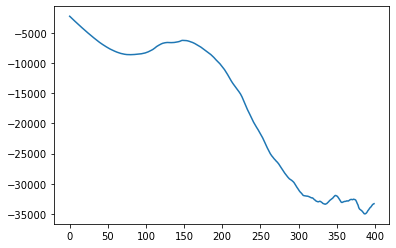

6
Epoch 0/20
5/5 [==============================] - trainLoss: -12361.9062  Val_loss: -1597528.1250 
Epoch 1/20
5/5 [==============================] - trainLoss: -12621.8984  Val_loss: -1653906.7500 
Epoch 2/20
5/5 [==============================] - trainLoss: -13280.3984  Val_loss: -1705701.7500 
Epoch 3/20
5/5 [==============================] - trainLoss: -13371.5518  Val_loss: -1754249.1250 
Epoch 4/20
5/5 [==============================] - trainLoss: -13876.3438  Val_loss: -1799969.6250 
Epoch 5/20
5/5 [==============================] - trainLoss: -14329.3789  Val_loss: -1840977.1250 
Epoch 6/20
5/5 [==============================] - trainLoss: -14709.0840  Val_loss: -1877836.3750 
Epoch 7/20
5/5 [==============================] - trainLoss: -14952.8633  Val_loss: -1909407.8750 
Epoch 8/20
5/5 [==============================] - trainLoss: -15362.0527  Val_loss: -1936455.1250 
Epoch 9/20
5/5 [==============================] - trainLoss: -15567.5059  Val_loss: -1958474.1250 
Epoch 10

5/5 [==============================] - trainLoss: -1.6322  Val_loss: -6586.7539 
Epoch 29/400
5/5 [==============================] - trainLoss: -2.5351  Val_loss: -6779.3877 
Epoch 30/400
5/5 [==============================] - trainLoss: -3.2090  Val_loss: -6971.3120 
Epoch 31/400
5/5 [==============================] - trainLoss: -6.4885  Val_loss: -7160.6089 
Epoch 32/400
5/5 [==============================] - trainLoss: -5.5099  Val_loss: -7349.5796 
Epoch 33/400
5/5 [==============================] - trainLoss: -8.6859  Val_loss: -7533.5205 
Epoch 34/400
5/5 [==============================] - trainLoss: -9.7099  Val_loss: -7715.7915 
Epoch 35/400
5/5 [==============================] - trainLoss: -10.6319  Val_loss: -7894.4453 
Epoch 36/400
5/5 [==============================] - trainLoss: -8.3161  Val_loss: -8076.7520 
Epoch 37/400
5/5 [==============================] - trainLoss: -11.0905  Val_loss: -8259.0332 
Epoch 38/400
5/5 [==============================] - trainLoss: -12.3748

5/5 [==============================] - trainLoss: -28.3269  Val_loss: -11174.3750 
Epoch 55/400
5/5 [==============================] - trainLoss: -29.8141  Val_loss: -11326.2578 
Epoch 56/400
5/5 [==============================] - trainLoss: -30.8232  Val_loss: -11478.6035 
Epoch 57/400
5/5 [==============================] - trainLoss: -31.3851  Val_loss: -11626.7822 
Epoch 58/400
5/5 [==============================] - trainLoss: -33.6114  Val_loss: -11766.2090 
Epoch 59/400
5/5 [==============================] - trainLoss: -33.3014  Val_loss: -11904.9072 
Epoch 60/400
5/5 [==============================] - trainLoss: -34.1389  Val_loss: -12043.6406 
Epoch 61/400
5/5 [==============================] - trainLoss: -34.7132  Val_loss: -12185.8369 
Epoch 62/400
5/5 [==============================] - trainLoss: -35.8274  Val_loss: -12323.3828 
Epoch 63/400
5/5 [==============================] - trainLoss: -37.8989  Val_loss: -12454.7598 
Epoch 64/400
5/5 [==============================] - t

5/5 [==============================] - trainLoss: -50.6928  Val_loss: -13913.6240 
Epoch 80/400
5/5 [==============================] - trainLoss: -53.1313  Val_loss: -13970.0713 
Epoch 81/400
5/5 [==============================] - trainLoss: -51.4285  Val_loss: -14025.5088 
Epoch 82/400
5/5 [==============================] - trainLoss: -56.2663  Val_loss: -14076.1582 
Epoch 83/400
5/5 [==============================] - trainLoss: -55.2294  Val_loss: -14124.0459 
Epoch 84/400
5/5 [==============================] - trainLoss: -57.3123  Val_loss: -14174.6797 
Epoch 85/400
5/5 [==============================] - trainLoss: -58.4401  Val_loss: -14225.8008 
Epoch 86/400
5/5 [==============================] - trainLoss: -56.3904  Val_loss: -14283.1572 
Epoch 87/400
5/5 [==============================] - trainLoss: -59.7345  Val_loss: -14337.8789 
Epoch 88/400
5/5 [==============================] - trainLoss: -59.4810  Val_loss: -14390.2832 
Epoch 89/400
5/5 [==============================] - t

5/5 [==============================] - trainLoss: -71.6284  Val_loss: -15007.8076 
Epoch 105/400
5/5 [==============================] - trainLoss: -71.9871  Val_loss: -15043.8535 
Epoch 106/400
5/5 [==============================] - trainLoss: -75.4651  Val_loss: -15084.1338 
Epoch 107/400
5/5 [==============================] - trainLoss: -74.9191  Val_loss: -15114.0576 
Epoch 108/400
5/5 [==============================] - trainLoss: -74.3345  Val_loss: -15146.8135 
Epoch 109/400
5/5 [==============================] - trainLoss: -75.4088  Val_loss: -15183.0928 
Epoch 110/400
5/5 [==============================] - trainLoss: -77.0294  Val_loss: -15217.1045 
Epoch 111/400
5/5 [==============================] - trainLoss: -77.0102  Val_loss: -15246.5088 
Epoch 112/400
5/5 [==============================] - trainLoss: -77.9879  Val_loss: -15276.1533 
Epoch 113/400
5/5 [==============================] - trainLoss: -80.7874  Val_loss: -15302.3594 
Epoch 114/400
5/5 [=========================

5/5 [==============================] - trainLoss: -90.4355  Val_loss: -15654.2197 
Epoch 130/400
5/5 [==============================] - trainLoss: -91.2191  Val_loss: -15673.0889 
Epoch 131/400
5/5 [==============================] - trainLoss: -92.4085  Val_loss: -15701.6963 
Epoch 132/400
5/5 [==============================] - trainLoss: -92.3165  Val_loss: -15739.4111 
Epoch 133/400
5/5 [==============================] - trainLoss: -95.3185  Val_loss: -15777.9365 
Epoch 134/400
5/5 [==============================] - trainLoss: -91.7826  Val_loss: -15832.6201 
Epoch 135/400
5/5 [==============================] - trainLoss: -95.4161  Val_loss: -15893.7334 
Epoch 136/400
5/5 [==============================] - trainLoss: -96.1005  Val_loss: -15949.2002 
Epoch 137/400
5/5 [==============================] - trainLoss: -97.7115  Val_loss: -16000.2500 
Epoch 138/400
5/5 [==============================] - trainLoss: -98.0465  Val_loss: -16047.8154 
Epoch 139/400
5/5 [=========================

5/5 [==============================] - trainLoss: -110.9583  Val_loss: -17360.6426 
Epoch 155/400
5/5 [==============================] - trainLoss: -110.7690  Val_loss: -17503.3652 
Epoch 156/400
5/5 [==============================] - trainLoss: -112.7638  Val_loss: -17639.9023 
Epoch 157/400
5/5 [==============================] - trainLoss: -111.8503  Val_loss: -17802.2520 
Epoch 158/400
5/5 [==============================] - trainLoss: -112.9625  Val_loss: -17963.2012 
Epoch 159/400
5/5 [==============================] - trainLoss: -113.9188  Val_loss: -18110.8359 
Epoch 160/400
5/5 [==============================] - trainLoss: -113.8265  Val_loss: -18269.9355 
Epoch 161/400
5/5 [==============================] - trainLoss: -115.2425  Val_loss: -18444.0371 
Epoch 162/400
5/5 [==============================] - trainLoss: -116.6982  Val_loss: -18614.8730 
Epoch 163/400
5/5 [==============================] - trainLoss: -118.0295  Val_loss: -18787.6094 
Epoch 164/400
5/5 [===============

5/5 [==============================] - trainLoss: -128.2296  Val_loss: -21174.3809 
Epoch 179/400
5/5 [==============================] - trainLoss: -129.3095  Val_loss: -21360.3477 
Epoch 180/400
5/5 [==============================] - trainLoss: -132.1483  Val_loss: -21528.2168 
Epoch 181/400
5/5 [==============================] - trainLoss: -130.4224  Val_loss: -21698.6113 
Epoch 182/400
5/5 [==============================] - trainLoss: -131.4603  Val_loss: -21871.8438 
Epoch 183/400
5/5 [==============================] - trainLoss: -131.8517  Val_loss: -22061.1758 
Epoch 184/400
5/5 [==============================] - trainLoss: -133.1877  Val_loss: -22258.7012 
Epoch 185/400
5/5 [==============================] - trainLoss: -132.6937  Val_loss: -22481.4277 
Epoch 186/400
5/5 [==============================] - trainLoss: -136.3939  Val_loss: -22694.5000 
Epoch 187/400
5/5 [==============================] - trainLoss: -138.1346  Val_loss: -22909.2891 
Epoch 188/400
5/5 [===============

5/5 [==============================] - trainLoss: -149.2543  Val_loss: -26051.4102 
Epoch 204/400
5/5 [==============================] - trainLoss: -152.2763  Val_loss: -26181.9902 
Epoch 205/400
5/5 [==============================] - trainLoss: -150.4777  Val_loss: -26332.7988 
Epoch 206/400
5/5 [==============================] - trainLoss: -150.8117  Val_loss: -26486.6562 
Epoch 207/400
5/5 [==============================] - trainLoss: -152.3242  Val_loss: -26645.2109 
Epoch 208/400
5/5 [==============================] - trainLoss: -153.9199  Val_loss: -26800.4941 
Epoch 209/400
5/5 [==============================] - trainLoss: -153.4220  Val_loss: -26980.1055 
Epoch 210/400
5/5 [==============================] - trainLoss: -152.7343  Val_loss: -27176.7012 
Epoch 211/400
5/5 [==============================] - trainLoss: -157.3730  Val_loss: -27373.1680 
Epoch 212/400
5/5 [==============================] - trainLoss: -157.4496  Val_loss: -27578.2246 
Epoch 213/400
5/5 [===============

5/5 [==============================] - trainLoss: -171.6436  Val_loss: -31330.1309 
Epoch 229/400
5/5 [==============================] - trainLoss: -171.1412  Val_loss: -31526.3750 
Epoch 230/400
5/5 [==============================] - trainLoss: -172.3613  Val_loss: -31739.6992 
Epoch 231/400
5/5 [==============================] - trainLoss: -175.7158  Val_loss: -31954.7832 
Epoch 232/400
5/5 [==============================] - trainLoss: -177.2082  Val_loss: -32152.8691 
Epoch 233/400
5/5 [==============================] - trainLoss: -173.5416  Val_loss: -32342.2422 
Epoch 234/400
5/5 [==============================] - trainLoss: -177.5597  Val_loss: -32527.4531 
Epoch 235/400
5/5 [==============================] - trainLoss: -176.0044  Val_loss: -32698.3262 
Epoch 236/400
5/5 [==============================] - trainLoss: -178.5633  Val_loss: -32852.4531 
Epoch 237/400
5/5 [==============================] - trainLoss: -179.0870  Val_loss: -33001.9219 
Epoch 238/400
5/5 [===============

5/5 [==============================] - trainLoss: -196.0987  Val_loss: -35155.0820 
Epoch 254/400
5/5 [==============================] - trainLoss: -192.1592  Val_loss: -35270.0039 
Epoch 255/400
5/5 [==============================] - trainLoss: -197.7548  Val_loss: -35392.0859 
Epoch 256/400
5/5 [==============================] - trainLoss: -195.4603  Val_loss: -35508.9141 
Epoch 257/400
5/5 [==============================] - trainLoss: -197.1318  Val_loss: -35648.5039 
Epoch 258/400
5/5 [==============================] - trainLoss: -198.8642  Val_loss: -35797.4102 
Epoch 259/400
5/5 [==============================] - trainLoss: -198.6909  Val_loss: -35951.8594 
Epoch 260/400
5/5 [==============================] - trainLoss: -202.4708  Val_loss: -36114.9414 
Epoch 261/400
5/5 [==============================] - trainLoss: -203.4836  Val_loss: -36268.8398 
Epoch 262/400
5/5 [==============================] - trainLoss: -202.0221  Val_loss: -36434.9297 
Epoch 263/400
5/5 [===============

5/5 [==============================] - trainLoss: -221.0039  Val_loss: -38520.8867 
Epoch 279/400
5/5 [==============================] - trainLoss: -222.0876  Val_loss: -38642.2383 
Epoch 280/400
5/5 [==============================] - trainLoss: -221.1530  Val_loss: -38763.3789 
Epoch 281/400
5/5 [==============================] - trainLoss: -223.6399  Val_loss: -38891.0859 
Epoch 282/400
5/5 [==============================] - trainLoss: -221.6983  Val_loss: -39008.6172 
Epoch 283/400
5/5 [==============================] - trainLoss: -227.1889  Val_loss: -39126.0977 
Epoch 284/400
5/5 [==============================] - trainLoss: -224.2711  Val_loss: -39218.1836 
Epoch 285/400
5/5 [==============================] - trainLoss: -224.9871  Val_loss: -39300.8672 
Epoch 286/400
5/5 [==============================] - trainLoss: -229.4742  Val_loss: -39385.4219 
Epoch 287/400
5/5 [==============================] - trainLoss: -229.6594  Val_loss: -39484.7500 
Epoch 288/400
5/5 [===============

5/5 [==============================] - trainLoss: -247.8487  Val_loss: -40765.3711 
Epoch 304/400
5/5 [==============================] - trainLoss: -249.9267  Val_loss: -40859.6094 
Epoch 305/400
5/5 [==============================] - trainLoss: -251.2496  Val_loss: -40966.3789 
Epoch 306/400
5/5 [==============================] - trainLoss: -250.0101  Val_loss: -41077.8398 
Epoch 307/400
5/5 [==============================] - trainLoss: -249.5230  Val_loss: -41174.3281 
Epoch 308/400
5/5 [==============================] - trainLoss: -255.0352  Val_loss: -41283.0195 
Epoch 309/400
5/5 [==============================] - trainLoss: -253.0773  Val_loss: -41399.2812 
Epoch 310/400
5/5 [==============================] - trainLoss: -254.0178  Val_loss: -41515.6992 
Epoch 311/400
5/5 [==============================] - trainLoss: -259.9166  Val_loss: -41641.1836 
Epoch 312/400
5/5 [==============================] - trainLoss: -258.8987  Val_loss: -41740.5117 
Epoch 313/400
5/5 [===============

5/5 [==============================] - trainLoss: -276.9928  Val_loss: -42643.5508 
Epoch 329/400
5/5 [==============================] - trainLoss: -281.1035  Val_loss: -42695.2891 
Epoch 330/400
5/5 [==============================] - trainLoss: -278.8397  Val_loss: -42731.2539 
Epoch 331/400
5/5 [==============================] - trainLoss: -280.8510  Val_loss: -42741.1484 
Epoch 332/400
5/5 [==============================] - trainLoss: -282.2870  Val_loss: -42727.1719 
Epoch 333/400
5/5 [==============================] - trainLoss: -282.1975  Val_loss: -42682.0625 
Epoch 334/400
5/5 [==============================] - trainLoss: -285.9303  Val_loss: -42645.8086 
Epoch 335/400
5/5 [==============================] - trainLoss: -287.0701  Val_loss: -42659.4180 
Epoch 336/400
5/5 [==============================] - trainLoss: -286.9932  Val_loss: -42656.3438 
Epoch 337/400
5/5 [==============================] - trainLoss: -289.8198  Val_loss: -42634.4570 
Epoch 338/400
5/5 [===============

5/5 [==============================] - trainLoss: -347.9819  Val_loss: -43569.3477 
Epoch 377/400
5/5 [==============================] - trainLoss: -352.7857  Val_loss: -43496.2344 
Epoch 378/400
5/5 [==============================] - trainLoss: -355.2249  Val_loss: -43429.1211 
Epoch 379/400
5/5 [==============================] - trainLoss: -355.9151  Val_loss: -43429.4336 
Epoch 380/400
5/5 [==============================] - trainLoss: -354.4965  Val_loss: -43362.6641 
Epoch 381/400
5/5 [==============================] - trainLoss: -357.3496  Val_loss: -43281.9023 
Epoch 382/400
5/5 [==============================] - trainLoss: -358.7486  Val_loss: -43205.8516 
Epoch 383/400
5/5 [==============================] - trainLoss: -363.9692  Val_loss: -43134.6484 
Epoch 384/400
5/5 [==============================] - trainLoss: -361.5449  Val_loss: -43052.4883 
Epoch 385/400
5/5 [==============================] - trainLoss: -364.2004  Val_loss: -42909.8008 
Epoch 386/400
5/5 [===============

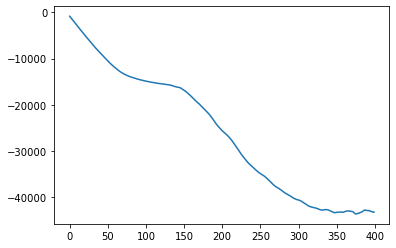

7
Epoch 0/20
5/5 [==============================] - trainLoss: -12579.7178  Val_loss: -1521294.0000 
Epoch 1/20
5/5 [==============================] - trainLoss: -13111.0137  Val_loss: -1586773.2500 
Epoch 2/20
5/5 [==============================] - trainLoss: -13511.3838  Val_loss: -1650123.2500 
Epoch 3/20
5/5 [==============================] - trainLoss: -13853.9424  Val_loss: -1710153.7500 
Epoch 4/20
5/5 [==============================] - trainLoss: -14388.3887  Val_loss: -1764551.1250 
Epoch 5/20
5/5 [==============================] - trainLoss: -14680.9111  Val_loss: -1814099.1250 
Epoch 6/20
5/5 [==============================] - trainLoss: -15120.3496  Val_loss: -1858349.7500 
Epoch 7/20
5/5 [==============================] - trainLoss: -15435.5254  Val_loss: -1896357.0000 
Epoch 8/20
5/5 [==============================] - trainLoss: -15780.0137  Val_loss: -1927689.7500 
Epoch 9/20
5/5 [==============================] - trainLoss: -16113.7324  Val_loss: -1952131.1250 
Epoch 10

5/5 [==============================] - trainLoss: -3.4040  Val_loss: -5089.5303 
Epoch 29/400
5/5 [==============================] - trainLoss: -7.3768  Val_loss: -5254.5215 
Epoch 30/400
5/5 [==============================] - trainLoss: -11.5815  Val_loss: -5416.9751 
Epoch 31/400
5/5 [==============================] - trainLoss: -10.0948  Val_loss: -5575.0723 
Epoch 32/400
5/5 [==============================] - trainLoss: -12.3291  Val_loss: -5732.0713 
Epoch 33/400
5/5 [==============================] - trainLoss: -10.8592  Val_loss: -5886.5645 
Epoch 34/400
5/5 [==============================] - trainLoss: -11.6961  Val_loss: -6039.3877 
Epoch 35/400
5/5 [==============================] - trainLoss: -15.0687  Val_loss: -6188.4619 
Epoch 36/400
5/5 [==============================] - trainLoss: -14.1729  Val_loss: -6335.7207 
Epoch 37/400
5/5 [==============================] - trainLoss: -18.9660  Val_loss: -6478.0171 
Epoch 38/400
5/5 [==============================] - trainLoss: -1

5/5 [==============================] - trainLoss: -33.1743  Val_loss: -8385.3691 
Epoch 54/400
5/5 [==============================] - trainLoss: -33.4393  Val_loss: -8469.3779 
Epoch 55/400
5/5 [==============================] - trainLoss: -35.6229  Val_loss: -8551.9678 
Epoch 56/400
5/5 [==============================] - trainLoss: -40.1144  Val_loss: -8627.6543 
Epoch 57/400
5/5 [==============================] - trainLoss: -38.6299  Val_loss: -8698.9902 
Epoch 58/400
5/5 [==============================] - trainLoss: -40.9839  Val_loss: -8763.4609 
Epoch 59/400
5/5 [==============================] - trainLoss: -37.2887  Val_loss: -8825.4805 
Epoch 60/400
5/5 [==============================] - trainLoss: -44.7406  Val_loss: -8884.8232 
Epoch 61/400
5/5 [==============================] - trainLoss: -40.8449  Val_loss: -8940.6533 
Epoch 62/400
5/5 [==============================] - trainLoss: -40.3581  Val_loss: -8993.5215 
Epoch 63/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -138.8866  Val_loss: 584.5294 
Epoch 181/400
5/5 [==============================] - trainLoss: -140.4068  Val_loss: 468.6632 
Epoch 182/400
5/5 [==============================] - trainLoss: -139.7756  Val_loss: 372.9828 
Epoch 183/400
5/5 [==============================] - trainLoss: -142.9560  Val_loss: 271.3415 
Epoch 184/400
5/5 [==============================] - trainLoss: -141.5206  Val_loss: 159.9693 
Epoch 185/400
5/5 [==============================] - trainLoss: -142.0263  Val_loss: 49.3870 
Epoch 186/400
5/5 [==============================] - trainLoss: -141.1306  Val_loss: -68.1175 
Epoch 187/400
5/5 [==============================] - trainLoss: -146.3454  Val_loss: -195.9534 
Epoch 188/400
5/5 [==============================] - trainLoss: -143.5904  Val_loss: -317.2443 
Epoch 189/400
5/5 [==============================] - trainLoss: -145.7641  Val_loss: -449.6847 
Epoch 190/400
5/5 [==============================] - trainLoss

5/5 [==============================] - trainLoss: -188.0840  Val_loss: -13170.8320 
Epoch 240/400
5/5 [==============================] - trainLoss: -189.0181  Val_loss: -13524.1445 
Epoch 241/400
5/5 [==============================] - trainLoss: -193.1222  Val_loss: -13825.9902 
Epoch 242/400
5/5 [==============================] - trainLoss: -191.5414  Val_loss: -14128.3086 
Epoch 243/400
5/5 [==============================] - trainLoss: -194.4343  Val_loss: -14436.1152 
Epoch 244/400
5/5 [==============================] - trainLoss: -190.9312  Val_loss: -14792.2754 
Epoch 245/400
5/5 [==============================] - trainLoss: -193.7497  Val_loss: -15139.2031 
Epoch 246/400
5/5 [==============================] - trainLoss: -196.7798  Val_loss: -15482.2930 
Epoch 247/400
5/5 [==============================] - trainLoss: -198.3533  Val_loss: -15835.1445 
Epoch 248/400
5/5 [==============================] - trainLoss: -200.2225  Val_loss: -16164.8623 
Epoch 249/400
5/5 [===============

5/5 [==============================] - trainLoss: -208.0042  Val_loss: -20956.6953 
Epoch 264/400
5/5 [==============================] - trainLoss: -212.4550  Val_loss: -21385.8223 
Epoch 265/400
5/5 [==============================] - trainLoss: -210.3624  Val_loss: -21824.2637 
Epoch 266/400
5/5 [==============================] - trainLoss: -214.0008  Val_loss: -22268.0605 
Epoch 267/400
5/5 [==============================] - trainLoss: -214.1900  Val_loss: -22718.4180 
Epoch 268/400
5/5 [==============================] - trainLoss: -211.7647  Val_loss: -23170.8574 
Epoch 269/400
5/5 [==============================] - trainLoss: -216.6581  Val_loss: -23618.0059 
Epoch 270/400
5/5 [==============================] - trainLoss: -217.5277  Val_loss: -24055.6191 
Epoch 271/400
5/5 [==============================] - trainLoss: -219.1975  Val_loss: -24428.3652 
Epoch 272/400
5/5 [==============================] - trainLoss: -220.4036  Val_loss: -24739.1348 
Epoch 273/400
5/5 [===============

5/5 [==============================] - trainLoss: -237.0499  Val_loss: -29834.4648 
Epoch 289/400
5/5 [==============================] - trainLoss: -236.6888  Val_loss: -30162.1152 
Epoch 290/400
5/5 [==============================] - trainLoss: -239.4858  Val_loss: -30500.9609 
Epoch 291/400
5/5 [==============================] - trainLoss: -244.0812  Val_loss: -30856.6406 
Epoch 292/400
5/5 [==============================] - trainLoss: -242.7164  Val_loss: -31195.4062 
Epoch 293/400
5/5 [==============================] - trainLoss: -243.2136  Val_loss: -31518.2246 
Epoch 294/400
5/5 [==============================] - trainLoss: -243.6743  Val_loss: -31827.4316 
Epoch 295/400
5/5 [==============================] - trainLoss: -244.3798  Val_loss: -32107.5605 
Epoch 296/400
5/5 [==============================] - trainLoss: -246.8013  Val_loss: -32371.8027 
Epoch 297/400
5/5 [==============================] - trainLoss: -246.8985  Val_loss: -32650.4863 
Epoch 298/400
5/5 [===============

5/5 [==============================] - trainLoss: -265.0808  Val_loss: -36389.4102 
Epoch 314/400
5/5 [==============================] - trainLoss: -266.1459  Val_loss: -36578.1914 
Epoch 315/400
5/5 [==============================] - trainLoss: -266.1711  Val_loss: -36774.2539 
Epoch 316/400
5/5 [==============================] - trainLoss: -269.3383  Val_loss: -36959.4961 
Epoch 317/400
5/5 [==============================] - trainLoss: -269.2430  Val_loss: -37149.6641 
Epoch 318/400
5/5 [==============================] - trainLoss: -270.3873  Val_loss: -37336.8359 
Epoch 319/400
5/5 [==============================] - trainLoss: -272.0349  Val_loss: -37525.6445 
Epoch 320/400
5/5 [==============================] - trainLoss: -272.4740  Val_loss: -37691.2344 
Epoch 321/400
5/5 [==============================] - trainLoss: -275.0219  Val_loss: -37831.9961 
Epoch 322/400
5/5 [==============================] - trainLoss: -275.6886  Val_loss: -37994.9062 
Epoch 323/400
5/5 [===============

5/5 [==============================] - trainLoss: -296.1090  Val_loss: -39703.4375 
Epoch 339/400
5/5 [==============================] - trainLoss: -295.3401  Val_loss: -39804.8594 
Epoch 340/400
5/5 [==============================] - trainLoss: -297.3490  Val_loss: -39911.1992 
Epoch 341/400
5/5 [==============================] - trainLoss: -300.9910  Val_loss: -40067.6445 
Epoch 342/400
5/5 [==============================] - trainLoss: -303.2540  Val_loss: -40258.3555 
Epoch 343/400
5/5 [==============================] - trainLoss: -303.1519  Val_loss: -40435.8906 
Epoch 344/400
5/5 [==============================] - trainLoss: -303.2668  Val_loss: -40578.0469 
Epoch 345/400
5/5 [==============================] - trainLoss: -305.8937  Val_loss: -40715.8125 
Epoch 346/400
5/5 [==============================] - trainLoss: -307.2327  Val_loss: -40855.7461 
Epoch 347/400
5/5 [==============================] - trainLoss: -308.1961  Val_loss: -40989.8359 
Epoch 348/400
5/5 [===============

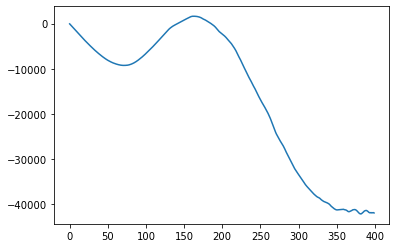

8
Epoch 0/20
5/5 [==============================] - trainLoss: -13382.2412  Val_loss: -1586839.3750 
Epoch 1/20
5/5 [==============================] - trainLoss: -13709.6719  Val_loss: -1627426.5000 
Epoch 2/20
5/5 [==============================] - trainLoss: -14154.8008  Val_loss: -1665701.8750 
Epoch 3/20
5/5 [==============================] - trainLoss: -14737.6064  Val_loss: -1699303.1250 
Epoch 4/20
5/5 [==============================] - trainLoss: -14956.0332  Val_loss: -1728022.5000 
Epoch 5/20
5/5 [==============================] - trainLoss: -15569.4619  Val_loss: -1748709.3750 
Epoch 6/20
5/5 [==============================] - trainLoss: -15991.3359  Val_loss: -1761956.8750 
Epoch 7/20
5/5 [==============================] - trainLoss: -16242.3193  Val_loss: -1769208.8750 
Epoch 8/20
5/5 [==============================] - trainLoss: -16628.0879  Val_loss: -1769225.0000 
Epoch 9/20
5/5 [==============================] - trainLoss: -17314.4395  Val_loss: -1764963.1250 
Epoch 10

5/5 [==============================] - trainLoss: -67.0910  Val_loss: 186.9097 
Epoch 61/400
5/5 [==============================] - trainLoss: -66.4617  Val_loss: 468.5496 
Epoch 62/400
5/5 [==============================] - trainLoss: -69.1896  Val_loss: 759.0753 
Epoch 63/400
5/5 [==============================] - trainLoss: -77.0167  Val_loss: 1058.5488 
Epoch 64/400
5/5 [==============================] - trainLoss: -74.0966  Val_loss: 1360.1085 
Epoch 65/400
5/5 [==============================] - trainLoss: -76.6101  Val_loss: 1667.6371 
Epoch 66/400
5/5 [==============================] - trainLoss: -76.1962  Val_loss: 1978.8782 
Epoch 67/400
5/5 [==============================] - trainLoss: -69.9244  Val_loss: 2304.3901 
Epoch 68/400
5/5 [==============================] - trainLoss: -68.6969  Val_loss: 2645.7371 
Epoch 69/400
5/5 [==============================] - trainLoss: -80.6257  Val_loss: 2997.9158 
Epoch 70/400
5/5 [==============================] - trainLoss: -77.3402  Val

5/5 [==============================] - trainLoss: -200.7088  Val_loss: 94.9288 
Epoch 230/400
5/5 [==============================] - trainLoss: -208.2319  Val_loss: -699.1719 
Epoch 231/400
5/5 [==============================] - trainLoss: -202.6207  Val_loss: -1507.8225 
Epoch 232/400
5/5 [==============================] - trainLoss: -201.4799  Val_loss: -2325.8811 
Epoch 233/400
5/5 [==============================] - trainLoss: -199.4885  Val_loss: -3111.0251 
Epoch 234/400
5/5 [==============================] - trainLoss: -207.5208  Val_loss: -3917.8125 
Epoch 235/400
5/5 [==============================] - trainLoss: -202.8289  Val_loss: -4765.0698 
Epoch 236/400
5/5 [==============================] - trainLoss: -208.3400  Val_loss: -5577.3560 
Epoch 237/400
5/5 [==============================] - trainLoss: -207.3024  Val_loss: -6356.2368 
Epoch 238/400
5/5 [==============================] - trainLoss: -205.7895  Val_loss: -7113.3628 
Epoch 239/400
5/5 [=============================

5/5 [==============================] - trainLoss: -224.8889  Val_loss: -21077.4297 
Epoch 259/400
5/5 [==============================] - trainLoss: -222.6141  Val_loss: -21656.0488 
Epoch 260/400
5/5 [==============================] - trainLoss: -224.0594  Val_loss: -22210.6777 
Epoch 261/400
5/5 [==============================] - trainLoss: -230.3253  Val_loss: -22796.5996 
Epoch 262/400
5/5 [==============================] - trainLoss: -231.8826  Val_loss: -23368.5898 
Epoch 263/400
5/5 [==============================] - trainLoss: -232.6713  Val_loss: -23960.4512 
Epoch 264/400
5/5 [==============================] - trainLoss: -231.6037  Val_loss: -24566.7754 
Epoch 265/400
5/5 [==============================] - trainLoss: -228.6420  Val_loss: -25154.1230 
Epoch 266/400
5/5 [==============================] - trainLoss: -233.9137  Val_loss: -25698.7930 
Epoch 267/400
5/5 [==============================] - trainLoss: -235.2254  Val_loss: -26255.6641 
Epoch 268/400
5/5 [===============

5/5 [==============================] - trainLoss: -252.8718  Val_loss: -31889.9512 
Epoch 283/400
5/5 [==============================] - trainLoss: -250.3166  Val_loss: -32222.0996 
Epoch 284/400
5/5 [==============================] - trainLoss: -252.8882  Val_loss: -32491.9023 
Epoch 285/400
5/5 [==============================] - trainLoss: -256.2013  Val_loss: -32796.4375 
Epoch 286/400
5/5 [==============================] - trainLoss: -258.7482  Val_loss: -33124.8867 
Epoch 287/400
5/5 [==============================] - trainLoss: -255.3737  Val_loss: -33460.9883 
Epoch 288/400
5/5 [==============================] - trainLoss: -256.3332  Val_loss: -33765.8438 
Epoch 289/400
5/5 [==============================] - trainLoss: -256.0558  Val_loss: -34011.3711 
Epoch 290/400
5/5 [==============================] - trainLoss: -258.7755  Val_loss: -34254.5469 
Epoch 291/400
5/5 [==============================] - trainLoss: -260.1186  Val_loss: -34496.6211 
Epoch 292/400
5/5 [===============

5/5 [==============================] - trainLoss: -279.4849  Val_loss: -37410.0898 
Epoch 308/400
5/5 [==============================] - trainLoss: -285.0797  Val_loss: -37502.0312 
Epoch 309/400
5/5 [==============================] - trainLoss: -276.8726  Val_loss: -37608.3125 
Epoch 310/400
5/5 [==============================] - trainLoss: -281.0890  Val_loss: -37705.8711 
Epoch 311/400
5/5 [==============================] - trainLoss: -286.4556  Val_loss: -37826.3672 
Epoch 312/400
5/5 [==============================] - trainLoss: -281.4356  Val_loss: -37931.4961 
Epoch 313/400
5/5 [==============================] - trainLoss: -287.6860  Val_loss: -37981.0234 
Epoch 314/400
5/5 [==============================] - trainLoss: -284.1564  Val_loss: -38039.0547 
Epoch 315/400
5/5 [==============================] - trainLoss: -289.0069  Val_loss: -38093.8438 
Epoch 316/400
5/5 [==============================] - trainLoss: -284.6693  Val_loss: -38202.6953 
Epoch 317/400
5/5 [===============

5/5 [==============================] - trainLoss: -308.4087  Val_loss: -39482.1016 
Epoch 335/400
5/5 [==============================] - trainLoss: -313.3799  Val_loss: -39536.2734 
Epoch 336/400
5/5 [==============================] - trainLoss: -308.2941  Val_loss: -39597.7266 
Epoch 337/400
5/5 [==============================] - trainLoss: -313.9448  Val_loss: -39687.1797 
Epoch 338/400
5/5 [==============================] - trainLoss: -314.5536  Val_loss: -39777.1953 
Epoch 339/400
5/5 [==============================] - trainLoss: -315.4148  Val_loss: -39888.0977 
Epoch 340/400
5/5 [==============================] - trainLoss: -317.1605  Val_loss: -39997.1055 
Epoch 341/400
5/5 [==============================] - trainLoss: -320.5735  Val_loss: -40069.9609 
Epoch 342/400
5/5 [==============================] - trainLoss: -319.1307  Val_loss: -40094.2070 
Epoch 343/400
5/5 [==============================] - trainLoss: -323.2660  Val_loss: -40087.0898 
Epoch 344/400
5/5 [===============

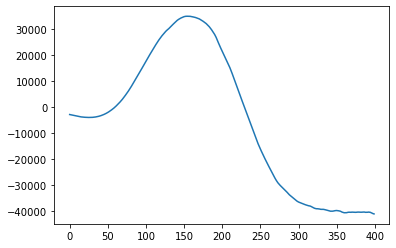

9
Epoch 0/20
5/5 [==============================] - trainLoss: -12533.3467  Val_loss: -1680325.8750 
Epoch 1/20
5/5 [==============================] - trainLoss: -13352.5986  Val_loss: -1724189.8750 
Epoch 2/20
5/5 [==============================] - trainLoss: -13731.6807  Val_loss: -1764014.8750 
Epoch 3/20
5/5 [==============================] - trainLoss: -14192.1494  Val_loss: -1802129.0000 
Epoch 4/20
5/5 [==============================] - trainLoss: -14582.1143  Val_loss: -1836390.5000 
Epoch 5/20
5/5 [==============================] - trainLoss: -15055.1660  Val_loss: -1866650.1250 
Epoch 6/20
5/5 [==============================] - trainLoss: -15256.9336  Val_loss: -1892665.1250 
Epoch 7/20
5/5 [==============================] - trainLoss: -15526.0674  Val_loss: -1914692.1250 
Epoch 8/20
5/5 [==============================] - trainLoss: -15914.3750  Val_loss: -1933579.1250 
Epoch 9/20
5/5 [==============================] - trainLoss: -16529.7480  Val_loss: -1950277.8750 
Epoch 10

5/5 [==============================] - trainLoss: -25.3712  Val_loss: -7854.6602 
Epoch 29/400
5/5 [==============================] - trainLoss: -25.2276  Val_loss: -7986.2749 
Epoch 30/400
5/5 [==============================] - trainLoss: -25.6158  Val_loss: -8119.2603 
Epoch 31/400
5/5 [==============================] - trainLoss: -23.9674  Val_loss: -8252.1279 
Epoch 32/400
5/5 [==============================] - trainLoss: -23.9182  Val_loss: -8383.1250 
Epoch 33/400
5/5 [==============================] - trainLoss: -26.0610  Val_loss: -8510.1201 
Epoch 34/400
5/5 [==============================] - trainLoss: -30.4203  Val_loss: -8636.3828 
Epoch 35/400
5/5 [==============================] - trainLoss: -28.6317  Val_loss: -8763.3828 
Epoch 36/400
5/5 [==============================] - trainLoss: -30.8877  Val_loss: -8886.4443 
Epoch 37/400
5/5 [==============================] - trainLoss: -34.3654  Val_loss: -9010.2607 
Epoch 38/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -44.4078  Val_loss: -10903.8174 
Epoch 54/400
5/5 [==============================] - trainLoss: -46.4356  Val_loss: -11014.0430 
Epoch 55/400
5/5 [==============================] - trainLoss: -48.3401  Val_loss: -11122.2627 
Epoch 56/400
5/5 [==============================] - trainLoss: -47.1738  Val_loss: -11226.7754 
Epoch 57/400
5/5 [==============================] - trainLoss: -53.9444  Val_loss: -11330.6182 
Epoch 58/400
5/5 [==============================] - trainLoss: -49.1539  Val_loss: -11432.6719 
Epoch 59/400
5/5 [==============================] - trainLoss: -47.8616  Val_loss: -11533.9541 
Epoch 60/400
5/5 [==============================] - trainLoss: -52.3258  Val_loss: -11631.7363 
Epoch 61/400
5/5 [==============================] - trainLoss: -62.1209  Val_loss: -11732.4004 
Epoch 62/400
5/5 [==============================] - trainLoss: -53.3047  Val_loss: -11831.1211 
Epoch 63/400
5/5 [==============================] - t

5/5 [==============================] - trainLoss: -70.7555  Val_loss: -13236.6797 
Epoch 79/400
5/5 [==============================] - trainLoss: -72.2896  Val_loss: -13319.8828 
Epoch 80/400
5/5 [==============================] - trainLoss: -73.0311  Val_loss: -13402.7588 
Epoch 81/400
5/5 [==============================] - trainLoss: -74.0564  Val_loss: -13485.8301 
Epoch 82/400
5/5 [==============================] - trainLoss: -72.1841  Val_loss: -13567.0176 
Epoch 83/400
5/5 [==============================] - trainLoss: -71.9875  Val_loss: -13646.7998 
Epoch 84/400
5/5 [==============================] - trainLoss: -75.3805  Val_loss: -13724.8008 
Epoch 85/400
5/5 [==============================] - trainLoss: -72.9800  Val_loss: -13801.8867 
Epoch 86/400
5/5 [==============================] - trainLoss: -80.8368  Val_loss: -13881.5137 
Epoch 87/400
5/5 [==============================] - trainLoss: -77.3488  Val_loss: -13961.1738 
Epoch 88/400
5/5 [==============================] - t

5/5 [==============================] - trainLoss: -88.9590  Val_loss: -15258.5215 
Epoch 104/400
5/5 [==============================] - trainLoss: -90.9096  Val_loss: -15348.2578 
Epoch 105/400
5/5 [==============================] - trainLoss: -93.0634  Val_loss: -15434.7754 
Epoch 106/400
5/5 [==============================] - trainLoss: -94.8152  Val_loss: -15520.4912 
Epoch 107/400
5/5 [==============================] - trainLoss: -93.0641  Val_loss: -15612.4971 
Epoch 108/400
5/5 [==============================] - trainLoss: -98.2465  Val_loss: -15704.0986 
Epoch 109/400
5/5 [==============================] - trainLoss: -96.3972  Val_loss: -15796.4756 
Epoch 110/400
5/5 [==============================] - trainLoss: -101.9876  Val_loss: -15884.5723 
Epoch 111/400
5/5 [==============================] - trainLoss: -94.8959  Val_loss: -15980.3740 
Epoch 112/400
5/5 [==============================] - trainLoss: -98.6850  Val_loss: -16080.3428 
Epoch 113/400
5/5 [========================

5/5 [==============================] - trainLoss: -108.0455  Val_loss: -17516.3281 
Epoch 129/400
5/5 [==============================] - trainLoss: -115.8811  Val_loss: -17611.9277 
Epoch 130/400
5/5 [==============================] - trainLoss: -108.7643  Val_loss: -17726.6914 
Epoch 131/400
5/5 [==============================] - trainLoss: -110.6865  Val_loss: -17846.2695 
Epoch 132/400
5/5 [==============================] - trainLoss: -113.6399  Val_loss: -17961.2656 
Epoch 133/400
5/5 [==============================] - trainLoss: -114.6497  Val_loss: -18081.6602 
Epoch 134/400
5/5 [==============================] - trainLoss: -117.8173  Val_loss: -18203.5137 
Epoch 135/400
5/5 [==============================] - trainLoss: -120.7327  Val_loss: -18324.2441 
Epoch 136/400
5/5 [==============================] - trainLoss: -117.2774  Val_loss: -18443.4805 
Epoch 137/400
5/5 [==============================] - trainLoss: -119.3938  Val_loss: -18562.9707 
Epoch 138/400
5/5 [===============

5/5 [==============================] - trainLoss: -128.4712  Val_loss: -20911.7559 
Epoch 153/400
5/5 [==============================] - trainLoss: -128.7793  Val_loss: -21124.5918 
Epoch 154/400
5/5 [==============================] - trainLoss: -132.2458  Val_loss: -21330.2227 
Epoch 155/400
5/5 [==============================] - trainLoss: -132.4095  Val_loss: -21529.4746 
Epoch 156/400
5/5 [==============================] - trainLoss: -131.1651  Val_loss: -21737.6094 
Epoch 157/400
5/5 [==============================] - trainLoss: -132.5557  Val_loss: -21958.3594 
Epoch 158/400
5/5 [==============================] - trainLoss: -133.4865  Val_loss: -22178.5391 
Epoch 159/400
5/5 [==============================] - trainLoss: -132.7329  Val_loss: -22410.4141 
Epoch 160/400
5/5 [==============================] - trainLoss: -134.7141  Val_loss: -22629.9473 
Epoch 161/400
5/5 [==============================] - trainLoss: -132.4924  Val_loss: -22860.9590 
Epoch 162/400
5/5 [===============

5/5 [==============================] - trainLoss: -151.6321  Val_loss: -25825.8438 
Epoch 178/400
5/5 [==============================] - trainLoss: -149.9282  Val_loss: -25994.2676 
Epoch 179/400
5/5 [==============================] - trainLoss: -151.4264  Val_loss: -26176.7480 
Epoch 180/400
5/5 [==============================] - trainLoss: -148.0697  Val_loss: -26364.2969 
Epoch 181/400
5/5 [==============================] - trainLoss: -150.9592  Val_loss: -26577.0273 
Epoch 182/400
5/5 [==============================] - trainLoss: -153.1700  Val_loss: -26792.9023 
Epoch 183/400
5/5 [==============================] - trainLoss: -154.3340  Val_loss: -27013.5898 
Epoch 184/400
5/5 [==============================] - trainLoss: -153.4857  Val_loss: -27233.8242 
Epoch 185/400
5/5 [==============================] - trainLoss: -155.2170  Val_loss: -27444.8594 
Epoch 186/400
5/5 [==============================] - trainLoss: -155.1084  Val_loss: -27669.4023 
Epoch 187/400
5/5 [===============

5/5 [==============================] - trainLoss: -168.7476  Val_loss: -30999.7227 
Epoch 203/400
5/5 [==============================] - trainLoss: -173.9584  Val_loss: -31226.8262 
Epoch 204/400
5/5 [==============================] - trainLoss: -170.6344  Val_loss: -31427.6660 
Epoch 205/400
5/5 [==============================] - trainLoss: -173.5476  Val_loss: -31639.2402 
Epoch 206/400
5/5 [==============================] - trainLoss: -172.7266  Val_loss: -31859.9922 
Epoch 207/400
5/5 [==============================] - trainLoss: -175.1659  Val_loss: -32060.5098 
Epoch 208/400
5/5 [==============================] - trainLoss: -175.4518  Val_loss: -32244.5508 
Epoch 209/400
5/5 [==============================] - trainLoss: -177.4447  Val_loss: -32431.2656 
Epoch 210/400
5/5 [==============================] - trainLoss: -176.5073  Val_loss: -32622.1504 
Epoch 211/400
5/5 [==============================] - trainLoss: -177.6344  Val_loss: -32802.9609 
Epoch 212/400
5/5 [===============

5/5 [==============================] - trainLoss: -190.7956  Val_loss: -35413.1953 
Epoch 228/400
5/5 [==============================] - trainLoss: -191.7054  Val_loss: -35592.8672 
Epoch 229/400
5/5 [==============================] - trainLoss: -190.0291  Val_loss: -35760.0781 
Epoch 230/400
5/5 [==============================] - trainLoss: -192.3343  Val_loss: -35933.7656 
Epoch 231/400
5/5 [==============================] - trainLoss: -191.9420  Val_loss: -36110.7031 
Epoch 232/400
5/5 [==============================] - trainLoss: -189.1114  Val_loss: -36285.3398 
Epoch 233/400
5/5 [==============================] - trainLoss: -193.0362  Val_loss: -36460.2539 
Epoch 234/400
5/5 [==============================] - trainLoss: -196.6535  Val_loss: -36624.0898 
Epoch 235/400
5/5 [==============================] - trainLoss: -198.4939  Val_loss: -36762.3047 
Epoch 236/400
5/5 [==============================] - trainLoss: -200.3692  Val_loss: -36903.6875 
Epoch 237/400
5/5 [===============

5/5 [==============================] - trainLoss: -213.4869  Val_loss: -38940.4766 
Epoch 253/400
5/5 [==============================] - trainLoss: -212.0930  Val_loss: -39023.4727 
Epoch 254/400
5/5 [==============================] - trainLoss: -220.6044  Val_loss: -39103.1484 
Epoch 255/400
5/5 [==============================] - trainLoss: -221.9507  Val_loss: -39179.3828 
Epoch 256/400
5/5 [==============================] - trainLoss: -218.8213  Val_loss: -39263.7656 
Epoch 257/400
5/5 [==============================] - trainLoss: -221.9008  Val_loss: -39354.9688 
Epoch 258/400
5/5 [==============================] - trainLoss: -221.1754  Val_loss: -39429.1602 
Epoch 259/400
5/5 [==============================] - trainLoss: -220.3801  Val_loss: -39496.9688 
Epoch 260/400
5/5 [==============================] - trainLoss: -219.1798  Val_loss: -39552.7148 
Epoch 261/400
5/5 [==============================] - trainLoss: -222.7422  Val_loss: -39623.9844 
Epoch 262/400
5/5 [===============

5/5 [==============================] - trainLoss: -239.8887  Val_loss: -40645.0820 
Epoch 278/400
5/5 [==============================] - trainLoss: -241.3636  Val_loss: -40695.5000 
Epoch 279/400
5/5 [==============================] - trainLoss: -236.3798  Val_loss: -40736.4258 
Epoch 280/400
5/5 [==============================] - trainLoss: -241.4104  Val_loss: -40789.5469 
Epoch 281/400
5/5 [==============================] - trainLoss: -243.9980  Val_loss: -40870.0195 
Epoch 282/400
5/5 [==============================] - trainLoss: -243.0772  Val_loss: -40918.4141 
Epoch 283/400
5/5 [==============================] - trainLoss: -240.9278  Val_loss: -40963.7773 
Epoch 284/400
5/5 [==============================] - trainLoss: -244.5565  Val_loss: -40996.6797 
Epoch 285/400
5/5 [==============================] - trainLoss: -246.4518  Val_loss: -41039.9219 
Epoch 286/400
5/5 [==============================] - trainLoss: -248.9394  Val_loss: -41091.3125 
Epoch 287/400
5/5 [===============

5/5 [==============================] - trainLoss: -407.0533  Val_loss: -41072.2695 


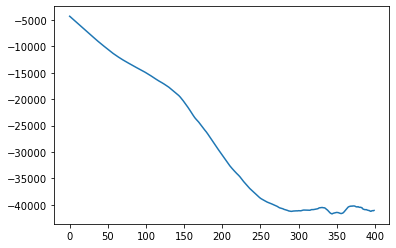

10
Epoch 0/20
5/5 [==============================] - trainLoss: -12726.7480  Val_loss: -1674572.1250 
Epoch 1/20
5/5 [==============================] - trainLoss: -13447.1953  Val_loss: -1730621.0000 
Epoch 2/20
5/5 [==============================] - trainLoss: -13439.8984  Val_loss: -1782881.1250 
Epoch 3/20
5/5 [==============================] - trainLoss: -13996.8057  Val_loss: -1831288.3750 
Epoch 4/20
5/5 [==============================] - trainLoss: -14762.7207  Val_loss: -1876415.0000 
Epoch 5/20
5/5 [==============================] - trainLoss: -15107.1963  Val_loss: -1917020.7500 
Epoch 6/20
5/5 [==============================] - trainLoss: -15377.6416  Val_loss: -1953246.0000 
Epoch 7/20
5/5 [==============================] - trainLoss: -15564.1748  Val_loss: -1986659.2500 
Epoch 8/20
5/5 [==============================] - trainLoss: -15934.2969  Val_loss: -2015079.1250 
Epoch 9/20
5/5 [==============================] - trainLoss: -16248.9629  Val_loss: -2039210.5000 
Epoch 1

5/5 [==============================] - trainLoss: -16.5700  Val_loss: -8530.1250 
Epoch 29/400
5/5 [==============================] - trainLoss: -18.9682  Val_loss: -8696.5137 
Epoch 30/400
5/5 [==============================] - trainLoss: -20.4071  Val_loss: -8864.9219 
Epoch 31/400
5/5 [==============================] - trainLoss: -18.2028  Val_loss: -9032.3633 
Epoch 32/400
5/5 [==============================] - trainLoss: -18.3442  Val_loss: -9198.5303 
Epoch 33/400
5/5 [==============================] - trainLoss: -20.3296  Val_loss: -9363.4141 
Epoch 34/400
5/5 [==============================] - trainLoss: -21.0054  Val_loss: -9527.1035 
Epoch 35/400
5/5 [==============================] - trainLoss: -24.6573  Val_loss: -9693.8535 
Epoch 36/400
5/5 [==============================] - trainLoss: -26.1024  Val_loss: -9862.3447 
Epoch 37/400
5/5 [==============================] - trainLoss: -27.5370  Val_loss: -10031.8115 
Epoch 38/400
5/5 [==============================] - trainLoss:

5/5 [==============================] - trainLoss: -42.8361  Val_loss: -12601.3242 
Epoch 54/400
5/5 [==============================] - trainLoss: -42.4755  Val_loss: -12754.8213 
Epoch 55/400
5/5 [==============================] - trainLoss: -44.1004  Val_loss: -12902.3262 
Epoch 56/400
5/5 [==============================] - trainLoss: -45.8108  Val_loss: -13050.3047 
Epoch 57/400
5/5 [==============================] - trainLoss: -45.8299  Val_loss: -13200.0430 
Epoch 58/400
5/5 [==============================] - trainLoss: -48.0635  Val_loss: -13356.3799 
Epoch 59/400
5/5 [==============================] - trainLoss: -50.0616  Val_loss: -13515.2363 
Epoch 60/400
5/5 [==============================] - trainLoss: -49.7317  Val_loss: -13673.7764 
Epoch 61/400
5/5 [==============================] - trainLoss: -52.2665  Val_loss: -13828.2197 
Epoch 62/400
5/5 [==============================] - trainLoss: -49.2775  Val_loss: -13979.1250 
Epoch 63/400
5/5 [==============================] - t

5/5 [==============================] - trainLoss: -67.0547  Val_loss: -16343.7744 
Epoch 79/400
5/5 [==============================] - trainLoss: -73.6689  Val_loss: -16491.2422 
Epoch 80/400
5/5 [==============================] - trainLoss: -70.7750  Val_loss: -16638.5527 
Epoch 81/400
5/5 [==============================] - trainLoss: -69.4972  Val_loss: -16784.8340 
Epoch 82/400
5/5 [==============================] - trainLoss: -69.6785  Val_loss: -16927.3691 
Epoch 83/400
5/5 [==============================] - trainLoss: -75.7405  Val_loss: -17071.8379 
Epoch 84/400
5/5 [==============================] - trainLoss: -73.7580  Val_loss: -17213.4062 
Epoch 85/400
5/5 [==============================] - trainLoss: -74.3808  Val_loss: -17355.3027 
Epoch 86/400
5/5 [==============================] - trainLoss: -72.8324  Val_loss: -17498.5879 
Epoch 87/400
5/5 [==============================] - trainLoss: -78.5016  Val_loss: -17641.8125 
Epoch 88/400
5/5 [==============================] - t

5/5 [==============================] - trainLoss: -92.5518  Val_loss: -19584.6914 
Epoch 104/400
5/5 [==============================] - trainLoss: -94.5923  Val_loss: -19713.9434 
Epoch 105/400
5/5 [==============================] - trainLoss: -93.5337  Val_loss: -19845.2598 
Epoch 106/400
5/5 [==============================] - trainLoss: -93.6773  Val_loss: -19972.5430 
Epoch 107/400
5/5 [==============================] - trainLoss: -94.9771  Val_loss: -20096.6934 
Epoch 108/400
5/5 [==============================] - trainLoss: -96.6525  Val_loss: -20224.8594 
Epoch 109/400
5/5 [==============================] - trainLoss: -97.6867  Val_loss: -20349.0234 
Epoch 110/400
5/5 [==============================] - trainLoss: -99.4937  Val_loss: -20464.9004 
Epoch 111/400
5/5 [==============================] - trainLoss: -97.6972  Val_loss: -20582.3438 
Epoch 112/400
5/5 [==============================] - trainLoss: -98.5284  Val_loss: -20698.1309 
Epoch 113/400
5/5 [=========================

5/5 [==============================] - trainLoss: -113.3690  Val_loss: -22565.6426 
Epoch 129/400
5/5 [==============================] - trainLoss: -115.2560  Val_loss: -22672.5645 
Epoch 130/400
5/5 [==============================] - trainLoss: -115.9757  Val_loss: -22779.9355 
Epoch 131/400
5/5 [==============================] - trainLoss: -118.2040  Val_loss: -22884.6816 
Epoch 132/400
5/5 [==============================] - trainLoss: -114.1042  Val_loss: -22987.0273 
Epoch 133/400
5/5 [==============================] - trainLoss: -116.5040  Val_loss: -23083.8496 
Epoch 134/400
5/5 [==============================] - trainLoss: -115.8307  Val_loss: -23182.2969 
Epoch 135/400
5/5 [==============================] - trainLoss: -118.7801  Val_loss: -23282.3730 
Epoch 136/400
5/5 [==============================] - trainLoss: -123.1279  Val_loss: -23380.1680 
Epoch 137/400
5/5 [==============================] - trainLoss: -118.9291  Val_loss: -23488.0391 
Epoch 138/400
5/5 [===============

5/5 [==============================] - trainLoss: -134.0459  Val_loss: -25205.2637 
Epoch 153/400
5/5 [==============================] - trainLoss: -131.2447  Val_loss: -25338.2422 
Epoch 154/400
5/5 [==============================] - trainLoss: -135.4106  Val_loss: -25487.7695 
Epoch 155/400
5/5 [==============================] - trainLoss: -136.3970  Val_loss: -25634.0254 
Epoch 156/400
5/5 [==============================] - trainLoss: -135.3626  Val_loss: -25785.7402 
Epoch 157/400
5/5 [==============================] - trainLoss: -138.5589  Val_loss: -25931.7402 
Epoch 158/400
5/5 [==============================] - trainLoss: -140.7489  Val_loss: -26079.1934 
Epoch 159/400
5/5 [==============================] - trainLoss: -139.9815  Val_loss: -26213.9414 
Epoch 160/400
5/5 [==============================] - trainLoss: -137.4689  Val_loss: -26362.5195 
Epoch 161/400
5/5 [==============================] - trainLoss: -144.7822  Val_loss: -26501.5918 
Epoch 162/400
5/5 [===============

5/5 [==============================] - trainLoss: -156.3951  Val_loss: -29043.7168 
Epoch 178/400
5/5 [==============================] - trainLoss: -155.1443  Val_loss: -29213.6758 
Epoch 179/400
5/5 [==============================] - trainLoss: -155.0462  Val_loss: -29386.2168 
Epoch 180/400
5/5 [==============================] - trainLoss: -156.7228  Val_loss: -29566.5938 
Epoch 181/400
5/5 [==============================] - trainLoss: -158.9743  Val_loss: -29761.3672 
Epoch 182/400
5/5 [==============================] - trainLoss: -158.2766  Val_loss: -29944.4824 
Epoch 183/400
5/5 [==============================] - trainLoss: -159.6652  Val_loss: -30141.3672 
Epoch 184/400
5/5 [==============================] - trainLoss: -161.4635  Val_loss: -30328.2637 
Epoch 185/400
5/5 [==============================] - trainLoss: -162.3088  Val_loss: -30520.6816 
Epoch 186/400
5/5 [==============================] - trainLoss: -163.6710  Val_loss: -30705.4492 
Epoch 187/400
5/5 [===============

5/5 [==============================] - trainLoss: -174.2437  Val_loss: -33611.8750 
Epoch 203/400
5/5 [==============================] - trainLoss: -174.9013  Val_loss: -33816.3203 
Epoch 204/400
5/5 [==============================] - trainLoss: -176.8992  Val_loss: -34025.3789 
Epoch 205/400
5/5 [==============================] - trainLoss: -175.9764  Val_loss: -34240.5430 
Epoch 206/400
5/5 [==============================] - trainLoss: -181.2605  Val_loss: -34459.8750 
Epoch 207/400
5/5 [==============================] - trainLoss: -181.5776  Val_loss: -34676.9727 
Epoch 208/400
5/5 [==============================] - trainLoss: -179.0166  Val_loss: -34888.2656 
Epoch 209/400
5/5 [==============================] - trainLoss: -184.3785  Val_loss: -35088.6523 
Epoch 210/400
5/5 [==============================] - trainLoss: -181.3269  Val_loss: -35265.9688 
Epoch 211/400
5/5 [==============================] - trainLoss: -184.9126  Val_loss: -35423.9688 
Epoch 212/400
5/5 [===============

5/5 [==============================] - trainLoss: -199.7674  Val_loss: -37942.9961 
Epoch 228/400
5/5 [==============================] - trainLoss: -199.4912  Val_loss: -38105.5039 
Epoch 229/400
5/5 [==============================] - trainLoss: -197.7842  Val_loss: -38244.1992 
Epoch 230/400
5/5 [==============================] - trainLoss: -198.8776  Val_loss: -38389.3750 
Epoch 231/400
5/5 [==============================] - trainLoss: -200.3672  Val_loss: -38521.4062 
Epoch 232/400
5/5 [==============================] - trainLoss: -204.1328  Val_loss: -38652.6562 
Epoch 233/400
5/5 [==============================] - trainLoss: -203.1888  Val_loss: -38781.2305 
Epoch 234/400
5/5 [==============================] - trainLoss: -204.1881  Val_loss: -38904.6094 
Epoch 235/400
5/5 [==============================] - trainLoss: -203.1720  Val_loss: -39030.3633 
Epoch 236/400
5/5 [==============================] - trainLoss: -209.4031  Val_loss: -39156.9727 
Epoch 237/400
5/5 [===============

5/5 [==============================] - trainLoss: -222.4900  Val_loss: -41094.4766 
Epoch 253/400
5/5 [==============================] - trainLoss: -224.5623  Val_loss: -41215.0117 
Epoch 254/400
5/5 [==============================] - trainLoss: -225.5921  Val_loss: -41332.1562 
Epoch 255/400
5/5 [==============================] - trainLoss: -225.6980  Val_loss: -41446.8789 
Epoch 256/400
5/5 [==============================] - trainLoss: -224.4764  Val_loss: -41558.0664 
Epoch 257/400
5/5 [==============================] - trainLoss: -226.6581  Val_loss: -41673.6914 
Epoch 258/400
5/5 [==============================] - trainLoss: -227.0672  Val_loss: -41778.4375 
Epoch 259/400
5/5 [==============================] - trainLoss: -225.1295  Val_loss: -41874.2227 
Epoch 260/400
5/5 [==============================] - trainLoss: -230.7878  Val_loss: -41975.3516 
Epoch 261/400
5/5 [==============================] - trainLoss: -230.5351  Val_loss: -42079.9922 
Epoch 262/400
5/5 [===============

5/5 [==============================] - trainLoss: -247.4115  Val_loss: -43528.7461 
Epoch 278/400
5/5 [==============================] - trainLoss: -248.9743  Val_loss: -43605.2695 
Epoch 279/400
5/5 [==============================] - trainLoss: -248.1776  Val_loss: -43663.5508 
Epoch 280/400
5/5 [==============================] - trainLoss: -247.5501  Val_loss: -43720.1680 
Epoch 281/400
5/5 [==============================] - trainLoss: -249.7333  Val_loss: -43770.0781 
Epoch 282/400
5/5 [==============================] - trainLoss: -255.6516  Val_loss: -43838.5273 
Epoch 283/400
5/5 [==============================] - trainLoss: -250.9078  Val_loss: -43905.4219 
Epoch 284/400
5/5 [==============================] - trainLoss: -252.3498  Val_loss: -43973.6719 
Epoch 285/400
5/5 [==============================] - trainLoss: -254.1347  Val_loss: -44033.8555 
Epoch 286/400
5/5 [==============================] - trainLoss: -256.4810  Val_loss: -44091.0391 
Epoch 287/400
5/5 [===============

5/5 [==============================] - trainLoss: -271.1305  Val_loss: -44919.1445 
Epoch 303/400
5/5 [==============================] - trainLoss: -278.5145  Val_loss: -44970.7891 
Epoch 304/400
5/5 [==============================] - trainLoss: -277.4113  Val_loss: -45015.6211 
Epoch 305/400
5/5 [==============================] - trainLoss: -278.0185  Val_loss: -45048.5547 
Epoch 306/400
5/5 [==============================] - trainLoss: -274.2259  Val_loss: -45061.0352 
Epoch 307/400
5/5 [==============================] - trainLoss: -283.0852  Val_loss: -45077.2617 
Epoch 308/400
5/5 [==============================] - trainLoss: -280.5090  Val_loss: -45083.4219 
Epoch 309/400
5/5 [==============================] - trainLoss: -282.0131  Val_loss: -45098.7695 
Epoch 310/400
5/5 [==============================] - trainLoss: -281.0045  Val_loss: -45107.7109 
Epoch 311/400
5/5 [==============================] - trainLoss: -282.6995  Val_loss: -45122.5000 
Epoch 312/400
5/5 [===============

5/5 [==============================] - trainLoss: -313.5566  Val_loss: -45423.5703 
Epoch 335/400
5/5 [==============================] - trainLoss: -308.7213  Val_loss: -45446.2344 
Epoch 336/400
5/5 [==============================] - trainLoss: -316.1353  Val_loss: -45470.3438 
Epoch 337/400
5/5 [==============================] - trainLoss: -313.2729  Val_loss: -45476.7031 
Epoch 338/400
5/5 [==============================] - trainLoss: -321.8232  Val_loss: -45493.6289 
Epoch 339/400
5/5 [==============================] - trainLoss: -324.2170  Val_loss: -45527.2969 
Epoch 340/400
5/5 [==============================] - trainLoss: -321.9751  Val_loss: -45557.3203 
Epoch 341/400
5/5 [==============================] - trainLoss: -323.4808  Val_loss: -45585.4492 
Epoch 342/400
5/5 [==============================] - trainLoss: -324.9151  Val_loss: -45593.1172 
Epoch 343/400
5/5 [==============================] - trainLoss: -324.3665  Val_loss: -45568.0703 
Epoch 344/400
5/5 [===============

5/5 [==============================] - trainLoss: -370.7625  Val_loss: -45794.6562 
Epoch 377/400
5/5 [==============================] - trainLoss: -373.6903  Val_loss: -45771.2305 
Epoch 378/400
5/5 [==============================] - trainLoss: -381.6671  Val_loss: -45752.7656 
Epoch 379/400
5/5 [==============================] - trainLoss: -377.6637  Val_loss: -45729.6641 
Epoch 380/400
5/5 [==============================] - trainLoss: -382.3098  Val_loss: -45718.9180 
Epoch 381/400
5/5 [==============================] - trainLoss: -382.2862  Val_loss: -45705.6172 
Epoch 382/400
5/5 [==============================] - trainLoss: -381.5058  Val_loss: -45698.1055 
Epoch 383/400
5/5 [==============================] - trainLoss: -379.6232  Val_loss: -45641.1172 
Epoch 384/400
5/5 [==============================] - trainLoss: -382.2359  Val_loss: -45558.1172 
Epoch 385/400
5/5 [==============================] - trainLoss: -386.7051  Val_loss: -45493.5938 
Epoch 386/400
5/5 [===============

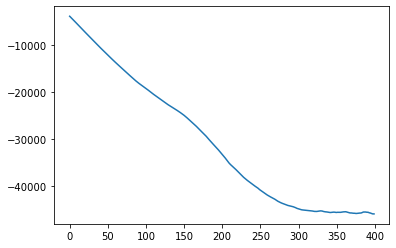

11
Epoch 0/20
5/5 [==============================] - trainLoss: -13446.2500  Val_loss: -1652582.0000 
Epoch 1/20
5/5 [==============================] - trainLoss: -13627.7676  Val_loss: -1688151.3750 
Epoch 2/20
5/5 [==============================] - trainLoss: -14327.0303  Val_loss: -1719908.7500 
Epoch 3/20
5/5 [==============================] - trainLoss: -14753.4844  Val_loss: -1746306.0000 
Epoch 4/20
5/5 [==============================] - trainLoss: -15080.0352  Val_loss: -1766632.0000 
Epoch 5/20
5/5 [==============================] - trainLoss: -15571.8701  Val_loss: -1781316.1250 
Epoch 6/20
5/5 [==============================] - trainLoss: -16021.7012  Val_loss: -1789955.8750 
Epoch 7/20
5/5 [==============================] - trainLoss: -16380.8232  Val_loss: -1792409.7500 
Epoch 8/20
5/5 [==============================] - trainLoss: -16984.6250  Val_loss: -1789085.7500 
Epoch 9/20
5/5 [==============================] - trainLoss: -17111.3750  Val_loss: -1780994.2500 
Epoch 1

5/5 [==============================] - trainLoss: -3.7887  Val_loss: -2666.2830 
Epoch 13/400
5/5 [==============================] - trainLoss: -5.0250  Val_loss: -2669.7986 
Epoch 14/400
5/5 [==============================] - trainLoss: -4.5243  Val_loss: -2669.9924 
Epoch 15/400
5/5 [==============================] - trainLoss: -8.1573  Val_loss: -2667.1794 
Epoch 16/400
5/5 [==============================] - trainLoss: -0.1840  Val_loss: -2659.5615 
Epoch 17/400
5/5 [==============================] - trainLoss: -10.3287  Val_loss: -2648.6226 
Epoch 18/400
5/5 [==============================] - trainLoss: -5.3602  Val_loss: -2633.5173 
Epoch 19/400
5/5 [==============================] - trainLoss: -9.3646  Val_loss: -2615.2708 
Epoch 20/400
5/5 [==============================] - trainLoss: -8.3279  Val_loss: -2593.5408 
Epoch 21/400
5/5 [==============================] - trainLoss: -9.9105  Val_loss: -2566.8289 
Epoch 22/400
5/5 [==============================] - trainLoss: -13.9560 

5/5 [==============================] - trainLoss: -147.7776  Val_loss: 72608.3125 
Epoch 177/400
5/5 [==============================] - trainLoss: -150.4781  Val_loss: 72779.1172 
Epoch 178/400
5/5 [==============================] - trainLoss: -152.8998  Val_loss: 72856.2109 
Epoch 179/400
5/5 [==============================] - trainLoss: -147.4881  Val_loss: 72891.5156 
Epoch 180/400
5/5 [==============================] - trainLoss: -157.4098  Val_loss: 73059.4453 
Epoch 181/400
5/5 [==============================] - trainLoss: -147.9933  Val_loss: 73184.0859 
Epoch 182/400
5/5 [==============================] - trainLoss: -155.7422  Val_loss: 73294.3125 
Epoch 183/400
5/5 [==============================] - trainLoss: -157.5060  Val_loss: 73422.0625 
Epoch 184/400
5/5 [==============================] - trainLoss: -157.2961  Val_loss: 73638.2578 
Epoch 185/400
5/5 [==============================] - trainLoss: -156.0513  Val_loss: 73836.5312 
Epoch 186/400
5/5 [=========================

5/5 [==============================] - trainLoss: -278.9173  Val_loss: -13061.3555 
Epoch 316/400
5/5 [==============================] - trainLoss: -279.7650  Val_loss: -13765.1348 
Epoch 317/400
5/5 [==============================] - trainLoss: -281.8806  Val_loss: -14488.8545 
Epoch 318/400
5/5 [==============================] - trainLoss: -282.9443  Val_loss: -15166.2881 
Epoch 319/400
5/5 [==============================] - trainLoss: -283.4825  Val_loss: -15857.0693 
Epoch 320/400
5/5 [==============================] - trainLoss: -290.1942  Val_loss: -16564.7637 
Epoch 321/400
5/5 [==============================] - trainLoss: -287.9106  Val_loss: -17217.0391 
Epoch 322/400
5/5 [==============================] - trainLoss: -284.3429  Val_loss: -18054.1973 
Epoch 323/400
5/5 [==============================] - trainLoss: -292.9110  Val_loss: -18903.8379 
Epoch 324/400
5/5 [==============================] - trainLoss: -287.9979  Val_loss: -19721.8867 
Epoch 325/400
5/5 [===============

5/5 [==============================] - trainLoss: -311.5076  Val_loss: -27192.7695 
Epoch 340/400
5/5 [==============================] - trainLoss: -310.4911  Val_loss: -27582.4434 
Epoch 341/400
5/5 [==============================] - trainLoss: -319.8732  Val_loss: -27855.8008 
Epoch 342/400
5/5 [==============================] - trainLoss: -315.3418  Val_loss: -28143.0098 
Epoch 343/400
5/5 [==============================] - trainLoss: -318.8840  Val_loss: -28332.2109 
Epoch 344/400
5/5 [==============================] - trainLoss: -317.5315  Val_loss: -28441.3164 
Epoch 345/400
5/5 [==============================] - trainLoss: -322.8262  Val_loss: -28680.2695 
Epoch 346/400
5/5 [==============================] - trainLoss: -320.8219  Val_loss: -28976.6719 
Epoch 347/400
5/5 [==============================] - trainLoss: -323.7383  Val_loss: -29232.4746 
Epoch 348/400
5/5 [==============================] - trainLoss: -326.1405  Val_loss: -29366.1719 
Epoch 349/400
5/5 [===============

5/5 [==============================] - trainLoss: -342.0933  Val_loss: -32876.1641 
Epoch 365/400
5/5 [==============================] - trainLoss: -345.8646  Val_loss: -32898.9883 
Epoch 366/400
5/5 [==============================] - trainLoss: -346.4534  Val_loss: -32894.7617 
Epoch 367/400
5/5 [==============================] - trainLoss: -350.4425  Val_loss: -33096.4727 
Epoch 368/400
5/5 [==============================] - trainLoss: -348.7310  Val_loss: -33387.2617 
Epoch 369/400
5/5 [==============================] - trainLoss: -354.9107  Val_loss: -33717.7695 
Epoch 370/400
5/5 [==============================] - trainLoss: -358.1238  Val_loss: -34153.7539 
Epoch 371/400
5/5 [==============================] - trainLoss: -357.8502  Val_loss: -34579.3633 
Epoch 372/400
5/5 [==============================] - trainLoss: -360.1542  Val_loss: -34756.1445 
Epoch 373/400
5/5 [==============================] - trainLoss: -363.6884  Val_loss: -35079.7891 
Epoch 374/400
5/5 [===============

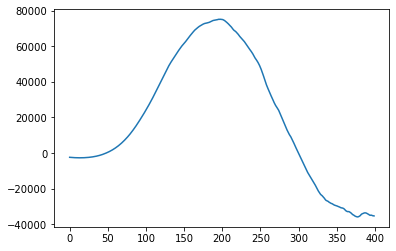

12
Epoch 0/20
5/5 [==============================] - trainLoss: -12408.7031  Val_loss: -1481260.2500 
Epoch 1/20
5/5 [==============================] - trainLoss: -12491.2969  Val_loss: -1533233.6250 
Epoch 2/20
5/5 [==============================] - trainLoss: -12987.2344  Val_loss: -1580787.1250 
Epoch 3/20
5/5 [==============================] - trainLoss: -13205.0859  Val_loss: -1627287.5000 
Epoch 4/20
5/5 [==============================] - trainLoss: -13751.7285  Val_loss: -1672352.8750 
Epoch 5/20
5/5 [==============================] - trainLoss: -14017.4551  Val_loss: -1715894.0000 
Epoch 6/20
5/5 [==============================] - trainLoss: -14128.3320  Val_loss: -1757177.1250 
Epoch 7/20
5/5 [==============================] - trainLoss: -14610.7422  Val_loss: -1794705.2500 
Epoch 8/20
5/5 [==============================] - trainLoss: -15140.8652  Val_loss: -1825939.3750 
Epoch 9/20
5/5 [==============================] - trainLoss: -15415.6602  Val_loss: -1851611.1250 
Epoch 1

5/5 [==============================] - trainLoss: 7.4634  Val_loss: -3646.6946 
Epoch 29/400
5/5 [==============================] - trainLoss: 4.9035  Val_loss: -3801.3555 
Epoch 30/400
5/5 [==============================] - trainLoss: 4.5496  Val_loss: -3954.3865 
Epoch 31/400
5/5 [==============================] - trainLoss: 1.3952  Val_loss: -4103.4121 
Epoch 32/400
5/5 [==============================] - trainLoss: 1.8597  Val_loss: -4251.0195 
Epoch 33/400
5/5 [==============================] - trainLoss: -0.9708  Val_loss: -4395.7207 
Epoch 34/400
5/5 [==============================] - trainLoss: 0.5496  Val_loss: -4539.3286 
Epoch 35/400
5/5 [==============================] - trainLoss: -3.9916  Val_loss: -4681.0752 
Epoch 36/400
5/5 [==============================] - trainLoss: -1.0425  Val_loss: -4822.3774 
Epoch 37/400
5/5 [==============================] - trainLoss: -3.7334  Val_loss: -4964.5601 
Epoch 38/400
5/5 [==============================] - trainLoss: -5.7796  Val_los

5/5 [==============================] - trainLoss: -24.2568  Val_loss: -7013.3398 
Epoch 55/400
5/5 [==============================] - trainLoss: -22.8285  Val_loss: -7105.4683 
Epoch 56/400
5/5 [==============================] - trainLoss: -23.1202  Val_loss: -7195.4976 
Epoch 57/400
5/5 [==============================] - trainLoss: -23.5084  Val_loss: -7279.8750 
Epoch 58/400
5/5 [==============================] - trainLoss: -27.0644  Val_loss: -7352.3794 
Epoch 59/400
5/5 [==============================] - trainLoss: -25.3352  Val_loss: -7419.5117 
Epoch 60/400
5/5 [==============================] - trainLoss: -24.9276  Val_loss: -7487.8999 
Epoch 61/400
5/5 [==============================] - trainLoss: -25.4601  Val_loss: -7559.6982 
Epoch 62/400
5/5 [==============================] - trainLoss: -27.8197  Val_loss: -7631.7437 
Epoch 63/400
5/5 [==============================] - trainLoss: -27.0569  Val_loss: -7699.8081 
Epoch 64/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -39.9017  Val_loss: -8243.3740 
Epoch 80/400
5/5 [==============================] - trainLoss: -42.2562  Val_loss: -8270.1768 
Epoch 81/400
5/5 [==============================] - trainLoss: -44.8374  Val_loss: -8293.7529 
Epoch 82/400
5/5 [==============================] - trainLoss: -45.4954  Val_loss: -8310.8193 
Epoch 83/400
5/5 [==============================] - trainLoss: -48.3359  Val_loss: -8319.5439 
Epoch 84/400
5/5 [==============================] - trainLoss: -48.0815  Val_loss: -8315.6826 
Epoch 85/400
5/5 [==============================] - trainLoss: -47.4688  Val_loss: -8312.0820 
Epoch 86/400
5/5 [==============================] - trainLoss: -52.3439  Val_loss: -8296.6631 
Epoch 87/400
5/5 [==============================] - trainLoss: -53.9484  Val_loss: -8269.9023 
Epoch 88/400
5/5 [==============================] - trainLoss: -51.4589  Val_loss: -8234.1396 
Epoch 89/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -132.5835  Val_loss: -12091.3418 
Epoch 186/400
5/5 [==============================] - trainLoss: -134.3341  Val_loss: -12299.1279 
Epoch 187/400
5/5 [==============================] - trainLoss: -131.7057  Val_loss: -12504.2588 
Epoch 188/400
5/5 [==============================] - trainLoss: -132.9726  Val_loss: -12707.3193 
Epoch 189/400
5/5 [==============================] - trainLoss: -135.1403  Val_loss: -12935.6543 
Epoch 190/400
5/5 [==============================] - trainLoss: -138.1457  Val_loss: -13168.2637 
Epoch 191/400
5/5 [==============================] - trainLoss: -135.5706  Val_loss: -13406.0264 
Epoch 192/400
5/5 [==============================] - trainLoss: -138.6073  Val_loss: -13661.1465 
Epoch 193/400
5/5 [==============================] - trainLoss: -137.3724  Val_loss: -13911.9004 
Epoch 194/400
5/5 [==============================] - trainLoss: -141.6268  Val_loss: -14158.3848 
Epoch 195/400
5/5 [===============

5/5 [==============================] - trainLoss: -152.0032  Val_loss: -18978.5059 
Epoch 211/400
5/5 [==============================] - trainLoss: -151.5068  Val_loss: -19257.6582 
Epoch 212/400
5/5 [==============================] - trainLoss: -153.1269  Val_loss: -19498.3242 
Epoch 213/400
5/5 [==============================] - trainLoss: -156.4550  Val_loss: -19727.2949 
Epoch 214/400
5/5 [==============================] - trainLoss: -154.9713  Val_loss: -19940.7090 
Epoch 215/400
5/5 [==============================] - trainLoss: -157.5941  Val_loss: -20145.7676 
Epoch 216/400
5/5 [==============================] - trainLoss: -158.4201  Val_loss: -20346.2129 
Epoch 217/400
5/5 [==============================] - trainLoss: -159.5269  Val_loss: -20569.4766 
Epoch 218/400
5/5 [==============================] - trainLoss: -159.0522  Val_loss: -20793.6406 
Epoch 219/400
5/5 [==============================] - trainLoss: -159.9767  Val_loss: -21020.6152 
Epoch 220/400
5/5 [===============

5/5 [==============================] - trainLoss: -174.9230  Val_loss: -25661.8516 
Epoch 236/400
5/5 [==============================] - trainLoss: -173.1083  Val_loss: -25979.6328 
Epoch 237/400
5/5 [==============================] - trainLoss: -176.8765  Val_loss: -26281.3887 
Epoch 238/400
5/5 [==============================] - trainLoss: -177.3639  Val_loss: -26589.4141 
Epoch 239/400
5/5 [==============================] - trainLoss: -178.6866  Val_loss: -26875.2266 
Epoch 240/400
5/5 [==============================] - trainLoss: -178.1172  Val_loss: -27147.1582 
Epoch 241/400
5/5 [==============================] - trainLoss: -179.6860  Val_loss: -27430.1094 
Epoch 242/400
5/5 [==============================] - trainLoss: -180.9232  Val_loss: -27686.4258 
Epoch 243/400
5/5 [==============================] - trainLoss: -179.6760  Val_loss: -27956.4492 
Epoch 244/400
5/5 [==============================] - trainLoss: -182.6172  Val_loss: -28229.6328 
Epoch 245/400
5/5 [===============

5/5 [==============================] - trainLoss: -196.7399  Val_loss: -31975.8027 
Epoch 261/400
5/5 [==============================] - trainLoss: -198.0001  Val_loss: -32237.7852 
Epoch 262/400
5/5 [==============================] - trainLoss: -199.8120  Val_loss: -32512.9941 
Epoch 263/400
5/5 [==============================] - trainLoss: -199.8703  Val_loss: -32777.3984 
Epoch 264/400
5/5 [==============================] - trainLoss: -200.9840  Val_loss: -33037.7773 
Epoch 265/400
5/5 [==============================] - trainLoss: -202.1545  Val_loss: -33274.4609 
Epoch 266/400
5/5 [==============================] - trainLoss: -201.9667  Val_loss: -33492.8984 
Epoch 267/400
5/5 [==============================] - trainLoss: -203.2740  Val_loss: -33721.0156 
Epoch 268/400
5/5 [==============================] - trainLoss: -205.0002  Val_loss: -33937.4688 
Epoch 269/400
5/5 [==============================] - trainLoss: -206.0203  Val_loss: -34156.8438 
Epoch 270/400
5/5 [===============

5/5 [==============================] - trainLoss: -223.8399  Val_loss: -36716.5117 
Epoch 286/400
5/5 [==============================] - trainLoss: -223.5268  Val_loss: -36887.0781 
Epoch 287/400
5/5 [==============================] - trainLoss: -222.6144  Val_loss: -37063.1055 
Epoch 288/400
5/5 [==============================] - trainLoss: -225.0392  Val_loss: -37238.0703 
Epoch 289/400
5/5 [==============================] - trainLoss: -227.1140  Val_loss: -37402.8359 
Epoch 290/400
5/5 [==============================] - trainLoss: -226.4045  Val_loss: -37572.8633 
Epoch 291/400
5/5 [==============================] - trainLoss: -228.0416  Val_loss: -37735.7109 
Epoch 292/400
5/5 [==============================] - trainLoss: -227.4971  Val_loss: -37897.5469 
Epoch 293/400
5/5 [==============================] - trainLoss: -230.4705  Val_loss: -38043.7969 
Epoch 294/400
5/5 [==============================] - trainLoss: -231.9741  Val_loss: -38180.3320 
Epoch 295/400
5/5 [===============

5/5 [==============================] - trainLoss: -247.5656  Val_loss: -39956.8555 
Epoch 311/400
5/5 [==============================] - trainLoss: -250.0556  Val_loss: -40075.8438 
Epoch 312/400
5/5 [==============================] - trainLoss: -250.5263  Val_loss: -40195.0352 
Epoch 313/400
5/5 [==============================] - trainLoss: -253.0142  Val_loss: -40307.6680 
Epoch 314/400
5/5 [==============================] - trainLoss: -254.2821  Val_loss: -40423.8633 
Epoch 315/400
5/5 [==============================] - trainLoss: -255.5387  Val_loss: -40528.1953 
Epoch 316/400
5/5 [==============================] - trainLoss: -255.4047  Val_loss: -40648.8672 
Epoch 317/400
5/5 [==============================] - trainLoss: -257.0834  Val_loss: -40754.8750 
Epoch 318/400
5/5 [==============================] - trainLoss: -256.5566  Val_loss: -40860.7891 
Epoch 319/400
5/5 [==============================] - trainLoss: -259.4608  Val_loss: -40973.1289 
Epoch 320/400
5/5 [===============

5/5 [==============================] - trainLoss: -279.5164  Val_loss: -42000.5000 
Epoch 336/400
5/5 [==============================] - trainLoss: -277.6010  Val_loss: -42043.5820 
Epoch 337/400
5/5 [==============================] - trainLoss: -278.8177  Val_loss: -42073.5000 
Epoch 338/400
5/5 [==============================] - trainLoss: -280.6901  Val_loss: -42108.2539 
Epoch 339/400
5/5 [==============================] - trainLoss: -282.0451  Val_loss: -42145.5859 
Epoch 340/400
5/5 [==============================] - trainLoss: -284.7719  Val_loss: -42211.3438 
Epoch 341/400
5/5 [==============================] - trainLoss: -287.8507  Val_loss: -42294.4648 
Epoch 342/400
5/5 [==============================] - trainLoss: -289.3854  Val_loss: -42370.9141 
Epoch 343/400
5/5 [==============================] - trainLoss: -286.6765  Val_loss: -42466.6797 
Epoch 344/400
5/5 [==============================] - trainLoss: -291.4840  Val_loss: -42558.6133 
Epoch 345/400
5/5 [===============

5/5 [==============================] - trainLoss: -331.8349  Val_loss: -43126.2109 
Epoch 372/400
5/5 [==============================] - trainLoss: -329.6812  Val_loss: -43118.8438 
Epoch 373/400
5/5 [==============================] - trainLoss: -331.1321  Val_loss: -43120.3633 
Epoch 374/400
5/5 [==============================] - trainLoss: -333.6902  Val_loss: -43141.8867 
Epoch 375/400
5/5 [==============================] - trainLoss: -335.8842  Val_loss: -43159.6836 
Epoch 376/400
5/5 [==============================] - trainLoss: -337.9045  Val_loss: -43186.8359 
Epoch 377/400
5/5 [==============================] - trainLoss: -338.4277  Val_loss: -43266.1719 
Epoch 378/400
5/5 [==============================] - trainLoss: -341.0287  Val_loss: -43369.3789 
Epoch 379/400
5/5 [==============================] - trainLoss: -341.2321  Val_loss: -43485.6875 
Epoch 380/400
5/5 [==============================] - trainLoss: -343.6562  Val_loss: -43582.8477 
Epoch 381/400
5/5 [===============

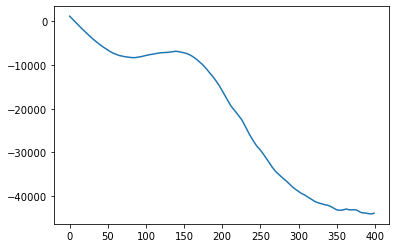

13
Epoch 0/20
5/5 [==============================] - trainLoss: -12554.4482  Val_loss: -1522839.3750 
Epoch 1/20
5/5 [==============================] - trainLoss: -13003.1406  Val_loss: -1571708.8750 
Epoch 2/20
5/5 [==============================] - trainLoss: -13472.1445  Val_loss: -1619803.8750 
Epoch 3/20
5/5 [==============================] - trainLoss: -13701.9395  Val_loss: -1667516.7500 
Epoch 4/20
5/5 [==============================] - trainLoss: -14397.0898  Val_loss: -1710909.3750 
Epoch 5/20
5/5 [==============================] - trainLoss: -14673.8721  Val_loss: -1751409.0000 
Epoch 6/20
5/5 [==============================] - trainLoss: -14896.8809  Val_loss: -1789368.6250 
Epoch 7/20
5/5 [==============================] - trainLoss: -15496.0508  Val_loss: -1823106.7500 
Epoch 8/20
5/5 [==============================] - trainLoss: -15721.7695  Val_loss: -1853204.3750 
Epoch 9/20
5/5 [==============================] - trainLoss: -16237.1475  Val_loss: -1878265.6250 
Epoch 1

5/5 [==============================] - trainLoss: -27.6500  Val_loss: -4958.9541 
Epoch 29/400
5/5 [==============================] - trainLoss: -27.1780  Val_loss: -5066.9395 
Epoch 30/400
5/5 [==============================] - trainLoss: -27.9250  Val_loss: -5175.5435 
Epoch 31/400
5/5 [==============================] - trainLoss: -28.2893  Val_loss: -5288.7871 
Epoch 32/400
5/5 [==============================] - trainLoss: -30.3083  Val_loss: -5401.0522 
Epoch 33/400
5/5 [==============================] - trainLoss: -32.2282  Val_loss: -5511.2646 
Epoch 34/400
5/5 [==============================] - trainLoss: -34.1783  Val_loss: -5614.5132 
Epoch 35/400
5/5 [==============================] - trainLoss: -33.0993  Val_loss: -5717.7026 
Epoch 36/400
5/5 [==============================] - trainLoss: -32.6592  Val_loss: -5824.0444 
Epoch 37/400
5/5 [==============================] - trainLoss: -35.7787  Val_loss: -5924.6685 
Epoch 38/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -53.4553  Val_loss: -7322.5171 
Epoch 54/400
5/5 [==============================] - trainLoss: -53.8854  Val_loss: -7387.9785 
Epoch 55/400
5/5 [==============================] - trainLoss: -55.8781  Val_loss: -7448.5122 
Epoch 56/400
5/5 [==============================] - trainLoss: -55.8226  Val_loss: -7505.7314 
Epoch 57/400
5/5 [==============================] - trainLoss: -58.1514  Val_loss: -7561.6665 
Epoch 58/400
5/5 [==============================] - trainLoss: -59.7016  Val_loss: -7616.3252 
Epoch 59/400
5/5 [==============================] - trainLoss: -57.0125  Val_loss: -7670.5835 
Epoch 60/400
5/5 [==============================] - trainLoss: -59.2669  Val_loss: -7720.6475 
Epoch 61/400
5/5 [==============================] - trainLoss: -60.2388  Val_loss: -7765.5566 
Epoch 62/400
5/5 [==============================] - trainLoss: -60.5951  Val_loss: -7806.8726 
Epoch 63/400
5/5 [==============================] - trainLoss: 

5/5 [==============================] - trainLoss: -143.8505  Val_loss: -8444.4678 
Epoch 167/400
5/5 [==============================] - trainLoss: -145.1802  Val_loss: -8578.8701 
Epoch 168/400
5/5 [==============================] - trainLoss: -146.1400  Val_loss: -8728.7949 
Epoch 169/400
5/5 [==============================] - trainLoss: -146.0461  Val_loss: -8874.1416 
Epoch 170/400
5/5 [==============================] - trainLoss: -148.8777  Val_loss: -9025.2861 
Epoch 171/400
5/5 [==============================] - trainLoss: -147.9970  Val_loss: -9186.5547 
Epoch 172/400
5/5 [==============================] - trainLoss: -149.7441  Val_loss: -9354.4424 
Epoch 173/400
5/5 [==============================] - trainLoss: -149.9301  Val_loss: -9545.5400 
Epoch 174/400
5/5 [==============================] - trainLoss: -150.1093  Val_loss: -9728.8350 
Epoch 175/400
5/5 [==============================] - trainLoss: -150.9063  Val_loss: -9898.1699 
Epoch 176/400
5/5 [=========================

5/5 [==============================] - trainLoss: -164.0868  Val_loss: -12481.3848 
Epoch 192/400
5/5 [==============================] - trainLoss: -166.6473  Val_loss: -12666.7568 
Epoch 193/400
5/5 [==============================] - trainLoss: -164.1221  Val_loss: -12847.5156 
Epoch 194/400
5/5 [==============================] - trainLoss: -165.6787  Val_loss: -13031.1904 
Epoch 195/400
5/5 [==============================] - trainLoss: -167.6872  Val_loss: -13203.1094 
Epoch 196/400
5/5 [==============================] - trainLoss: -166.8342  Val_loss: -13385.3154 
Epoch 197/400
5/5 [==============================] - trainLoss: -167.7772  Val_loss: -13583.8633 
Epoch 198/400
5/5 [==============================] - trainLoss: -169.2550  Val_loss: -13777.7510 
Epoch 199/400
5/5 [==============================] - trainLoss: -169.7720  Val_loss: -13989.0469 
Epoch 200/400
5/5 [==============================] - trainLoss: -172.3934  Val_loss: -14217.0078 
Epoch 201/400
5/5 [===============

5/5 [==============================] - trainLoss: -183.4696  Val_loss: -17285.5938 
Epoch 216/400
5/5 [==============================] - trainLoss: -184.0931  Val_loss: -17488.5703 
Epoch 217/400
5/5 [==============================] - trainLoss: -186.0886  Val_loss: -17754.3613 
Epoch 218/400
5/5 [==============================] - trainLoss: -186.2413  Val_loss: -17994.2109 
Epoch 219/400
5/5 [==============================] - trainLoss: -187.2939  Val_loss: -18252.2734 
Epoch 220/400
5/5 [==============================] - trainLoss: -188.3395  Val_loss: -18500.5684 
Epoch 221/400
5/5 [==============================] - trainLoss: -189.6587  Val_loss: -18708.0977 
Epoch 222/400
5/5 [==============================] - trainLoss: -190.1538  Val_loss: -18921.0820 
Epoch 223/400
5/5 [==============================] - trainLoss: -191.3285  Val_loss: -19116.8594 
Epoch 224/400
5/5 [==============================] - trainLoss: -191.3385  Val_loss: -19319.9629 
Epoch 225/400
5/5 [===============

5/5 [==============================] - trainLoss: -207.6941  Val_loss: -23460.5820 
Epoch 241/400
5/5 [==============================] - trainLoss: -206.3295  Val_loss: -23705.4238 
Epoch 242/400
5/5 [==============================] - trainLoss: -209.2945  Val_loss: -23959.5508 
Epoch 243/400
5/5 [==============================] - trainLoss: -207.9496  Val_loss: -24240.7773 
Epoch 244/400
5/5 [==============================] - trainLoss: -210.6259  Val_loss: -24510.2227 
Epoch 245/400
5/5 [==============================] - trainLoss: -212.1033  Val_loss: -24795.8164 
Epoch 246/400
5/5 [==============================] - trainLoss: -212.1228  Val_loss: -25086.6738 
Epoch 247/400
5/5 [==============================] - trainLoss: -212.4890  Val_loss: -25367.3184 
Epoch 248/400
5/5 [==============================] - trainLoss: -214.6431  Val_loss: -25665.4316 
Epoch 249/400
5/5 [==============================] - trainLoss: -213.6944  Val_loss: -25945.1113 
Epoch 250/400
5/5 [===============

5/5 [==============================] - trainLoss: -230.8888  Val_loss: -30038.8398 
Epoch 266/400
5/5 [==============================] - trainLoss: -231.5142  Val_loss: -30234.1973 
Epoch 267/400
5/5 [==============================] - trainLoss: -232.9354  Val_loss: -30424.1426 
Epoch 268/400
5/5 [==============================] - trainLoss: -232.6877  Val_loss: -30608.7402 
Epoch 269/400
5/5 [==============================] - trainLoss: -234.0336  Val_loss: -30784.8320 
Epoch 270/400
5/5 [==============================] - trainLoss: -237.0443  Val_loss: -30977.9609 
Epoch 271/400
5/5 [==============================] - trainLoss: -236.9571  Val_loss: -31196.5918 
Epoch 272/400
5/5 [==============================] - trainLoss: -238.5323  Val_loss: -31415.4277 
Epoch 273/400
5/5 [==============================] - trainLoss: -239.1703  Val_loss: -31673.6426 
Epoch 274/400
5/5 [==============================] - trainLoss: -240.4837  Val_loss: -31929.3496 
Epoch 275/400
5/5 [===============

5/5 [==============================] - trainLoss: -258.7593  Val_loss: -35463.3359 
Epoch 291/400
5/5 [==============================] - trainLoss: -259.5548  Val_loss: -35644.6133 
Epoch 292/400
5/5 [==============================] - trainLoss: -259.7426  Val_loss: -35821.5508 
Epoch 293/400
5/5 [==============================] - trainLoss: -260.3810  Val_loss: -35974.4102 
Epoch 294/400
5/5 [==============================] - trainLoss: -261.5670  Val_loss: -36162.7617 
Epoch 295/400
5/5 [==============================] - trainLoss: -264.4257  Val_loss: -36383.2461 
Epoch 296/400
5/5 [==============================] - trainLoss: -265.1956  Val_loss: -36617.4844 
Epoch 297/400
5/5 [==============================] - trainLoss: -266.2577  Val_loss: -36841.4727 
Epoch 298/400
5/5 [==============================] - trainLoss: -267.8891  Val_loss: -37073.6641 
Epoch 299/400
5/5 [==============================] - trainLoss: -267.3837  Val_loss: -37285.3711 
Epoch 300/400
5/5 [===============

5/5 [==============================] - trainLoss: -287.3094  Val_loss: -39270.1172 
Epoch 316/400
5/5 [==============================] - trainLoss: -288.6093  Val_loss: -39338.2148 
Epoch 317/400
5/5 [==============================] - trainLoss: -291.0027  Val_loss: -39420.2539 
Epoch 318/400
5/5 [==============================] - trainLoss: -289.9607  Val_loss: -39491.3867 
Epoch 319/400
5/5 [==============================] - trainLoss: -294.0797  Val_loss: -39557.9102 
Epoch 320/400
5/5 [==============================] - trainLoss: -295.1846  Val_loss: -39631.5273 
Epoch 321/400
5/5 [==============================] - trainLoss: -295.3925  Val_loss: -39684.8086 
Epoch 322/400
5/5 [==============================] - trainLoss: -296.5873  Val_loss: -39689.7539 
Epoch 323/400
5/5 [==============================] - trainLoss: -297.6013  Val_loss: -39660.7617 
Epoch 324/400
5/5 [==============================] - trainLoss: -299.5246  Val_loss: -39658.2266 
Epoch 325/400
5/5 [===============

5/5 [==============================] - trainLoss: -340.4471  Val_loss: -41153.7500 
Epoch 352/400
5/5 [==============================] - trainLoss: -338.2411  Val_loss: -41194.0195 
Epoch 353/400
5/5 [==============================] - trainLoss: -341.7601  Val_loss: -41253.8320 
Epoch 354/400
5/5 [==============================] - trainLoss: -342.9897  Val_loss: -41313.0977 
Epoch 355/400
5/5 [==============================] - trainLoss: -345.8572  Val_loss: -41380.5508 
Epoch 356/400
5/5 [==============================] - trainLoss: -345.2124  Val_loss: -41401.5625 
Epoch 357/400
5/5 [==============================] - trainLoss: -348.1926  Val_loss: -41512.5234 
Epoch 358/400
5/5 [==============================] - trainLoss: -349.3566  Val_loss: -41687.5078 
Epoch 359/400
5/5 [==============================] - trainLoss: -351.5510  Val_loss: -41854.7891 
Epoch 360/400
5/5 [==============================] - trainLoss: -353.9686  Val_loss: -42014.0312 
Epoch 361/400
5/5 [===============

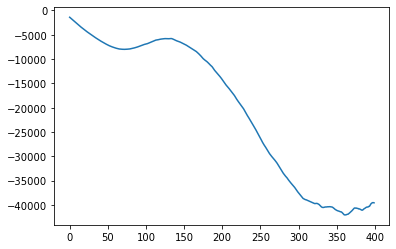

14
Epoch 0/20
5/5 [==============================] - trainLoss: -11836.3242  Val_loss: -1564522.0000 
Epoch 1/20
5/5 [==============================] - trainLoss: -12257.2695  Val_loss: -1632893.7500 
Epoch 2/20
5/5 [==============================] - trainLoss: -12768.8018  Val_loss: -1698082.5000 
Epoch 3/20
5/5 [==============================] - trainLoss: -13171.1748  Val_loss: -1758770.6250 
Epoch 4/20
5/5 [==============================] - trainLoss: -13654.3008  Val_loss: -1812604.2500 
Epoch 5/20
5/5 [==============================] - trainLoss: -14130.0146  Val_loss: -1857988.1250 
Epoch 6/20
5/5 [==============================] - trainLoss: -14528.2988  Val_loss: -1895442.5000 
Epoch 7/20
5/5 [==============================] - trainLoss: -14811.7842  Val_loss: -1924370.7500 
Epoch 8/20
5/5 [==============================] - trainLoss: -15137.8750  Val_loss: -1944938.7500 
Epoch 9/20
5/5 [==============================] - trainLoss: -15555.4961  Val_loss: -1959160.3750 
Epoch 1

5/5 [==============================] - trainLoss: 11.6693  Val_loss: -3584.5679 
Epoch 7/400
5/5 [==============================] - trainLoss: 6.9727  Val_loss: -3783.6479 
Epoch 8/400
5/5 [==============================] - trainLoss: 20.1136  Val_loss: -3983.2148 
Epoch 9/400
5/5 [==============================] - trainLoss: 5.0589  Val_loss: -4180.4453 
Epoch 10/400
5/5 [==============================] - trainLoss: 16.5025  Val_loss: -4378.3506 
Epoch 11/400
5/5 [==============================] - trainLoss: 9.0237  Val_loss: -4576.4370 
Epoch 12/400
5/5 [==============================] - trainLoss: 11.9496  Val_loss: -4774.7964 
Epoch 13/400
5/5 [==============================] - trainLoss: 6.3189  Val_loss: -4971.4985 
Epoch 14/400
5/5 [==============================] - trainLoss: 4.5914  Val_loss: -5165.6401 
Epoch 15/400
5/5 [==============================] - trainLoss: -0.8949  Val_loss: -5358.5771 
Epoch 16/400
5/5 [==============================] - trainLoss: -1.2285  Val_loss:

5/5 [==============================] - trainLoss: -40.6011  Val_loss: -11449.7295 
Epoch 57/400
5/5 [==============================] - trainLoss: -42.1384  Val_loss: -11524.9180 
Epoch 58/400
5/5 [==============================] - trainLoss: -46.4672  Val_loss: -11594.3994 
Epoch 59/400
5/5 [==============================] - trainLoss: -40.8430  Val_loss: -11661.8613 
Epoch 60/400
5/5 [==============================] - trainLoss: -51.2507  Val_loss: -11722.7080 
Epoch 61/400
5/5 [==============================] - trainLoss: -48.0459  Val_loss: -11774.9873 
Epoch 62/400
5/5 [==============================] - trainLoss: -51.5149  Val_loss: -11821.1133 
Epoch 63/400
5/5 [==============================] - trainLoss: -49.2704  Val_loss: -11864.9414 
Epoch 64/400
5/5 [==============================] - trainLoss: -48.7092  Val_loss: -11905.0039 
Epoch 65/400
5/5 [==============================] - trainLoss: -43.6945  Val_loss: -11942.1328 
Epoch 66/400
5/5 [==============================] - t

5/5 [==============================] - trainLoss: -145.1581  Val_loss: -6863.8916 
Epoch 176/400
5/5 [==============================] - trainLoss: -139.7311  Val_loss: -6867.2617 
Epoch 177/400
5/5 [==============================] - trainLoss: -135.4212  Val_loss: -6889.1479 
Epoch 178/400
5/5 [==============================] - trainLoss: -145.3810  Val_loss: -6910.1826 
Epoch 179/400
5/5 [==============================] - trainLoss: -145.7943  Val_loss: -6934.6118 
Epoch 180/400
5/5 [==============================] - trainLoss: -139.3003  Val_loss: -6986.8799 
Epoch 181/400
5/5 [==============================] - trainLoss: -139.9839  Val_loss: -7064.1924 
Epoch 182/400
5/5 [==============================] - trainLoss: -149.3335  Val_loss: -7150.2603 
Epoch 183/400
5/5 [==============================] - trainLoss: -144.5693  Val_loss: -7254.7002 
Epoch 184/400
5/5 [==============================] - trainLoss: -144.4112  Val_loss: -7384.2954 
Epoch 185/400
5/5 [=========================

5/5 [==============================] - trainLoss: -183.0999  Val_loss: -15305.0449 
Epoch 229/400
5/5 [==============================] - trainLoss: -186.5990  Val_loss: -15607.8135 
Epoch 230/400
5/5 [==============================] - trainLoss: -183.6931  Val_loss: -15933.5713 
Epoch 231/400
5/5 [==============================] - trainLoss: -188.2729  Val_loss: -16264.8076 
Epoch 232/400
5/5 [==============================] - trainLoss: -186.8123  Val_loss: -16594.3691 
Epoch 233/400
5/5 [==============================] - trainLoss: -189.3784  Val_loss: -16924.2559 
Epoch 234/400
5/5 [==============================] - trainLoss: -190.6186  Val_loss: -17260.5625 
Epoch 235/400
5/5 [==============================] - trainLoss: -194.5179  Val_loss: -17564.5117 
Epoch 236/400
5/5 [==============================] - trainLoss: -193.1636  Val_loss: -17875.6055 
Epoch 237/400
5/5 [==============================] - trainLoss: -191.6272  Val_loss: -18198.6875 
Epoch 238/400
5/5 [===============

5/5 [==============================] - trainLoss: -205.4093  Val_loss: -23012.9824 
Epoch 254/400
5/5 [==============================] - trainLoss: -211.2141  Val_loss: -23357.3164 
Epoch 255/400
5/5 [==============================] - trainLoss: -211.4426  Val_loss: -23714.8672 
Epoch 256/400
5/5 [==============================] - trainLoss: -209.8271  Val_loss: -24094.0254 
Epoch 257/400
5/5 [==============================] - trainLoss: -216.9026  Val_loss: -24456.4844 
Epoch 258/400
5/5 [==============================] - trainLoss: -215.4862  Val_loss: -24826.6504 
Epoch 259/400
5/5 [==============================] - trainLoss: -213.6066  Val_loss: -25154.7910 
Epoch 260/400
5/5 [==============================] - trainLoss: -212.1623  Val_loss: -25435.6660 
Epoch 261/400
5/5 [==============================] - trainLoss: -219.9917  Val_loss: -25723.5508 
Epoch 262/400
5/5 [==============================] - trainLoss: -218.8540  Val_loss: -26031.8906 
Epoch 263/400
5/5 [===============

5/5 [==============================] - trainLoss: -232.4668  Val_loss: -30321.1387 
Epoch 279/400
5/5 [==============================] - trainLoss: -236.6630  Val_loss: -30561.9395 
Epoch 280/400
5/5 [==============================] - trainLoss: -240.9924  Val_loss: -30793.5488 
Epoch 281/400
5/5 [==============================] - trainLoss: -238.2567  Val_loss: -31021.2598 
Epoch 282/400
5/5 [==============================] - trainLoss: -235.2607  Val_loss: -31257.1172 
Epoch 283/400
5/5 [==============================] - trainLoss: -242.0630  Val_loss: -31469.4668 
Epoch 284/400
5/5 [==============================] - trainLoss: -240.7537  Val_loss: -31675.8887 
Epoch 285/400
5/5 [==============================] - trainLoss: -245.0965  Val_loss: -31882.5859 
Epoch 286/400
5/5 [==============================] - trainLoss: -245.1467  Val_loss: -32110.2324 
Epoch 287/400
5/5 [==============================] - trainLoss: -241.4199  Val_loss: -32385.5488 
Epoch 288/400
5/5 [===============

5/5 [==============================] - trainLoss: -258.9857  Val_loss: -35948.6445 
Epoch 304/400
5/5 [==============================] - trainLoss: -263.2643  Val_loss: -36097.4727 
Epoch 305/400
5/5 [==============================] - trainLoss: -265.1522  Val_loss: -36220.5547 
Epoch 306/400
5/5 [==============================] - trainLoss: -270.6613  Val_loss: -36338.1680 
Epoch 307/400
5/5 [==============================] - trainLoss: -267.6270  Val_loss: -36469.2227 
Epoch 308/400
5/5 [==============================] - trainLoss: -263.3074  Val_loss: -36618.3711 
Epoch 309/400
5/5 [==============================] - trainLoss: -270.5213  Val_loss: -36763.4062 
Epoch 310/400
5/5 [==============================] - trainLoss: -270.5641  Val_loss: -36916.4180 
Epoch 311/400
5/5 [==============================] - trainLoss: -275.0172  Val_loss: -37062.7461 
Epoch 312/400
5/5 [==============================] - trainLoss: -275.8843  Val_loss: -37201.2969 
Epoch 313/400
5/5 [===============

5/5 [==============================] - trainLoss: -295.0803  Val_loss: -39323.8320 
Epoch 329/400
5/5 [==============================] - trainLoss: -294.4847  Val_loss: -39397.7227 
Epoch 330/400
5/5 [==============================] - trainLoss: -294.3584  Val_loss: -39481.6055 
Epoch 331/400
5/5 [==============================] - trainLoss: -298.9814  Val_loss: -39562.9297 
Epoch 332/400
5/5 [==============================] - trainLoss: -299.4480  Val_loss: -39645.3945 
Epoch 333/400
5/5 [==============================] - trainLoss: -302.2870  Val_loss: -39727.2188 
Epoch 334/400
5/5 [==============================] - trainLoss: -301.9947  Val_loss: -39795.2734 
Epoch 335/400
5/5 [==============================] - trainLoss: -303.2750  Val_loss: -39889.8984 
Epoch 336/400
5/5 [==============================] - trainLoss: -305.9581  Val_loss: -39984.9961 
Epoch 337/400
5/5 [==============================] - trainLoss: -304.9220  Val_loss: -40083.6719 
Epoch 338/400
5/5 [===============

5/5 [==============================] - trainLoss: -336.2798  Val_loss: -41147.0430 
Epoch 359/400
5/5 [==============================] - trainLoss: -340.9628  Val_loss: -41281.6836 
Epoch 360/400
5/5 [==============================] - trainLoss: -338.4843  Val_loss: -41391.5859 
Epoch 361/400
5/5 [==============================] - trainLoss: -336.8017  Val_loss: -41469.3633 
Epoch 362/400
5/5 [==============================] - trainLoss: -343.2370  Val_loss: -41555.0703 
Epoch 363/400
5/5 [==============================] - trainLoss: -338.3646  Val_loss: -41635.8945 
Epoch 364/400
5/5 [==============================] - trainLoss: -340.2474  Val_loss: -41674.7227 
Epoch 365/400
5/5 [==============================] - trainLoss: -343.5350  Val_loss: -41747.1094 
Epoch 366/400
5/5 [==============================] - trainLoss: -346.2144  Val_loss: -41847.7773 
Epoch 367/400
5/5 [==============================] - trainLoss: -346.0314  Val_loss: -41885.5469 
Epoch 368/400
5/5 [===============

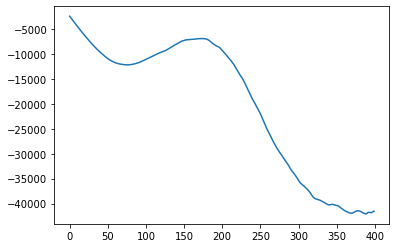

In [3]:
test_loglik_list = []
val_loglik_list = []

for i in range(15):
    
    print(i)

    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = keras.layers.GRU(hidden_state_size,return_sequences=True,return_state=True)(inputs=x_in,initial_state=hidden_state_in)

    hidden_model = keras.models.Model(inputs=[x_in,x_out,hidden_state_in],outputs=[output2,state])


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state= hidden_model([x_in,x_out,hidden_state_in])

    layer_hr = keras.layers.Dropout(0.3)(output2)
    layer_hr = keras.layers.Dense(64,activation="elu")(layer_hr)
    layer_hr = keras.layers.Dropout(0.3)(layer_hr)
    final_hr_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims_hr,bias_initializer='zeros'))(layer_hr) + hr_in
    sigma_mle_hr = (K.mean((final_hr_mean- hr_out)**2))**0.5

    loglik_hr = loglik_gaussian_hr(hr_out,final_hr_mean,sigma_mle_hr)

    nloglik_hr = loss(loglik_hr)

    rnn_training_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglik_hr])
    rnn_generate_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_hr_mean,sigma_mle_hr,state])


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = hidden_model([x_in,x_out,hidden_state_in],training=False)

    layer = keras.layers.Dropout(0.3)(output2)
    layer = keras.layers.Dense(64,activation="elu")(layer)
    layer = keras.layers.Dropout(0.3)(layer)
    final_x_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims,bias_initializer='zeros'))(layer) + x_in #this means we predict the residuals (better for learning)
    sigma_mle_x = (K.mean((final_x_mean- x_out)**2))**0.5


    loglik_x = loglik_gaussian_x(x_out,final_x_mean,sigma_mle_x)

    nloglikx = loss(loglik_x)

    rnn_training_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglikx])
    rnn_generate_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_x_mean,sigma_mle_x,state])

    @tf.function
    def train_step(inputs,model):
        """Decorated train_step function which applies a gradient update to the parameters"""
        with tf.GradientTape() as tape:
            loss = model(inputs,training=True)
            loss = tf.add_n([loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    optimizer=keras.optimizers.Adam(learning_rate=0.0003)

    def fit_model(input_list,epochs,model,simulator,history,validation_loss
                  ,valid_list,hr_toggle,index,batch_size=32):

        start = time.time()
        K.clear_session()

        batch_loss = []
        batches_per_epoch = int(np.ceil(input_list[0].shape[0]/batch_size))
        
        rnn_generate_x.save("tl_models/{}.h5".format(index))
        
        for epoch in range(epochs):
                print("Epoch {}/{}".format(epoch,epochs))
                for i in range(batches_per_epoch):
                    batch_list= create_batch(
                        input_list,batch_size)
                    loss = train_step(batch_list,model)
                    batch_loss.append(loss)
                    average_batch_loss = list_average(batch_loss)
                    print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

                training_loss_for_epoch = list_average(batch_loss)
                batch_loss = []
                history.append(training_loss_for_epoch)

                sigma_mle = simulator(input_list)[1]

                val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle,hr=hr_toggle)

                validation_loss.append(val_loss)
                if val_loss == min(validation_loss):
                    rnn_generate_x.save("tl_models/{}.h5".format(index))

                print_status_bar_epoch(input_list[0].shape[0]
                                 ,input_list[0].shape[0],training_loss_for_epoch,val_loss )

        done = time.time()
        elapsed = done-start

        
    training_losses = []
    validation_losses = []
    
    
    fit_model(input_list,20,rnn_training_hr,rnn_generate_hr,training_losses,validation_losses
              ,valid_list,hr_toggle=True,index=i,batch_size=32)
    
    
    hidden_model.trainable=False
    
    training_losses = []
    validation_losses = []
    
    @tf.function
    def train_step(inputs,model):
        """Decorated train_step function which applies a gradient update to the parameters"""
        with tf.GradientTape() as tape:
            loss = model(inputs,training=True)
            loss = tf.add_n([loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    optimizer=keras.optimizers.Adam(learning_rate=0.0003)

    def fit_model(input_list,epochs,model,simulator,history,validation_loss
                  ,valid_list,hr_toggle,index,batch_size=32):

        start = time.time()
        K.clear_session()

        batch_loss = []
        batches_per_epoch = int(np.ceil(input_list[0].shape[0]/batch_size))
        
        rnn_generate_x.save("tl_models/{}.h5".format(index))
        
        for epoch in range(epochs):
                print("Epoch {}/{}".format(epoch,epochs))
                for i in range(batches_per_epoch):
                    batch_list= create_batch(
                        input_list,batch_size)
                    loss = train_step(batch_list,model)
                    batch_loss.append(loss)
                    average_batch_loss = list_average(batch_loss)
                    print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

                training_loss_for_epoch = list_average(batch_loss)
                batch_loss = []
                history.append(training_loss_for_epoch)

                sigma_mle = simulator(input_list)[1]

                val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle,hr=hr_toggle)

                validation_loss.append(val_loss)
                if val_loss == min(validation_loss):
                    rnn_generate_x.save("tl_models/{}.h5".format(index))

                print_status_bar_epoch(input_list[0].shape[0]
                                 ,input_list[0].shape[0],training_loss_for_epoch,val_loss )

        done = time.time()
        elapsed = done-start

        plt.plot(validation_loss,label="validation")
        plt.show()

    fit_model(input_list,400,rnn_training_x,rnn_generate_x,training_losses,validation_losses
              ,valid_list,hr_toggle=False,index=i,batch_size=32)
    
    


    rnn_generate_x = keras.models.load_model("tl_models/{}.h5".format(i))
    
    sigma_x = rnn_generate_x(input_list)[1]
    mean = rnn_generate_x(test_list)[0]
    loglik = np.mean(loglik_gaussian_x(test_nn_output,mean,sigma_x))

    test_loglik_list.append(loglik)
    
    mean = rnn_generate_x(valid_list)[0]
    loglik = np.mean(loglik_gaussian_x(valid_nn_output,mean,sigma_x))

    val_loglik_list.append(loglik)
    
a = np.array(test_loglik_list)
b = np.array(val_loglik_list)
array_loglik = np.stack([b,a],axis=1)
np.save("tl_models/loglik_array.npy",array_loglik)


In [4]:
array_loglik

array([[   42935.605, 12172537.   ],
       [   37456.094,  7859012.5  ],
       [   43105.58 , 12572781.   ],
       [   33921.98 , 10520019.   ],
       [   43617.   , 13119034.   ],
       [   35021.113, 10472684.   ],
       [   43569.348, 12124057.   ],
       [   42114.87 , 10878155.   ],
       [   41142.652, 11870963.   ],
       [   41732.684, 12691811.   ],
       [   45894.945, 13568192.   ],
       [   35872.58 , 10332830.   ],
       [   44086.63 , 13114985.   ],
       [   42024.23 , 10683169.   ],
       [   42091.375, 11106295.   ]], dtype=float32)

# Best models

In [15]:
from sklearn.metrics import r2_score

## No TL

In [3]:
loglik_array = np.load("no_tl_models/loglik_array.npy")
loglik_array

array([[ 6.1956680e+03,  1.1927915e+06],
       [ 2.2687695e+03,  1.9294141e+05],
       [ 4.3025479e+03,  1.8221471e+06],
       [ 7.0743271e+03,  6.6966912e+05],
       [ 4.6198799e+03,  1.0997459e+06],
       [ 6.1552534e+03,  1.6493692e+06],
       [ 1.5622721e+04, -4.2539676e+07],
       [ 1.7983148e+04, -5.5524160e+07],
       [ 4.4403369e+03,  6.0822162e+05],
       [ 2.3452953e+04, -5.7496192e+07],
       [ 2.8787789e+04, -4.3018588e+07],
       [ 2.6836062e+03,  4.4158031e+05],
       [ 3.5686011e+03,  1.1398035e+06],
       [ 1.7767160e+04, -6.1743528e+07],
       [ 9.3129570e+03,  1.8329968e+06]], dtype=float32)

In [4]:
loglik_array[:,1].max()

1832996.8

(array([ 3.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0., 10.]),
 array([-61743530. , -55385876. , -49028224. , -42670572. , -36312920. ,
        -29955266. , -23597614. , -17239960. , -10882308. ,  -4524655.5,
          1832996.8], dtype=float32),
 <BarContainer object of 10 artists>)

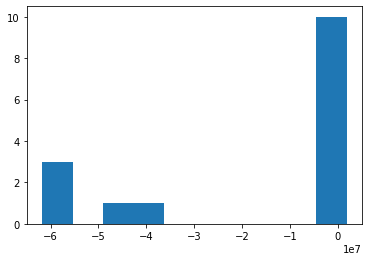

In [11]:
plt.hist(np.ravel(loglik_array[:,1]))

In [5]:
index = np.argmax(loglik_array[:,0])
index

10

In [6]:
loglik_array[index,1]

-43018588.0

In [7]:
loglik_array[index,1]/30000

-1433.9529333333332

In [7]:
rnn_no_tl = keras.models.load_model("no_tl_models/{}.h5".format(index))

2022-09-12 14:17:37.495508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-12 14:17:38.127523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7408 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:3b:00.0, compute capability: 6.1


In [8]:
sigma = rnn_no_tl(input_list)[1]
sigma

2022-09-12 14:17:39.686365: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


<tf.Tensor: shape=(), dtype=float32, numpy=0.007548641>

In [40]:
mean = rnn_no_tl(test_list)[0]

r2_score(np.ravel(test_list[1]),np.ravel(mean))

0.9979269934184647

In [27]:
np.mean((test_list[1] - mean)**2)

0.0017288986

In [9]:
np.mean(loglik_gaussian_x(mean,test_list[1],sigma))

NameError: name 'mean' is not defined

## TL

In [8]:
loglik_array = np.load("tl_models/loglik_array.npy")
loglik_array

array([[   42935.605, 12172537.   ],
       [   37456.094,  7859012.5  ],
       [   43105.58 , 12572781.   ],
       [   33921.98 , 10520019.   ],
       [   43617.   , 13119034.   ],
       [   35021.113, 10472684.   ],
       [   43569.348, 12124057.   ],
       [   42114.87 , 10878155.   ],
       [   41142.652, 11870963.   ],
       [   41732.684, 12691811.   ],
       [   45894.945, 13568192.   ],
       [   35872.58 , 10332830.   ],
       [   44086.63 , 13114985.   ],
       [   42024.23 , 10683169.   ],
       [   42091.375, 11106295.   ]], dtype=float32)

In [9]:
index = np.argmax(loglik_array[:,0])
index

10

In [10]:
loglik_array[index,1]

13568192.0

In [11]:
loglik_array[index,1]/30000

452.2730666666667

(array([1., 0., 0., 0., 4., 2., 0., 3., 2., 3.]),
 array([ 7859012.5,  8429930. ,  9000848. ,  9571766. , 10142684. ,
        10713602. , 11284520. , 11855438. , 12426356. , 12997274. ,
        13568192. ], dtype=float32),
 <BarContainer object of 10 artists>)

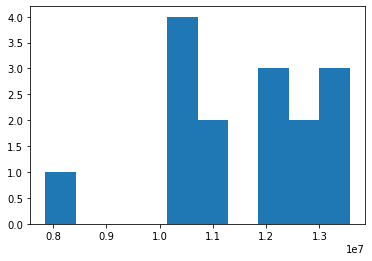

In [11]:
plt.hist(np.ravel(loglik_array[:,1]))

In [12]:
rnn_tl = keras.models.load_model("tl_models/{}.h5".format(index))

In [13]:
sigma = rnn_tl(input_list)[1]
sigma

<tf.Tensor: shape=(), dtype=float32, numpy=0.005267659>

In [16]:
mean = rnn_tl(test_list)[0]

r2_score(np.ravel(test_list[1]),np.ravel(mean))

0.9999471836248429

In [17]:
np.mean((test_list[1] - mean)**2)

4.4049164e-05

In [18]:
np.mean(loglik_gaussian_x(mean,test_list[1],sigma))

13568192.0